# Setup and Preprocessing

## Load code and data

In [1]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# data exploration
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# cross validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict

# tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import validation_curve

# staticial comparison of model performance
# see https://github.com/janezd/baycomp
# to install library:
# pip install baycomp
from baycomp.single import two_on_single

# feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# stats
import scipy.stats as stats

In [2]:
# load original data set into a dataframe
data = pd.read_csv("cleaned_cope_data_randomized_corrected2.csv", dtype={'b_bstad_me_30_days_8': 'str', 'b_bstad_me_90_days_6': 'str', 'b_bstad_me_90_days_8': 'str'})

In [2]:
# alternatively, load preprocessed data set into a dataframe
data = pd.read_csv('data_preproc.csv')

## Initial data exploration, reduction, and imputation

In [3]:
# general info including rows and columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Columns: 544 entries, Unnamed: 0 to b_uls_tot
dtypes: float64(421), int64(60), object(63)
memory usage: 10.2+ MB


In [4]:
# reduce to columns of interest
data = data[['b_uls_tot', 'b_cdi_tot', 'b_dem_sex', 'b_dem_gender', 'b_dem_orientation', 
             'b_bads_tot', 'b_shs_tot' , 'b_bhs_tot', 'b_aces_tot' , 'b_mvps_tot', 
             'eds_events_tot', 'b_gad_tot', 'b_sitbi_2',  'b_sitbi_8', 
             'b_sitbi_nssi_year_1', 'b_sitbi_si_year_1', 'b_sitbi_attempt_year_1', 'b_sitbi_17']]

# more detail about columns of interest 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   b_uls_tot               2446 non-null   float64
 1   b_cdi_tot               2448 non-null   float64
 2   b_dem_sex               2452 non-null   object 
 3   b_dem_gender            2452 non-null   object 
 4   b_dem_orientation       2452 non-null   object 
 5   b_bads_tot              2448 non-null   float64
 6   b_shs_tot               2450 non-null   float64
 7   b_bhs_tot               2451 non-null   float64
 8   b_aces_tot              2447 non-null   float64
 9   b_mvps_tot              2447 non-null   float64
 10  eds_events_tot          2448 non-null   float64
 11  b_gad_tot               2447 non-null   float64
 12  b_sitbi_2               2451 non-null   float64
 13  b_sitbi_8               2452 non-null   int64  
 14  b_sitbi_nssi_year_1     1604 non-null   

In [5]:
# give columns more intuitive names
data.rename(columns = {'b_uls_tot':'loneliness', 'b_cdi_tot':'depression', 'b_dem_sex':'sex',
                        'b_dem_gender':'gender', 'b_dem_orientation':'orientation', 'b_bads_tot':'behav_act',
                        'b_shs_tot':'hope', 'b_bhs_tot':'hopelessness', 'b_aces_tot':'child_adverse',
                        'b_mvps_tot':'peer_vict', 'eds_events_tot':'discrimination', 
                        'b_gad_tot':'anxiety', 'b_sitbi_2':'nssi_bin', 'b_sitbi_8':'si_bin',
                        'b_sitbi_nssi_year_1':'nssi_year', 'b_sitbi_si_year_1':'si_year',
                        'b_sitbi_attempt_year_1':'attempt_year', 'b_sitbi_17':'attempt_bin'}, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2446 non-null   float64
 1   depression      2448 non-null   float64
 2   sex             2452 non-null   object 
 3   gender          2452 non-null   object 
 4   orientation     2452 non-null   object 
 5   behav_act       2448 non-null   float64
 6   hope            2450 non-null   float64
 7   hopelessness    2451 non-null   float64
 8   child_adverse   2447 non-null   float64
 9   peer_vict       2447 non-null   float64
 10  discrimination  2448 non-null   float64
 11  anxiety         2447 non-null   float64
 12  nssi_bin        2451 non-null   float64
 13  si_bin          2452 non-null   int64  
 14  nssi_year       1604 non-null   float64
 15  si_year         1955 non-null   float64
 16  attempt_year    774 non-null    float64
 17  attempt_bin     2452 non-null   i

In [6]:
# missing data counts
data.isnull().sum()

loneliness           6
depression           4
sex                  0
gender               0
orientation          0
behav_act            4
hope                 2
hopelessness         1
child_adverse        5
peer_vict            5
discrimination       4
anxiety              5
nssi_bin             1
si_bin               0
nssi_year          848
si_year            497
attempt_year      1678
attempt_bin          0
dtype: int64

In [7]:
# delete whole samples missing values for nssi_bin, si_bin, or attempt_bin
# these are yes/no target variables with branching logic for whether other target variables were presented
# only nssi_bin has a single missing value
data = data[data['nssi_bin'].notna()]
data.reset_index(drop=True, inplace=True)

# confirming drop of 1 sample
data.shape

(2451, 18)

In [8]:
# missing data counts
data.isnull().sum()

loneliness           6
depression           4
sex                  0
gender               0
orientation          0
behav_act            3
hope                 2
hopelessness         1
child_adverse        5
peer_vict            5
discrimination       4
anxiety              5
nssi_bin             0
si_bin               0
nssi_year          848
si_year            497
attempt_year      1677
attempt_bin          0
dtype: int64

In [9]:
# Which missing values for nssi_year can be assumed to be (and imputed as) zero?
print("How many answered no to nssi_bin and are missing value for nssi_year?")
print(data.loc[data['nssi_bin'] == 0, 'nssi_year'].isnull().sum())
print("How many answered yes to nssi_bin and are missing value for nssi_year?")
print(data.loc[data['nssi_bin'] == 1, 'nssi_year'].isnull().sum())

How many answered no to nssi_bin and are missing value for nssi_year?
798
How many answered yes to nssi_bin and are missing value for nssi_year?
50


In [10]:
# Which missing values for si_year can be assumed to be (and imputed as) zero?
print("How many answered no to si_bin and are missing value for si_year?")
print(data.loc[data['si_bin'] == 0, 'si_year'].isnull().sum())
print("How many answered yes to si_bin and are missing value for si_year?")
print(data.loc[data['si_bin'] == 1, 'si_year'].isnull().sum())

How many answered no to si_bin and are missing value for si_year?
461
How many answered yes to si_bin and are missing value for si_year?
36


In [11]:
# Which missing values for attempt_year can be assumed to be (and imputed as) zero?
print("How many answered no to attempt_bin and are missing value for attempt_year?")
print(data.loc[data['attempt_bin'] == 0, 'attempt_year'].isnull().sum())
print("How many answered yes to attempt_bin and are missing value for attempt_year?")
print(data.loc[data['attempt_bin'] == 1, 'attempt_year'].isnull().sum())

How many answered no to attempt_bin and are missing value for attempt_year?
1668
How many answered yes to attempt_bin and are missing value for attempt_year?
9


In [12]:
# replace missing outcome values with zeros where appropriate
# (participant responded they did not engage in the behavior with binary measure)
data.loc[data['nssi_bin'] == 0 & data['nssi_year'].isnull(), 'nssi_year'] = 0
data.loc[data['si_bin'] == 0 & data['si_year'].isnull(), 'si_year'] = 0
data.loc[data['attempt_bin'] == 0 & data['attempt_year'].isnull(), 'attempt_year'] = 0

data.isnull().sum()

loneliness         6
depression         4
sex                0
gender             0
orientation        0
behav_act          3
hope               2
hopelessness       1
child_adverse      5
peer_vict          5
discrimination     4
anxiety            5
nssi_bin           0
si_bin             0
nssi_year         50
si_year           36
attempt_year       9
attempt_bin        0
dtype: int64

In [13]:
# how many unique values per outcome
for c in data.columns:
    print(len(data[c].unique()), "unique values in column", c)

58 unique values in column loneliness
26 unique values in column depression
4 unique values in column sex
189 unique values in column gender
10 unique values in column orientation
52 unique values in column behav_act
44 unique values in column hope
14 unique values in column hopelessness
7 unique values in column child_adverse
34 unique values in column peer_vict
51 unique values in column discrimination
23 unique values in column anxiety
2 unique values in column nssi_bin
2 unique values in column si_bin
112 unique values in column nssi_year
143 unique values in column si_year
19 unique values in column attempt_year
2 unique values in column attempt_bin


In [14]:
# preview data
data.head() 

loneliness  depression     sex      gender            orientation  \
0        44.0        21.0  Female  Woman/Girl  Heterosexual/Straight   
1        33.0        14.0  Female  Woman/Girl               Bisexual   
2        27.0         9.0    Male    Not sure                  Queer   
3        44.0        11.0  Female  Woman/Girl  Heterosexual/Straight   
4        27.0         7.0  Female  Woman/Girl  Heterosexual/Straight   

   behav_act  hope  hopelessness  child_adverse  peer_vict  discrimination  \
0       10.0  13.0          11.0            3.0       14.0            29.0   
1       18.0  23.0           7.0            2.0        0.0            34.0   
2       18.0  17.0           7.0            4.0        4.0            32.0   
3       20.0  26.0           7.0            4.0        5.0            23.0   
4       28.0  20.0           4.0            1.0        0.0            16.0   

   anxiety  nssi_bin  si_bin  nssi_year  si_year  attempt_year  attempt_bin  
0     17.0       1.0       1        3.0    300.0           0.0            0  
1     22.0       1.0       1        0.0     50.0           0.0            0  
2     18.0       1.0       1       25.0      5.0           1.0            1  
3     20.0       0.0       1        0.0    102.0           0.0            0  
4     11.0       0.0       0        0.0      0.0           0.0            0

In [15]:
# look at gender values, which need to be recoded
data['gender'].value_counts()

Woman/Girl                                                                                                      1383
Man/Boy                                                                                                          194
Nonbinary                                                                                                        138
Not sure                                                                                                          78
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Trans masculine                                     71
                                                                                                                ... 
Woman/Girl,Gender expansive,Androgynous                                                                            1
Female to male transgender/FTM,Androgynous,Nonbinary                                                               1
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Tr

In [16]:
# recode gender values into 3 categories
data.loc[data['gender'] == 'Woman/Girl', 'gender'] = 'woman_only'
data.loc[data['gender'] == 'Man/Boy', 'gender'] = 'man_only'
data.loc[(data['gender'] != 'man_only') & (data['gender'] != 'woman_only'), 'gender'] = 'gender_diverse'

In [17]:
# verify recoding results
data['gender'].value_counts()

woman_only        1383
gender_diverse     874
man_only           194
Name: gender, dtype: int64

## Deeper data exploration and outlier management

### Features: numeric

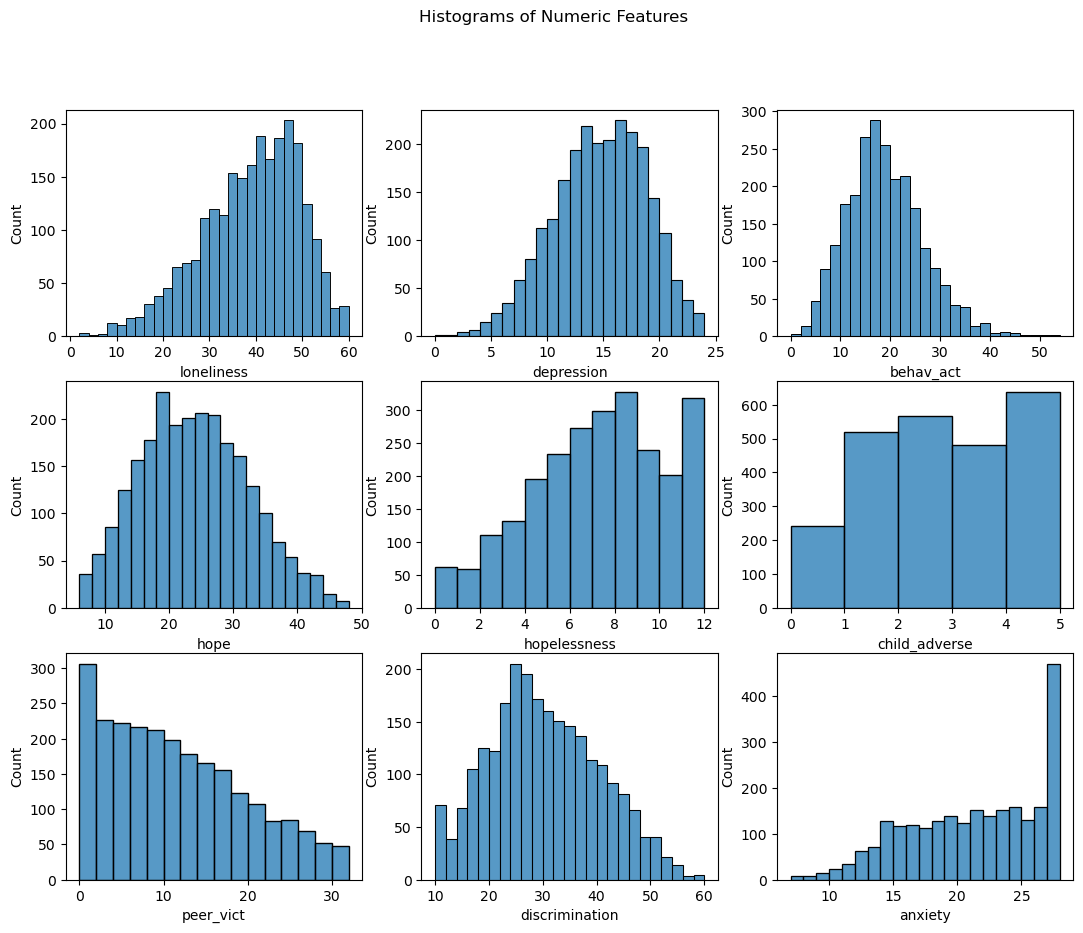

In [18]:
# histograms of numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Histograms of Numeric Features')

sns.histplot(ax=axes[0, 0], data=data['loneliness'], binwidth=2)
sns.histplot(ax=axes[0, 1], data=data['depression'], binwidth=1)
sns.histplot(ax=axes[0, 2], data=data['behav_act'], binwidth=2)
sns.histplot(ax=axes[1, 0], data=data['hope'], binwidth=2)
sns.histplot(ax=axes[1, 1], data=data['hopelessness'], binwidth=1)
sns.histplot(ax=axes[1, 2], data=data['child_adverse'], binwidth=1)
sns.histplot(ax=axes[2, 0], data=data['peer_vict'], binwidth=2)
sns.histplot(ax=axes[2, 1], data=data['discrimination'], binwidth=2)
sns.histplot(ax=axes[2, 2], data=data['anxiety'], binwidth=1)

# don't show unnecessary output about object
None

In [19]:
# examine correlations between numeric features
numeric_features = ['loneliness', 'depression', 'behav_act', 'hope', 'hopelessness', 
                    'child_adverse', 'peer_vict', 'discrimination', 'anxiety']
data[numeric_features].corr()

loneliness  depression  behav_act      hope  hopelessness  \
loneliness        1.000000    0.550011  -0.478647 -0.423158      0.508124   
depression        0.550011    1.000000  -0.643446 -0.563095      0.634688   
behav_act        -0.478647   -0.643446   1.000000  0.580059     -0.531347   
hope             -0.423158   -0.563095   0.580059  1.000000     -0.594862   
hopelessness      0.508124    0.634688  -0.531347 -0.594862      1.000000   
child_adverse     0.225473    0.302187  -0.283846 -0.189588      0.172272   
peer_vict         0.272284    0.322832  -0.244080 -0.175221      0.268169   
discrimination    0.347911    0.433894  -0.334728 -0.238655      0.340686   
anxiety           0.380203    0.564212  -0.440418 -0.274598      0.415289   

                child_adverse  peer_vict  discrimination   anxiety  
loneliness           0.225473   0.272284        0.347911  0.380203  
depression           0.302187   0.322832        0.433894  0.564212  
behav_act           -0.283846  -0.244080       -0.334728 -0.440418  
hope                -0.189588  -0.175221       -0.238655 -0.274598  
hopelessness         0.172272   0.268169        0.340686  0.415289  
child_adverse        1.000000   0.263421        0.341760  0.268789  
peer_vict            0.263421   1.000000        0.625618  0.342707  
discrimination       0.341760   0.625618        1.000000  0.421275  
anxiety              0.268789   0.342707        0.421275  1.000000

<AxesSubplot:>

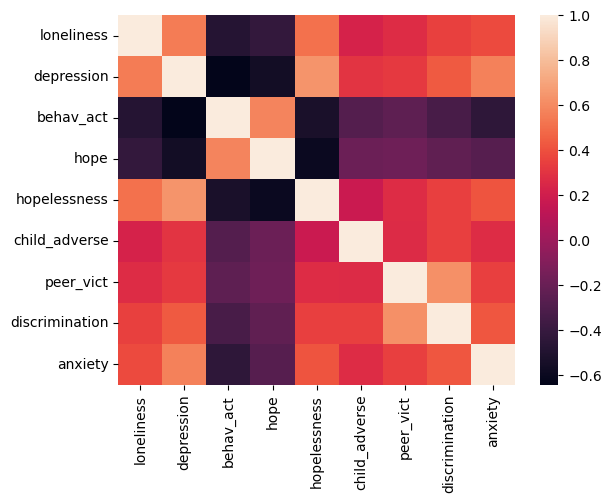

In [20]:
# visualize correlations
sns.heatmap(data[numeric_features].corr())

We can see some expected relationships.   
Strong correlations between loneliness, hopelessness, depression, and anxiety  
These tend to be inversely related to behavioral activation and hope.  
Also strong correlation between discrimination and peer victimization  
In general, a lot of correlation among predictors

### Features: categorical

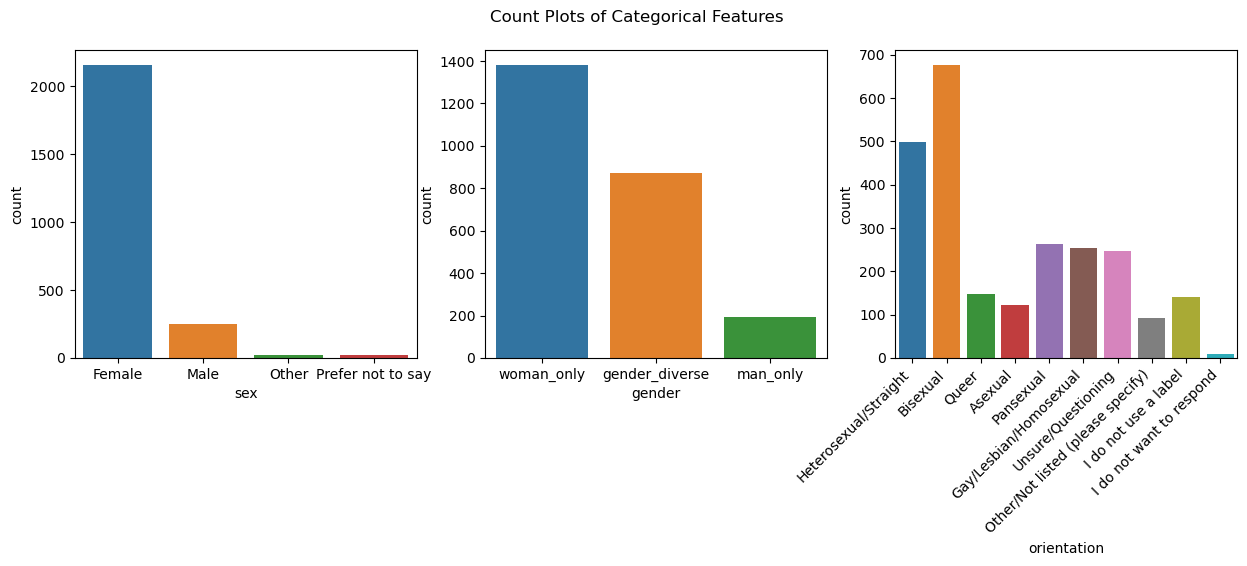

In [21]:
# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Features')

sns.countplot(ax=axes[0], x=data['sex'])

sns.countplot(ax=axes[1], x=data['gender'])

sns.countplot(ax=axes[2], x=data['orientation'])

plt.xticks(rotation=45, horizontalalignment='right')
None

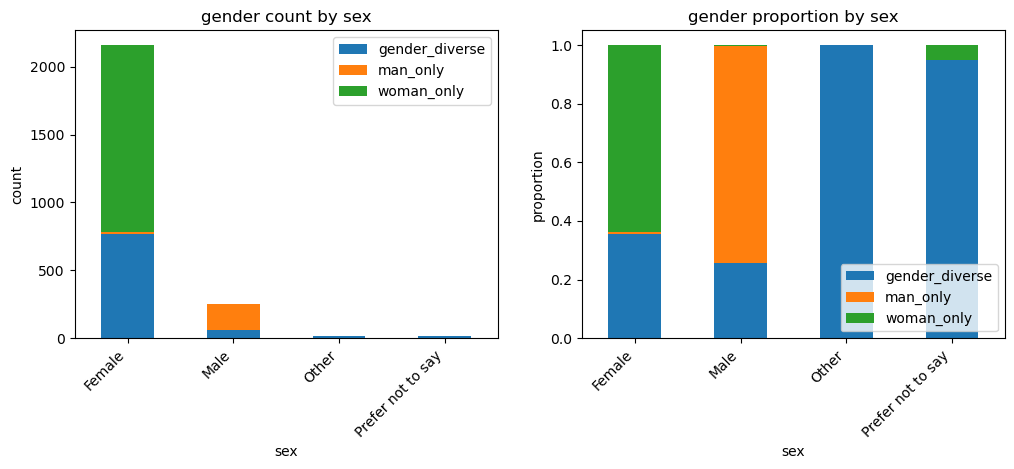

In [22]:
# examining distribution of gender by sex
cross_tab_sex_gender = pd.crosstab(index=data['sex'], columns=data['gender'])
cross_tab_sex_gender_norm = pd.crosstab(index=data['sex'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_sex_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("sex")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by sex")

cross_tab_sex_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("sex")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by sex")

None

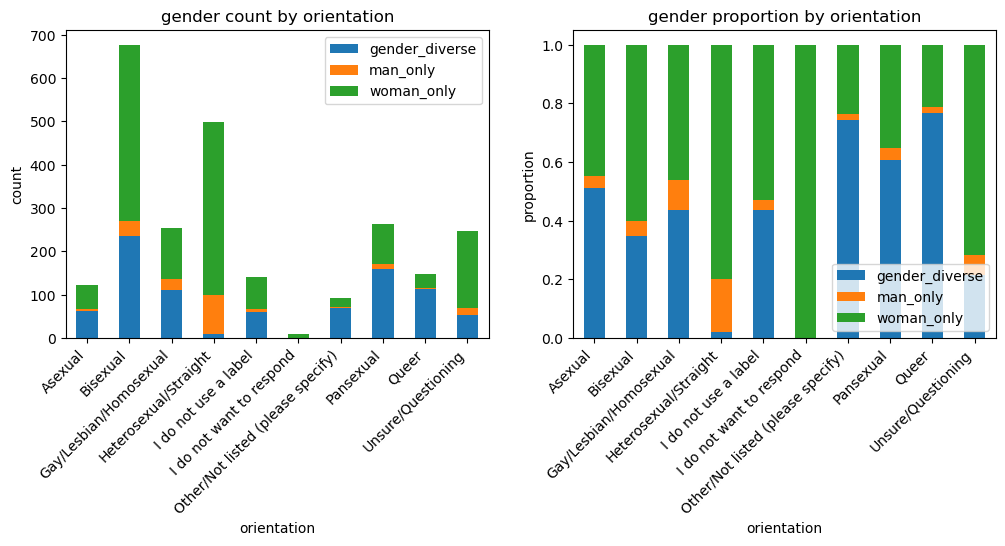

In [23]:
# examining distribution of gender by orientation
cross_tab_orient_gender = pd.crosstab(index=data['orientation'], columns=data['gender'])
cross_tab_orient_gender_norm = pd.crosstab(index=data['orientation'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_orient_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("orientation")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by orientation")

cross_tab_orient_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("orientation")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by orientation")

None

### Targets: numeric

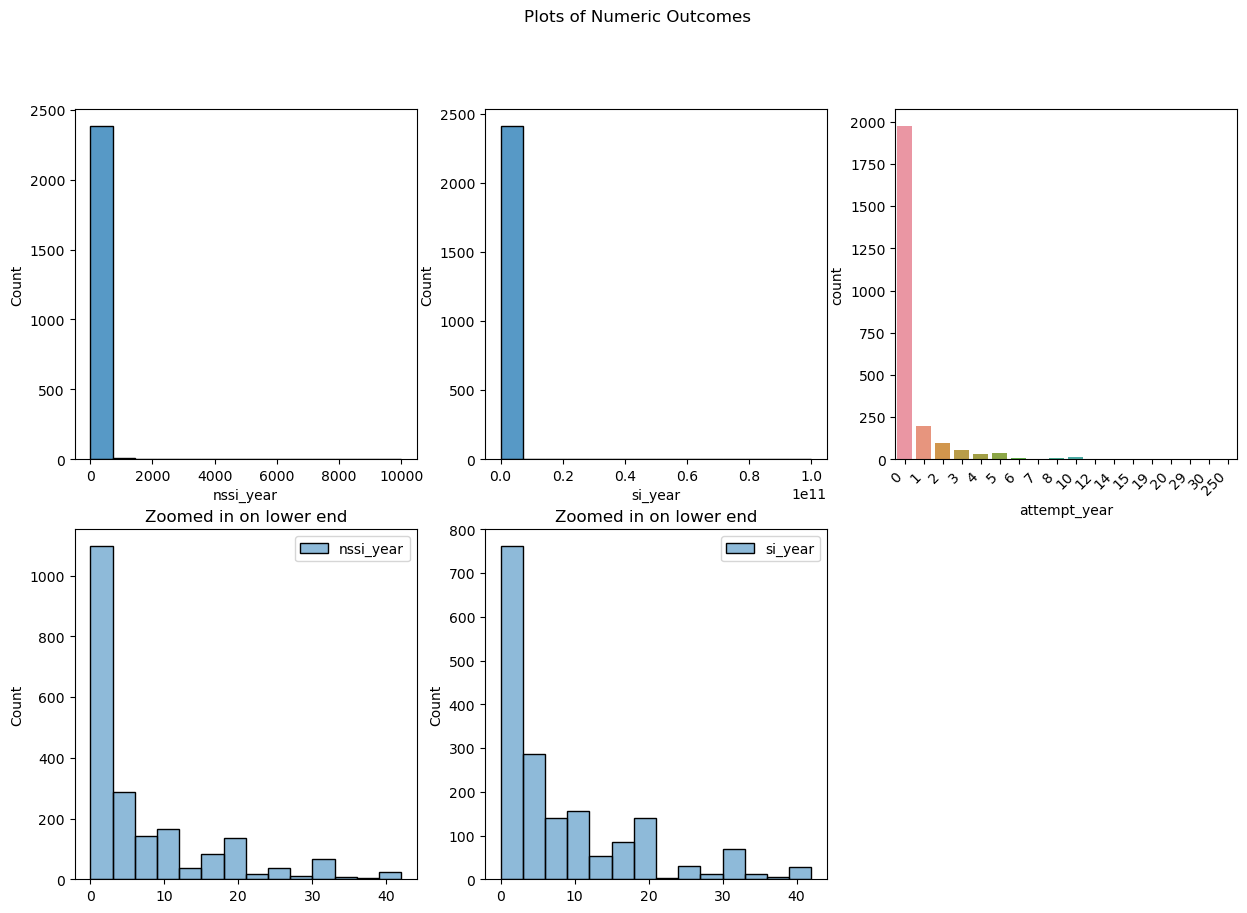

In [24]:
# plots of numeric targets
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Plots of Numeric Outcomes')

sns.histplot(ax=axes[0, 0], data=data['nssi_year'], bins=14)

sns.histplot(ax=axes[0, 1], data=data['si_year'], bins=14)

sns.countplot(ax=axes[0, 2], x=data.loc[data['attempt_year'].notna(), 'attempt_year'].astype('int'))
plt.sca(axes[0, 2])
plt.xticks(rotation=45, horizontalalignment='right')

sns.histplot(ax=axes[1, 0], data=data.loc[data['nssi_year'] < 43, ['nssi_year']], bins=14)
axes[1, 0].set_title("Zoomed in on lower end")

sns.histplot(ax=axes[1, 1], data=data.loc[data['si_year'] < 43, ['si_year']], bins=14)
axes[1, 1].set_title("Zoomed in on lower end")

fig.delaxes(axes[1, 2])

None

In [25]:
# examine correlations between outcome variables
data[['nssi_year', 'si_year', 'attempt_year']].corr()

nssi_year   si_year  attempt_year
nssi_year      1.000000  0.049948      0.068214
si_year        0.049948  1.000000      0.012383
attempt_year   0.068214  0.012383      1.000000

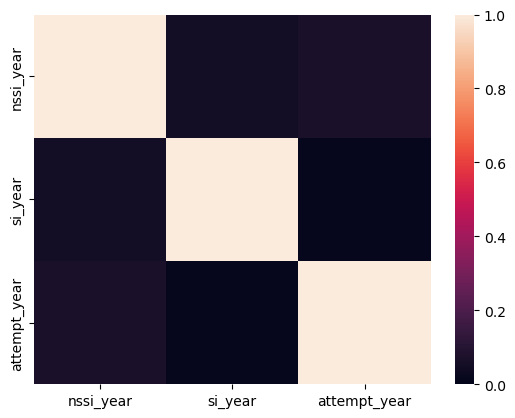

In [26]:
# visualize correlations
sns.heatmap(data[['nssi_year', 'si_year', 'attempt_year']].corr(), vmin=0, vmax=1)
None

Suprisingly little correlation between numeric outcome variables?

In [27]:
# limit some extremely large response values for outcome year variables
# to avoid issues related to extreme outliers and/or unrealistic values

# for nssi, 1000 would correspond roughly to average of 3 per day
data.loc[data['nssi_year'] > 1000, 'nssi_year'] = 1000

# same for si
data.loc[data['si_year'] > 1000, 'si_year'] = 1000

# for attempt, only one value greater than 30, will cap at 50
data.loc[data['attempt_year'] > 30, 'attempt_year'] = 50

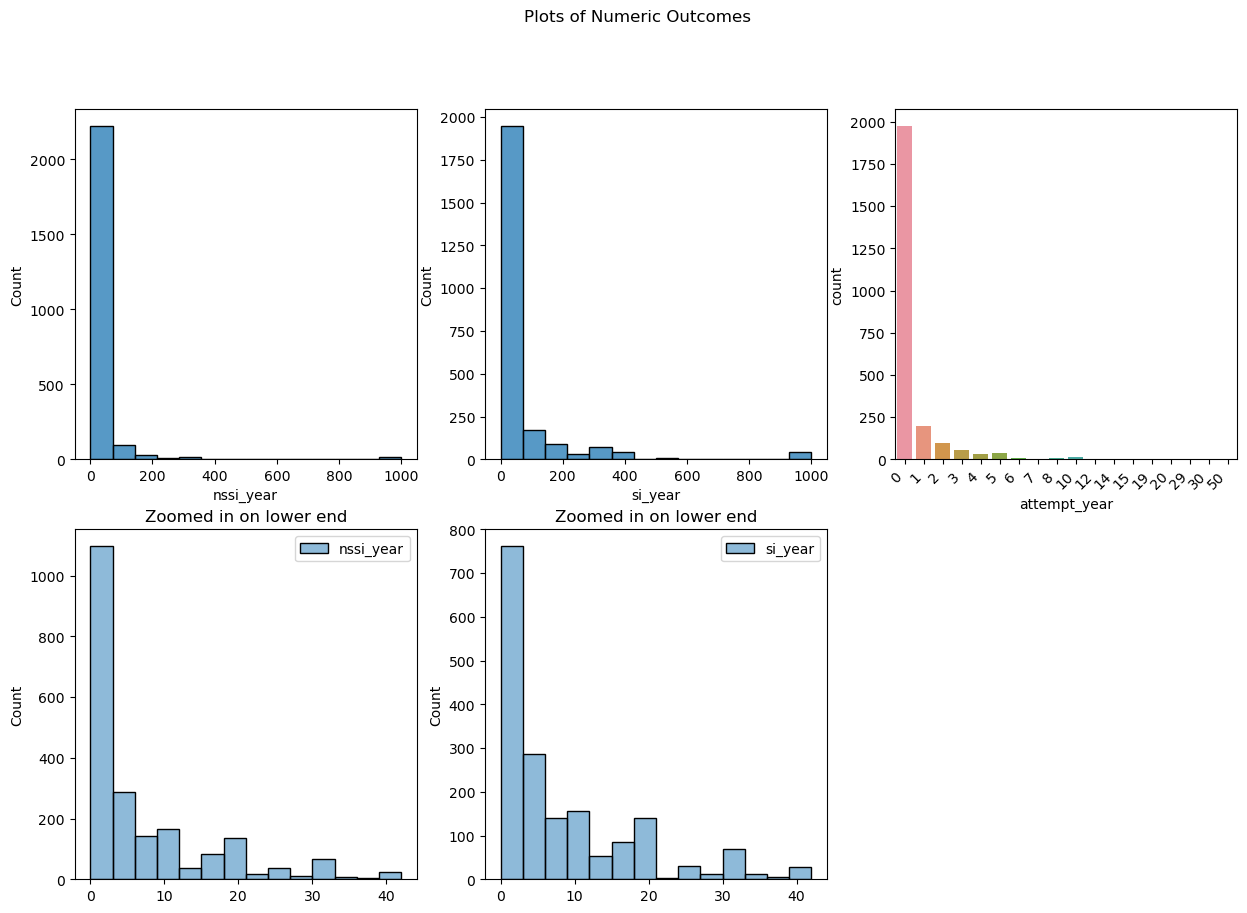

In [28]:
# redo plots and correations of outcomes after constraining outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Plots of Numeric Outcomes')

sns.histplot(ax=axes[0, 0], data=data['nssi_year'], bins=14)

sns.histplot(ax=axes[0, 1], data=data['si_year'], bins=14)

sns.countplot(ax=axes[0, 2], x=data.loc[data['attempt_year'].notna(), 'attempt_year'].astype('int'))
plt.sca(axes[0, 2])
plt.xticks(rotation=45, horizontalalignment='right')

sns.histplot(ax=axes[1, 0], data=data.loc[data['nssi_year'] < 43, ['nssi_year']], bins=14)
axes[1, 0].set_title("Zoomed in on lower end")

sns.histplot(ax=axes[1, 1], data=data.loc[data['si_year'] < 43, ['si_year']], bins=14)
axes[1, 1].set_title("Zoomed in on lower end")

fig.delaxes(axes[1, 2])

None

In [29]:
data[['nssi_year', 'si_year', 'attempt_year']].corr()

nssi_year   si_year  attempt_year
nssi_year      1.000000  0.313511      0.165091
si_year        0.313511  1.000000      0.229054
attempt_year   0.165091  0.229054      1.000000

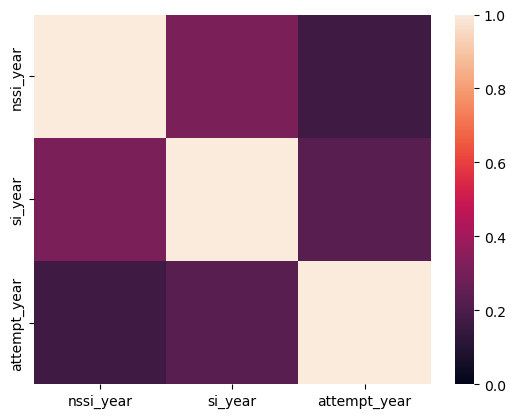

In [30]:
sns.heatmap(data[['nssi_year', 'si_year', 'attempt_year']].corr(), vmin=0, vmax=1)
None

Constraining outliers did increase correlations, but they are still small-to-moderate.

### Targets: categorical

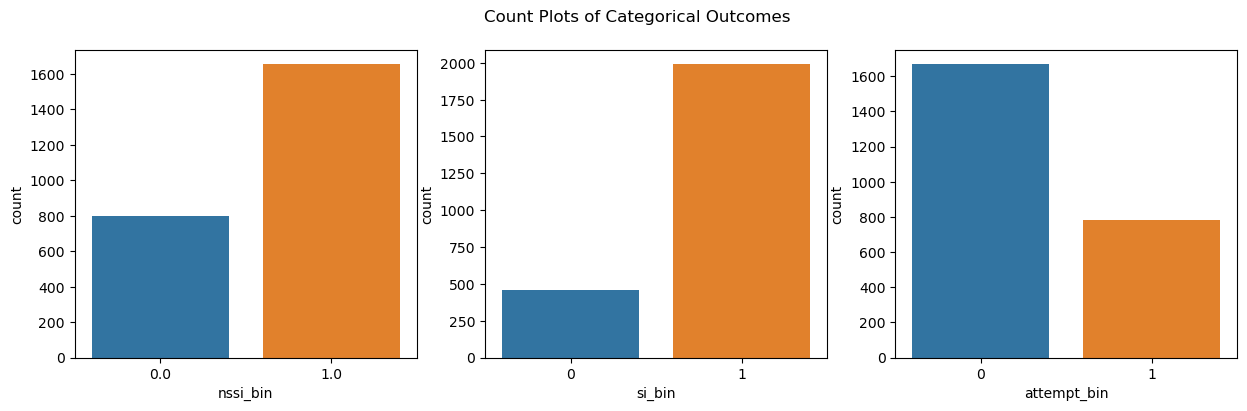

In [31]:
# count plots of categorical target variables

# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Outcomes')

sns.countplot(ax=axes[0], x=data['nssi_bin'])

sns.countplot(ax=axes[1], x=data['si_bin'])

sns.countplot(ax=axes[2], x=data['attempt_bin'])

None

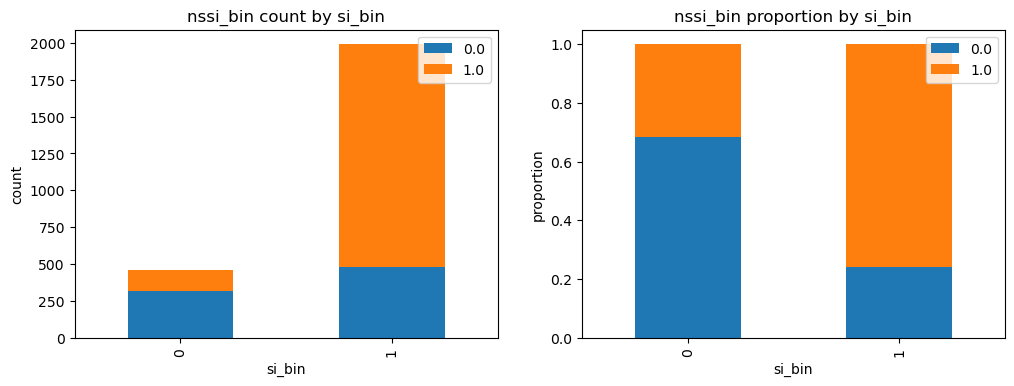

In [32]:
# examining distribution of si_bin by nssi_bin
cross_tab_si_nssi = pd.crosstab(index=data['si_bin'], columns=data['nssi_bin'])
cross_tab_si_nssi_norm = pd.crosstab(index=data['si_bin'], columns=data['nssi_bin'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_si_nssi.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("si_bin")
axes[0].set_ylabel("count")
axes[0].set_title("nssi_bin count by si_bin")

cross_tab_si_nssi_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="upper right", ncol=1)
axes[1].set_xlabel("si_bin")
axes[1].set_ylabel("proportion")
axes[1].set_title("nssi_bin proportion by si_bin")

None

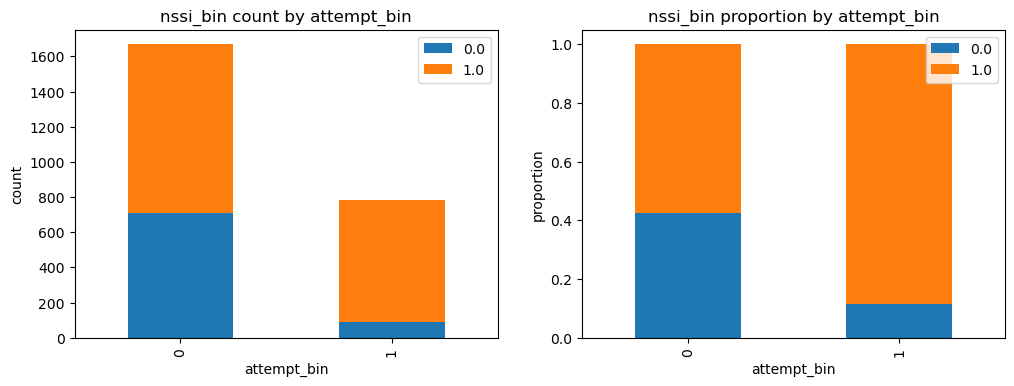

In [33]:
# examining distribution of attempt_bin by nssi_bin
cross_tab_attempt_nssi = pd.crosstab(index=data['attempt_bin'], columns=data['nssi_bin'])
cross_tab_attempt_nssi_norm = pd.crosstab(index=data['attempt_bin'], columns=data['nssi_bin'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_attempt_nssi.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("attempt_bin")
axes[0].set_ylabel("count")
axes[0].set_title("nssi_bin count by attempt_bin")

cross_tab_attempt_nssi_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="upper right", ncol=1)
axes[1].set_xlabel("attempt_bin")
axes[1].set_ylabel("proportion")
axes[1].set_title("nssi_bin proportion by attempt_bin")

None

### Target-feature relationships

In [34]:
# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns)],
    remainder='passthrough')

# preprocess features
features_full = preprocessor.fit_transform(features)
features_full = KNNImputer(n_neighbors=5).fit_transform(features_full)
feature_names = list(preprocessor.named_transformers_['categorical'].get_feature_names_out()) + list(numeric_columns)
features_full = pd.DataFrame(features_full, columns=feature_names)

# define function to compute mutual information scores
def make_mi_scores(X, y, classify=1):
    if classify == 1:
        mi_scores = mutual_info_classif(X, y, discrete_features=True)
    else:
        mi_scores = mutual_info_regression(X, y, discrete_features=True)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [35]:
mi_nssi_bin = make_mi_scores(features_full, data['nssi_bin'])
print(mi_nssi_bin)

depression                                       0.058059
discrimination                                   0.047545
behav_act                                        0.040059
anxiety                                          0.038831
child_adverse                                    0.035500
loneliness                                       0.034072
peer_vict                                        0.029190
hopelessness                                     0.024562
orientation_Heterosexual/Straight                0.024001
gender_gender_diverse                            0.022760
hope                                             0.021065
gender_woman_only                                0.008724
sex_Male                                         0.008679
gender_man_only                                  0.007729
sex_Female                                       0.006742
orientation_Bisexual                             0.005374
orientation_Pansexual                            0.004053
orientation_Qu

C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users

In [36]:
mi_si_bin = make_mi_scores(features_full, data['si_bin'])
print(mi_si_bin)

depression                                       0.057696
behav_act                                        0.042808
child_adverse                                    0.038627
loneliness                                       0.037754
anxiety                                          0.034068
discrimination                                   0.033243
hope                                             0.027037
hopelessness                                     0.026513
orientation_Heterosexual/Straight                0.020319
peer_vict                                        0.017563
gender_gender_diverse                            0.011891
orientation_Bisexual                             0.005213
gender_man_only                                  0.004610
sex_Male                                         0.004114
gender_woman_only                                0.003955
sex_Female                                       0.002604
orientation_Pansexual                            0.002442
orientation_Qu

C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users

In [37]:
mi_attempt_bin = make_mi_scores(features_full, data['attempt_bin'])
print(mi_attempt_bin)

discrimination                                   0.070808
depression                                       0.065083
peer_vict                                        0.045422
child_adverse                                    0.045169
behav_act                                        0.041544
anxiety                                          0.038679
loneliness                                       0.035958
hopelessness                                     0.030539
hope                                             0.027976
gender_gender_diverse                            0.013525
orientation_Heterosexual/Straight                0.011849
gender_woman_only                                0.008449
orientation_Pansexual                            0.005362
sex_Male                                         0.001964
gender_man_only                                  0.001596
orientation_I do not want to respond             0.001574
orientation_Bisexual                             0.001252
orientation_Qu

C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users

In [38]:
nulls = data['nssi_year'].isna()
mi_nssi_year = make_mi_scores(features_full[nulls == 0], data['nssi_year'][nulls == 0], 0)
print(mi_nssi_year)

depression                                       0.065656
peer_vict                                        0.062931
loneliness                                       0.055290
anxiety                                          0.054733
discrimination                                   0.042472
gender_gender_diverse                            0.040625
hopelessness                                     0.035722
child_adverse                                    0.034597
orientation_Heterosexual/Straight                0.022894
hope                                             0.022723
gender_woman_only                                0.020425
orientation_Asexual                              0.011766
orientation_Queer                                0.009305
gender_man_only                                  0.007808
orientation_Gay/Lesbian/Homosexual               0.007780
sex_Male                                         0.006692
sex_Female                                       0.005230
orientation_Pa

In [39]:
nulls = data['si_year'].isna()
mi_si_year = make_mi_scores(features_full[nulls == 0], data['si_year'][nulls == 0], 0)
print(mi_si_year)

depression                                       0.141602
hopelessness                                     0.097753
anxiety                                          0.083827
behav_act                                        0.078767
loneliness                                       0.058878
hope                                             0.045616
child_adverse                                    0.042301
peer_vict                                        0.040256
discrimination                                   0.030461
orientation_Heterosexual/Straight                0.025462
gender_gender_diverse                            0.020327
gender_woman_only                                0.013893
orientation_Pansexual                            0.011257
orientation_Bisexual                             0.011123
orientation_Unsure/Questioning                   0.009392
orientation_Queer                                0.007590
sex_Prefer not to say                            0.005841
gender_man_onl

In [40]:
nulls = data['attempt_year'].isna()
mi_attempt_year = make_mi_scores(features_full[nulls == 0], data['attempt_year'][nulls == 0], 0)
print(mi_attempt_year)

depression                                       0.076865
discrimination                                   0.076283
peer_vict                                        0.056715
hopelessness                                     0.043089
behav_act                                        0.041757
anxiety                                          0.033205
hope                                             0.032698
loneliness                                       0.021158
child_adverse                                    0.020078
orientation_Bisexual                             0.011454
orientation_Heterosexual/Straight                0.006196
gender_woman_only                                0.005766
gender_gender_diverse                            0.004829
gender_man_only                                  0.003871
orientation_Unsure/Questioning                   0.003653
sex_Male                                         0.002702
orientation_Other/Not listed (please specify)    0.002111
orientation_Pa

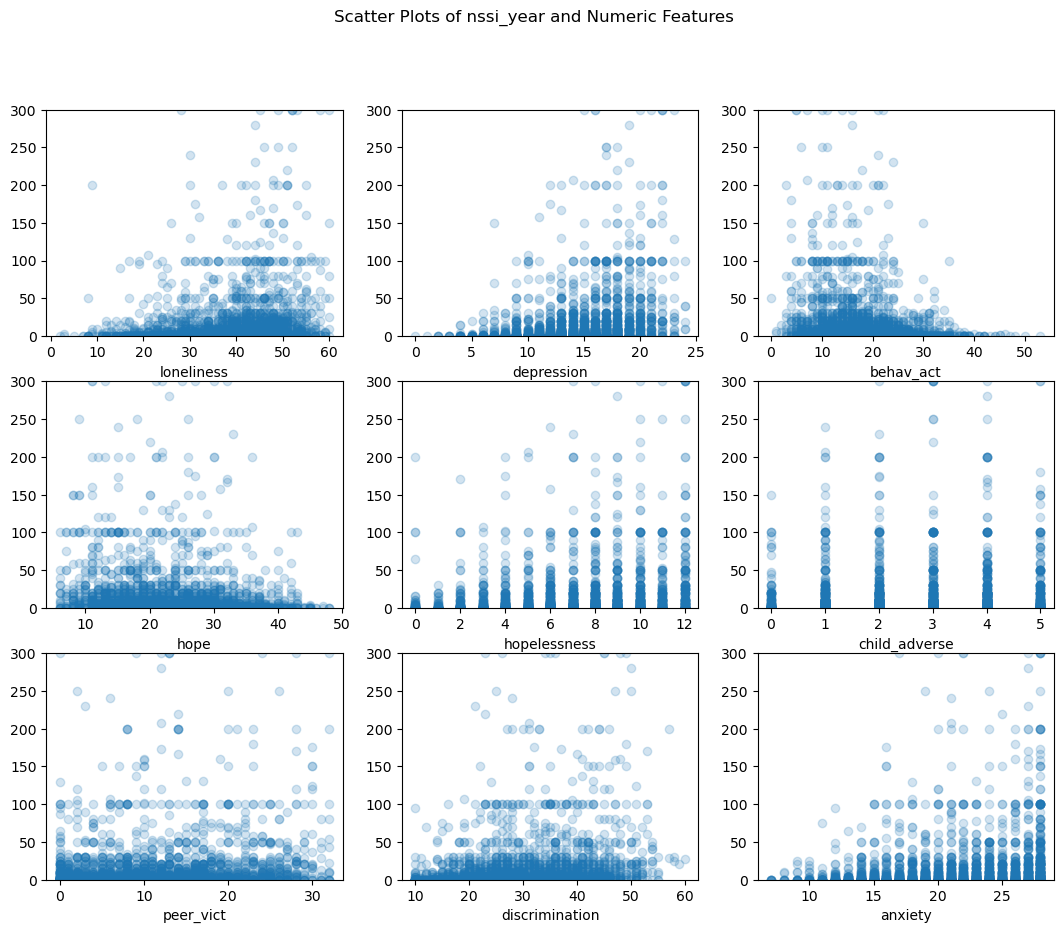

In [41]:
## visually examine numeric features for polynomial relationships
# nssi_year vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of nssi_year and Numeric Features')

axes[0,0].scatter(data['loneliness'], data['nssi_year'], alpha=0.2)
axes[0,0].set_xlabel('loneliness')
axes[0,0].set_ylim(0, 300)
axes[0,1].scatter(data['depression'], data['nssi_year'], alpha=0.2)
axes[0,1].set_xlabel('depression')
axes[0,1].set_ylim(0, 300)
axes[0,2].scatter(data['behav_act'], data['nssi_year'], alpha=0.2)
axes[0,2].set_xlabel('behav_act')
axes[0,2].set_ylim(0, 300)
axes[1,0].scatter(data['hope'], data['nssi_year'], alpha=0.2)
axes[1,0].set_xlabel('hope')
axes[1,0].set_ylim(0, 300)
axes[1,1].scatter(data['hopelessness'], data['nssi_year'], alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
axes[1,1].set_ylim(0, 300)
axes[1,2].scatter(data['child_adverse'], data['nssi_year'], alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
axes[1,2].set_ylim(0, 300)
axes[2,0].scatter(data['peer_vict'], data['nssi_year'], alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
axes[2,0].set_ylim(0, 300)
axes[2,1].scatter(data['discrimination'], data['nssi_year'], alpha=0.2)
axes[2,1].set_xlabel('discrimination')
axes[2,1].set_ylim(0, 300)
axes[2,2].scatter(data['anxiety'], data['nssi_year'], alpha=0.2)
axes[2,2].set_xlabel('anxiety')
axes[2,2].set_ylim(0, 300)

None

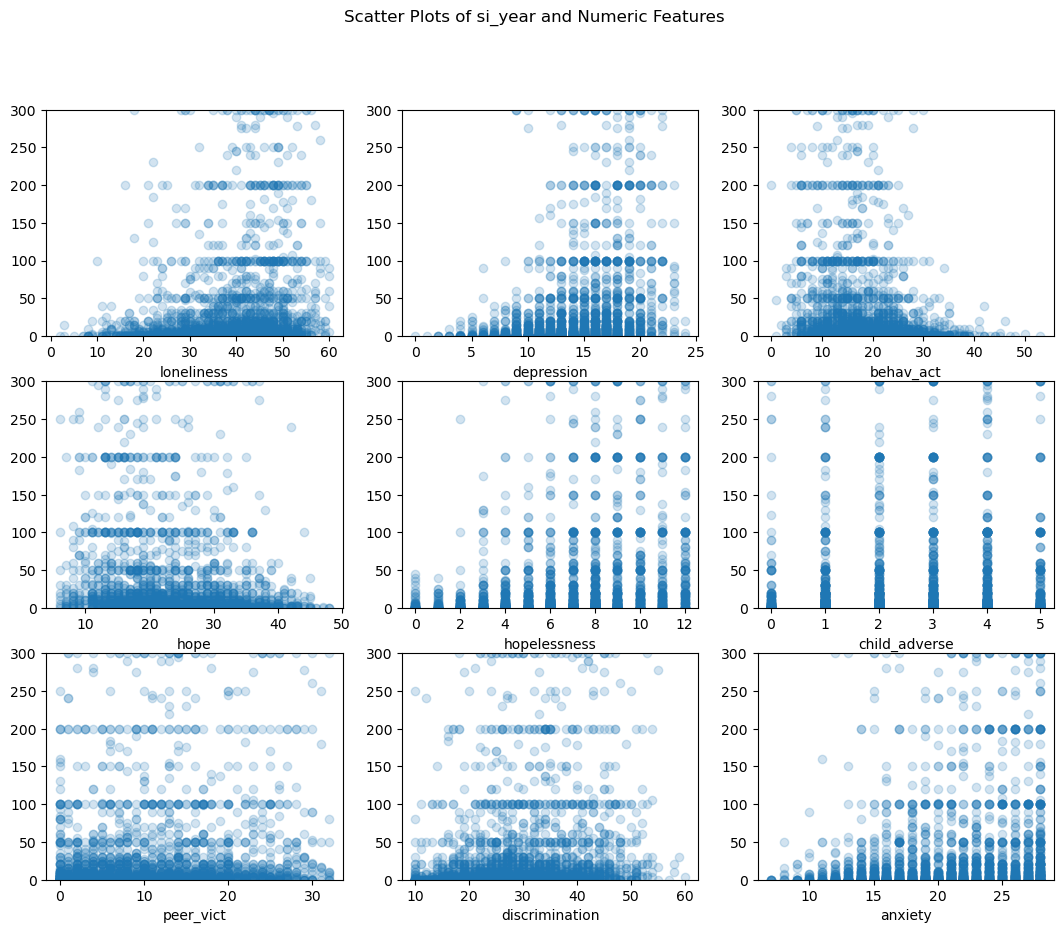

In [42]:
# si_year vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of si_year and Numeric Features')

axes[0,0].scatter(data['loneliness'], data['si_year'], alpha=0.2)
axes[0,0].set_xlabel('loneliness')
axes[0,0].set_ylim(0, 300)
axes[0,1].scatter(data['depression'], data['si_year'], alpha=0.2)
axes[0,1].set_xlabel('depression')
axes[0,1].set_ylim(0, 300)
axes[0,2].scatter(data['behav_act'], data['si_year'], alpha=0.2)
axes[0,2].set_xlabel('behav_act')
axes[0,2].set_ylim(0, 300)
axes[1,0].scatter(data['hope'], data['si_year'], alpha=0.2)
axes[1,0].set_xlabel('hope')
axes[1,0].set_ylim(0, 300)
axes[1,1].scatter(data['hopelessness'], data['si_year'], alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
axes[1,1].set_ylim(0, 300)
axes[1,2].scatter(data['child_adverse'], data['si_year'], alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
axes[1,2].set_ylim(0, 300)
axes[2,0].scatter(data['peer_vict'], data['si_year'], alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
axes[2,0].set_ylim(0, 300)
axes[2,1].scatter(data['discrimination'], data['si_year'], alpha=0.2)
axes[2,1].set_xlabel('discrimination')
axes[2,1].set_ylim(0, 300)
axes[2,2].scatter(data['anxiety'], data['si_year'], alpha=0.2)
axes[2,2].set_xlabel('anxiety')
axes[2,2].set_ylim(0, 300)

None

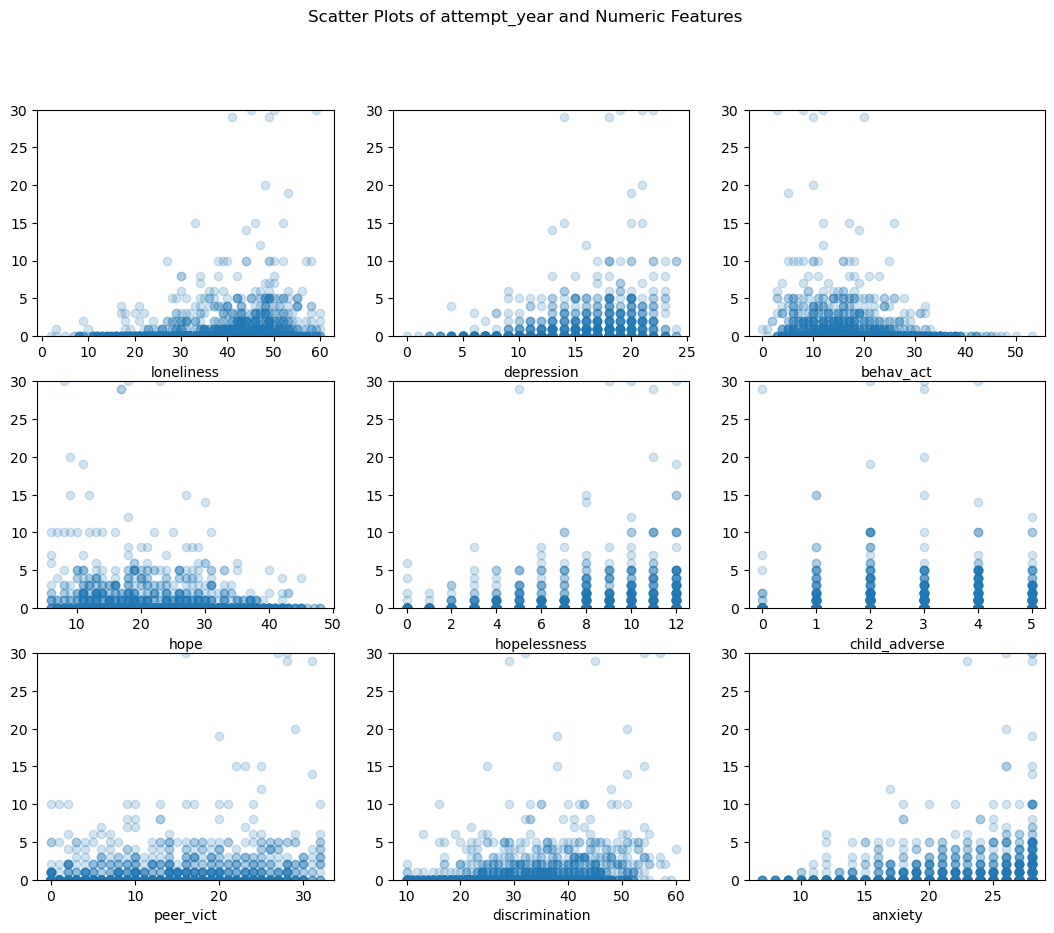

In [43]:
# attempt_year vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of attempt_year and Numeric Features')

axes[0,0].scatter(data['loneliness'], data['attempt_year'], alpha=0.2)
axes[0,0].set_xlabel('loneliness')
axes[0,0].set_ylim(0, 30)
axes[0,1].scatter(data['depression'], data['attempt_year'], alpha=0.2)
axes[0,1].set_xlabel('depression')
axes[0,1].set_ylim(0, 30)
axes[0,2].scatter(data['behav_act'], data['attempt_year'], alpha=0.2)
axes[0,2].set_xlabel('behav_act')
axes[0,2].set_ylim(0, 30)
axes[1,0].scatter(data['hope'], data['attempt_year'], alpha=0.2)
axes[1,0].set_xlabel('hope')
axes[1,0].set_ylim(0, 30)
axes[1,1].scatter(data['hopelessness'], data['attempt_year'], alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
axes[1,1].set_ylim(0, 30)
axes[1,2].scatter(data['child_adverse'], data['attempt_year'], alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
axes[1,2].set_ylim(0, 30)
axes[2,0].scatter(data['peer_vict'], data['attempt_year'], alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
axes[2,0].set_ylim(0, 30)
axes[2,1].scatter(data['discrimination'], data['attempt_year'], alpha=0.2)
axes[2,1].set_xlabel('discrimination')
axes[2,1].set_ylim(0, 30)
axes[2,2].scatter(data['anxiety'], data['attempt_year'], alpha=0.2)
axes[2,2].set_xlabel('anxiety')
axes[2,2].set_ylim(0, 30)

None

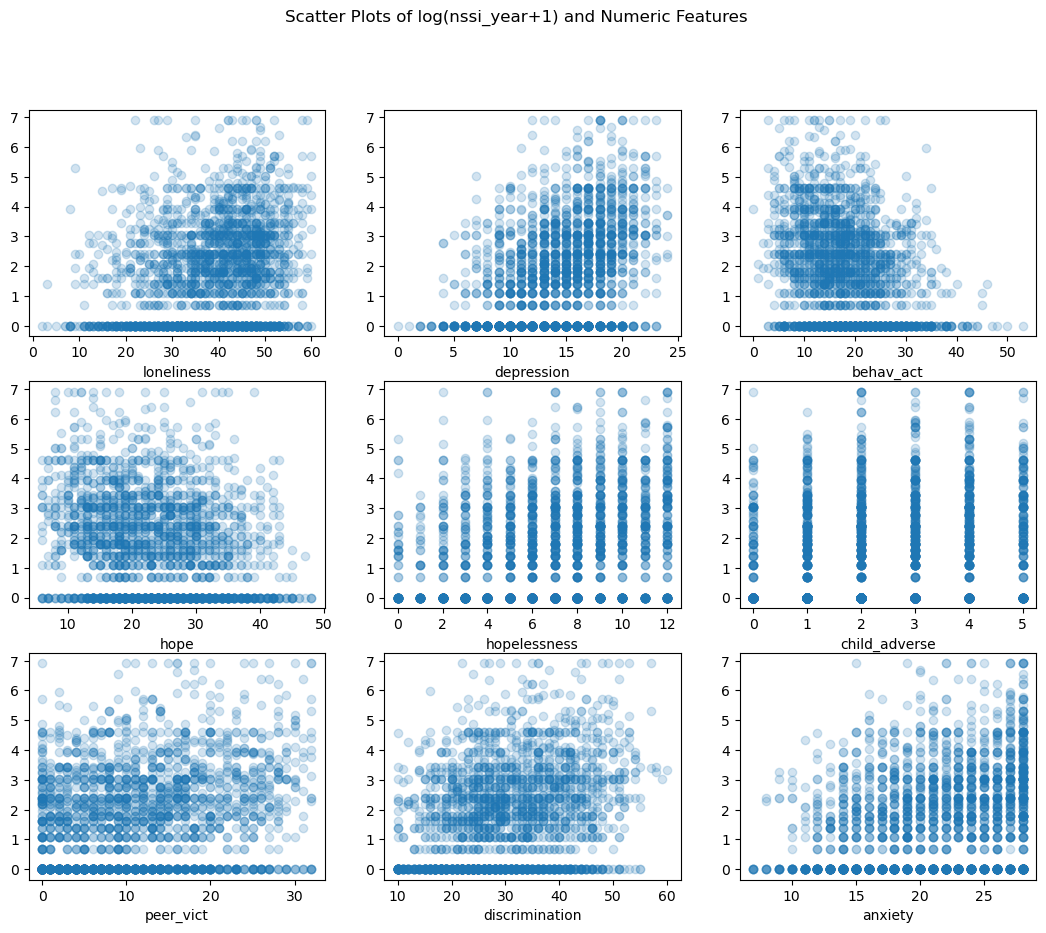

In [44]:
# log(nssi_year+1) vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of log(nssi_year+1) and Numeric Features')

axes[0,0].scatter(data['loneliness'], np.log(1+data['nssi_year']), alpha=0.2)
axes[0,0].set_xlabel('loneliness')
#axes[0,0].set_ylim(0, 300)
axes[0,1].scatter(data['depression'], np.log(1+data['nssi_year']), alpha=0.2)
axes[0,1].set_xlabel('depression')
#axes[0,1].set_ylim(0, 300)
axes[0,2].scatter(data['behav_act'], np.log(1+data['nssi_year']), alpha=0.2)
axes[0,2].set_xlabel('behav_act')
#axes[0,2].set_ylim(0, 300)
axes[1,0].scatter(data['hope'], np.log(1+data['nssi_year']), alpha=0.2)
axes[1,0].set_xlabel('hope')
#axes[1,0].set_ylim(0, 300)
axes[1,1].scatter(data['hopelessness'], np.log(1+data['nssi_year']), alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
#axes[1,1].set_ylim(0, 300)
axes[1,2].scatter(data['child_adverse'], np.log(1+data['nssi_year']), alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
#axes[1,2].set_ylim(0, 300)
axes[2,0].scatter(data['peer_vict'], np.log(1+data['nssi_year']), alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
#axes[2,0].set_ylim(0, 300)
axes[2,1].scatter(data['discrimination'], np.log(1+data['nssi_year']), alpha=0.2)
axes[2,1].set_xlabel('discrimination')
#axes[2,1].set_ylim(0, 300)
axes[2,2].scatter(data['anxiety'], np.log(1+data['nssi_year']), alpha=0.2)
axes[2,2].set_xlabel('anxiety')
#axes[2,2].set_ylim(0, 300)

None

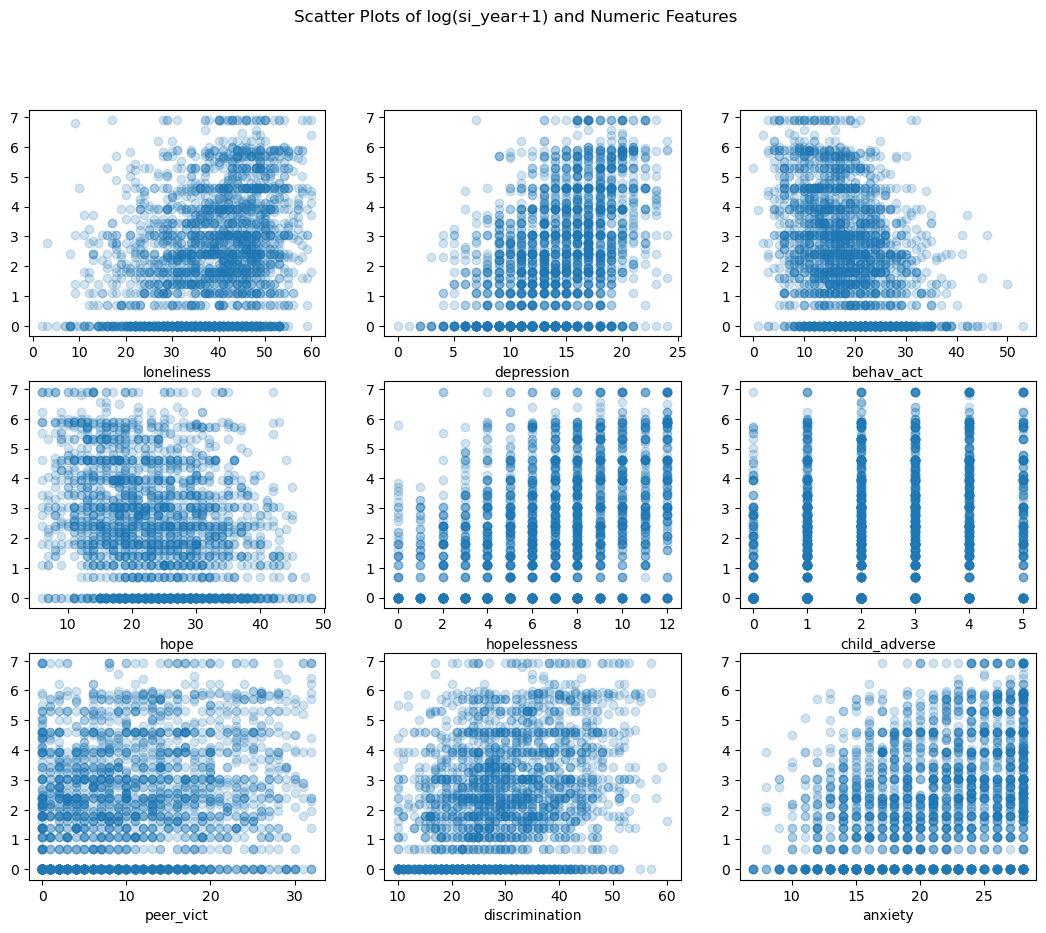

In [45]:
# log(si_year+1) vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of log(si_year+1) and Numeric Features')

axes[0,0].scatter(data['loneliness'], np.log(1+data['si_year']), alpha=0.2)
axes[0,0].set_xlabel('loneliness')
#axes[0,0].set_ylim(0, 300)
axes[0,1].scatter(data['depression'], np.log(1+data['si_year']), alpha=0.2)
axes[0,1].set_xlabel('depression')
#axes[0,1].set_ylim(0, 300)
axes[0,2].scatter(data['behav_act'], np.log(1+data['si_year']), alpha=0.2)
axes[0,2].set_xlabel('behav_act')
#axes[0,2].set_ylim(0, 300)
axes[1,0].scatter(data['hope'], np.log(1+data['si_year']), alpha=0.2)
axes[1,0].set_xlabel('hope')
#axes[1,0].set_ylim(0, 300)
axes[1,1].scatter(data['hopelessness'], np.log(1+data['si_year']), alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
#axes[1,1].set_ylim(0, 300)
axes[1,2].scatter(data['child_adverse'], np.log(1+data['si_year']), alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
#axes[1,2].set_ylim(0, 300)
axes[2,0].scatter(data['peer_vict'], np.log(1+data['si_year']), alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
#axes[2,0].set_ylim(0, 300)
axes[2,1].scatter(data['discrimination'], np.log(1+data['si_year']), alpha=0.2)
axes[2,1].set_xlabel('discrimination')
#axes[2,1].set_ylim(0, 300)
axes[2,2].scatter(data['anxiety'], np.log(1+data['si_year']), alpha=0.2)
axes[2,2].set_xlabel('anxiety')
#axes[2,2].set_ylim(0, 300)

None

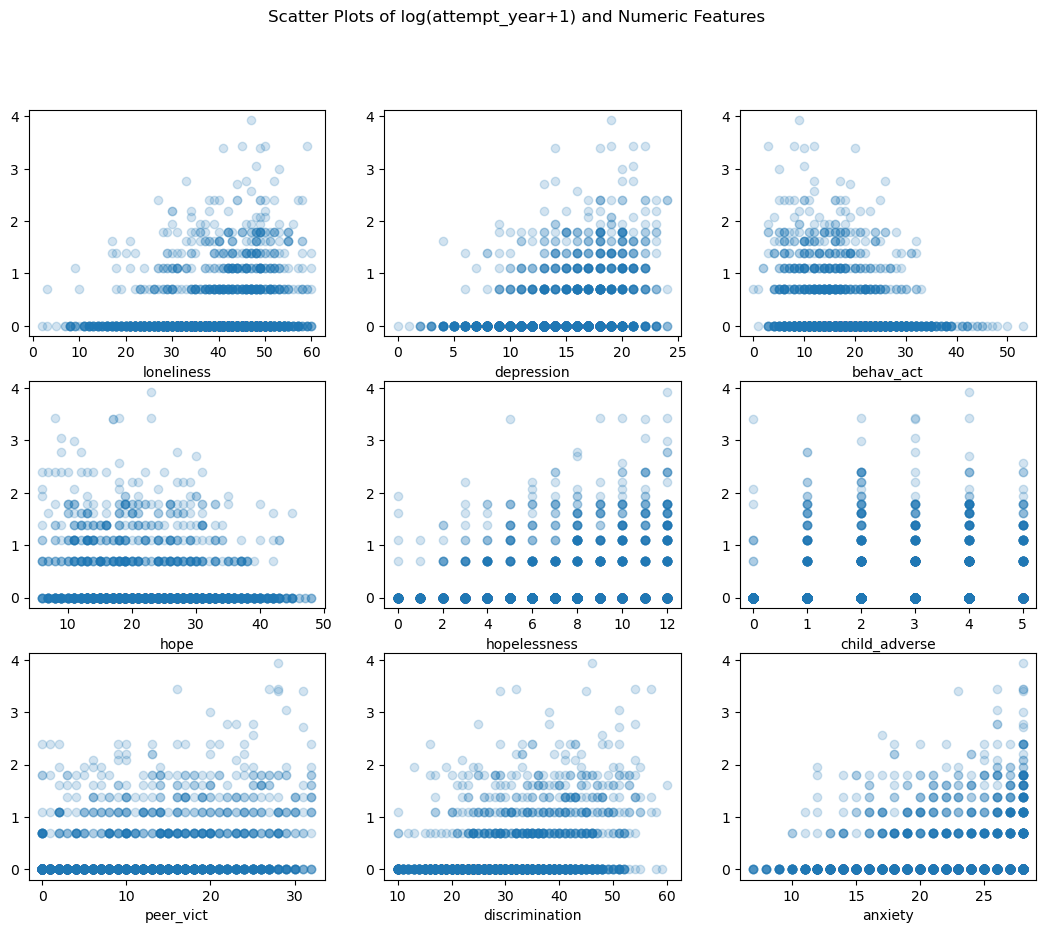

In [46]:
# log(attempt_year+1) vs numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Scatter Plots of log(attempt_year+1) and Numeric Features')

axes[0,0].scatter(data['loneliness'], np.log(1+data['attempt_year']), alpha=0.2)
axes[0,0].set_xlabel('loneliness')
#axes[0,0].set_ylim(0, 30)
axes[0,1].scatter(data['depression'], np.log(1+data['attempt_year']), alpha=0.2)
axes[0,1].set_xlabel('depression')
#axes[0,1].set_ylim(0, 30)
axes[0,2].scatter(data['behav_act'], np.log(1+data['attempt_year']), alpha=0.2)
axes[0,2].set_xlabel('behav_act')
#axes[0,2].set_ylim(0, 30)
axes[1,0].scatter(data['hope'], np.log(1+data['attempt_year']), alpha=0.2)
axes[1,0].set_xlabel('hope')
#axes[1,0].set_ylim(0, 30)
axes[1,1].scatter(data['hopelessness'], np.log(1+data['attempt_year']), alpha=0.2)
axes[1,1].set_xlabel('hopelessness')
#axes[1,1].set_ylim(0, 30)
axes[1,2].scatter(data['child_adverse'], np.log(1+data['attempt_year']), alpha=0.2)
axes[1,2].set_xlabel('child_adverse')
#axes[1,2].set_ylim(0, 30)
axes[2,0].scatter(data['peer_vict'], np.log(1+data['attempt_year']), alpha=0.2)
axes[2,0].set_xlabel('peer_vict')
#axes[2,0].set_ylim(0, 30)
axes[2,1].scatter(data['discrimination'], np.log(1+data['attempt_year']), alpha=0.2)
axes[2,1].set_xlabel('discrimination')
#axes[2,1].set_ylim(0, 30)
axes[2,2].scatter(data['anxiety'], np.log(1+data['attempt_year']), alpha=0.2)
axes[2,2].set_xlabel('anxiety')
#axes[2,2].set_ylim(0, 30)

None

It appears that many of the features may have relationships with the count targets that would be better captured as quadratic vs. linear, but not in models using a log-link function.

In [47]:
# save final dataframe to csv to bypass this preprocessing in the future 
data.to_csv('data_preproc.csv', index=False)

# Hypothesis 1

## nssi_bin

In [3]:
# define target
target = data['nssi_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [4]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.674 +/- 0.002
The mean precision with cross-validation is: 0.674 +/- 0.002
The mean recall with cross-validation is: 1.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


### Logistic regression model

In [5]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [6]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [7]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [8]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with accuracy of 0.759
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with accuracy of 0.743
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with accuracy of 0.744
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with accuracy of 0.750
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with accuracy of 0.766


0.1 appears best for C, but let's zoom in with a validation curve

In [9]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

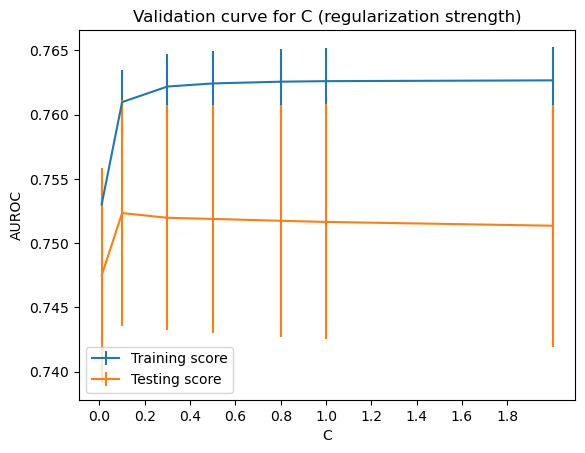

In [10]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

In [11]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

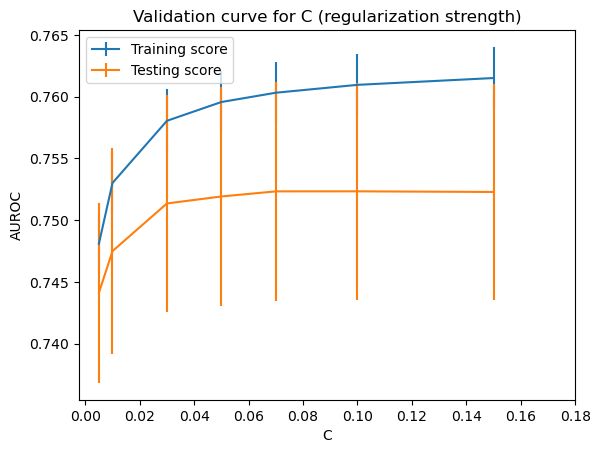

In [12]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.2, 0.02))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

0.1 appears sufficient for C.

In [13]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.690 +/- 0.030
The mean precision with cross-validation is: 0.822 +/- 0.025
The mean recall with cross-validation is: 0.690 +/- 0.034
The mean AUROC with cross-validation is: 0.750 +/- 0.033


### Random forest model

In [63]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [64]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [67]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [68]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.726
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.716
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.732
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.739
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.749


200 appears sufficient for n_estimators. Let's zoom in around max_leaf_nodes of 64 and max_features of 0.1

In [77]:
pipeline.set_params(randomforestclassifier__n_estimators=200)
pipeline.set_params(randomforestclassifier__max_features=0.1)

# first generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

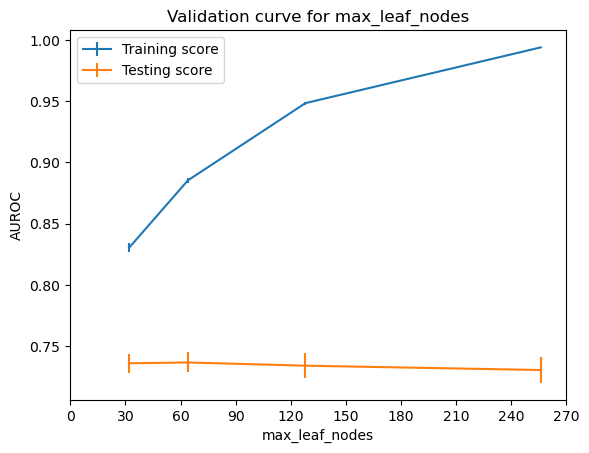

In [78]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

In [79]:
pipeline.set_params(randomforestclassifier__max_features=0.2)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

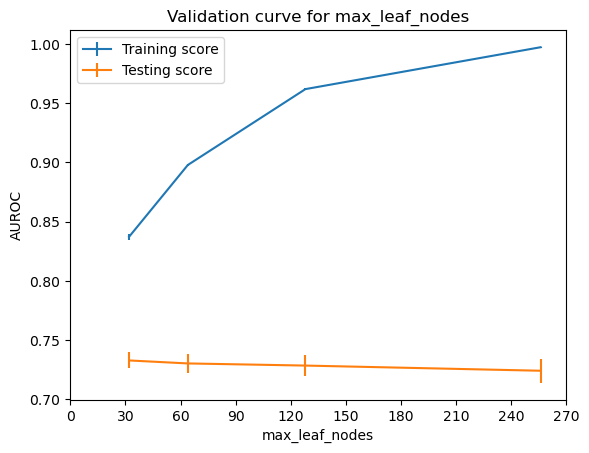

In [80]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

In [81]:
pipeline.set_params(randomforestclassifier__max_features=0.3)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

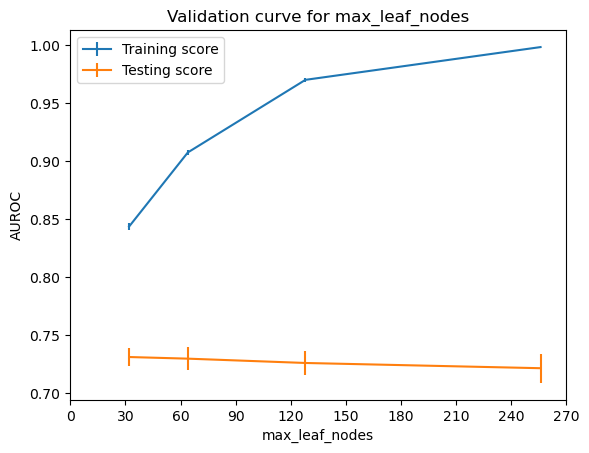

In [82]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 64 and max_features of 0.1 appears sufficient.

In [83]:
pipeline.set_params(randomforestclassifier__max_features=0.1)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.699 +/- 0.032
The mean precision with cross-validation is: 0.793 +/- 0.025
The mean recall with cross-validation is: 0.750 +/- 0.034
The mean AUROC with cross-validation is: 0.738 +/- 0.034


### Gradient boosting decision trees model

In [84]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [85]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [86]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.738
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.727
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.725
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.714
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.755


Let's examine max_leaf_nodes while holding max_iter at 50.

In [88]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

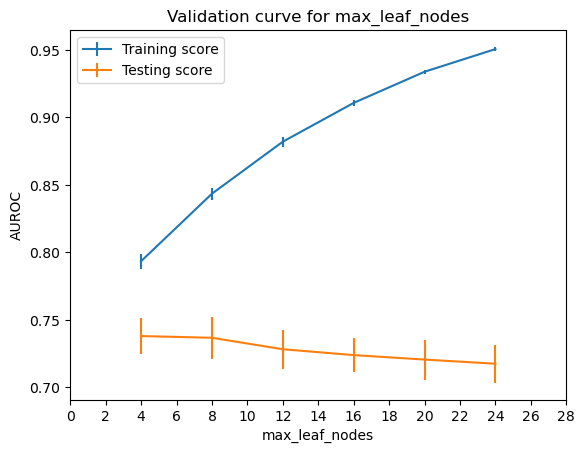

In [90]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [91]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.686 +/- 0.030
The mean precision with cross-validation is: 0.810 +/- 0.025
The mean recall with cross-validation is: 0.699 +/- 0.034
The mean AUROC with cross-validation is: 0.740 +/- 0.033


### Model comparison

In [94]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.750 +/- 0.033

Random forest model
AUROC: 0.738 +/- 0.034

Gradient boosting decision trees model
AUROC: 0.740 +/- 0.033


((0.7103763137140116, 0.2896180303119844, 5.65597400403739e-06), <Figure size 640x480 with 1 Axes>)


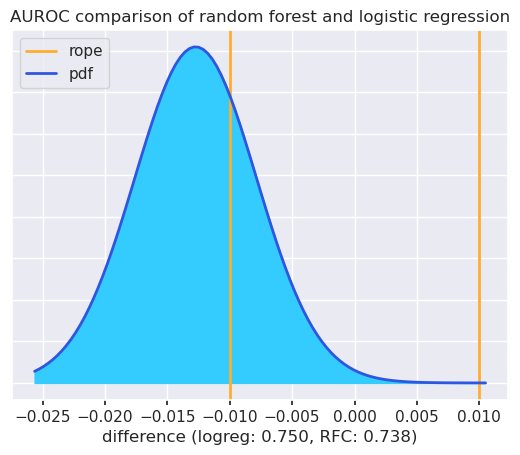

In [95]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

((0.5393425784913718, 0.4606574002183843, 2.129024390118417e-08), <Figure size 640x480 with 1 Axes>)


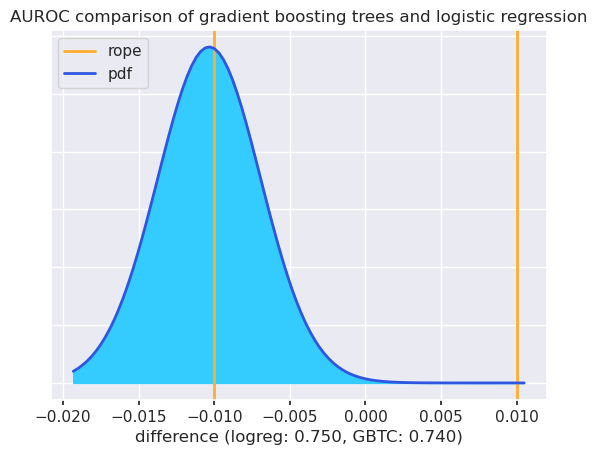

In [96]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

((2.910440805477951e-41, 0.0, 1.0), <Figure size 640x480 with 1 Axes>)


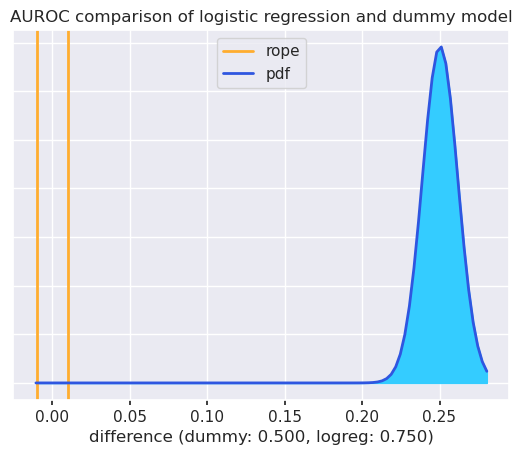

In [14]:
# statistical test comparing performance
logreg_vs_dummy = two_on_single(x=dummy_results["test_roc_auc"], y=logreg_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('dummy', 'logreg'), plot=True)
plt.title("AUROC comparison of logistic regression and dummy model")
print(logreg_vs_dummy)

## si_bin

In [15]:
# define target
target = data['si_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [16]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.812 +/- 0.001
The mean precision with cross-validation is: 0.812 +/- 0.001
The mean recall with cross-validation is: 1.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


### Logistic regression model

In [17]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [18]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [19]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [20]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with accuracy of 0.716
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with accuracy of 0.759
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with accuracy of 0.782
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with accuracy of 0.749
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with accuracy of 0.749


0.1 appears best for C, but let's zoom in with a validation curve

In [21]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

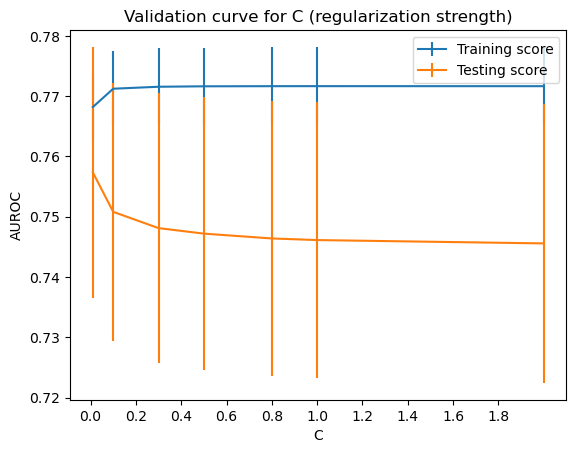

In [22]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

A value less than 0.1 for C may be better.

In [23]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.09]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

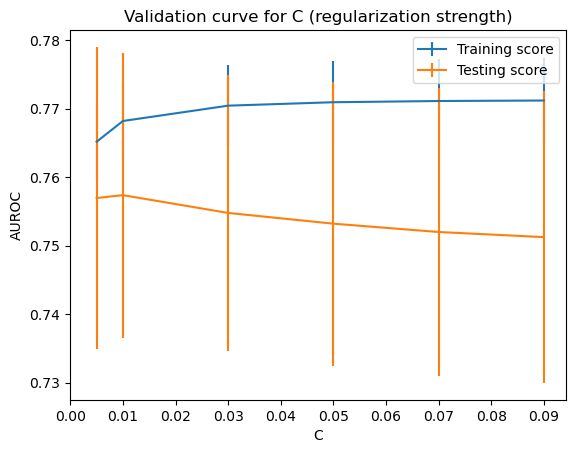

In [24]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.1, 0.01))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

C of 0.01 appears best.

In [25]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.707 +/- 0.026
The mean precision with cross-validation is: 0.912 +/- 0.020
The mean recall with cross-validation is: 0.708 +/- 0.030
The mean AUROC with cross-validation is: 0.759 +/- 0.040


### Random forest model

In [14]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [15]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [16]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [17]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.705
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.751
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.2}
with accuracy of 0.810
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.749
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.795


We'll try a more focused search around these results.

In [18]:
pipeline.set_params(randomforestclassifier__n_estimators=200)

param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [19]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 128}
with accuracy of 0.713
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__max_leaf_nodes': 64}
with accuracy of 0.755
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__max_leaf_nodes': 64}
with accuracy of 0.811
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 128}
with accuracy of 0.752
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 64}
with accuracy of 0.798


In [20]:
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)

param_grid =  {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [21]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.705
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__n_estimators': 400}
with accuracy of 0.754
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 100}
with accuracy of 0.810
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.4, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.745
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.795


In [22]:
pipeline.set_params(randomforestclassifier__max_features=0.2)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__n_estimators', 
    param_range=n_estimators_values, scoring='roc_auc', n_jobs=2)

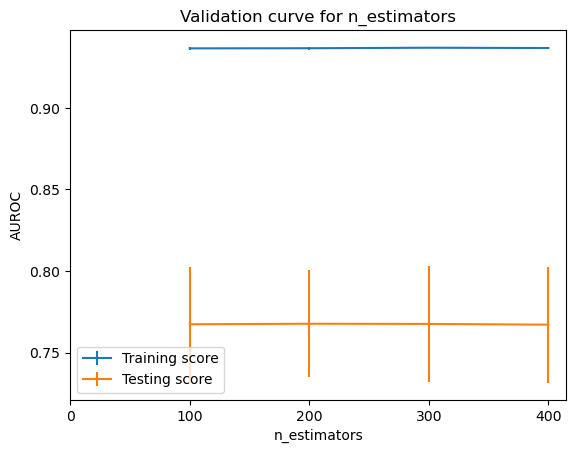

In [23]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 500, 100))
plt.xlabel("n_estimators")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for n_estimators")

In [24]:
pipeline.set_params(randomforestclassifier__n_estimators=100)

# generate validation curve for max_features
max_features_values = [0.1, 0.2, 0.3, 0.4]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_features', 
    param_range=max_features_values, scoring='roc_auc', n_jobs=2)

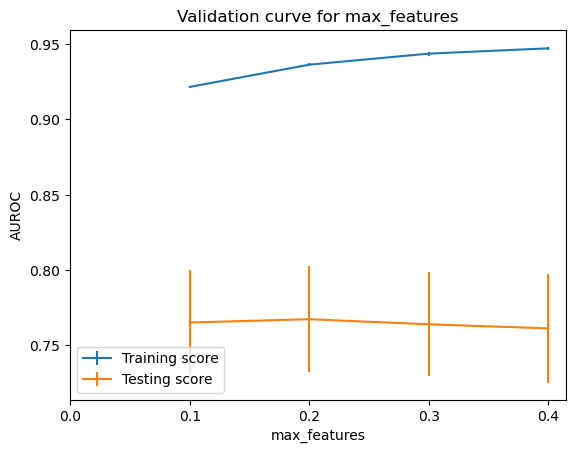

In [25]:
# plot validation curve for max_features
plt.errorbar(max_features_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_features_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.5, 0.1))
plt.xlabel("max_features")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_features")

We will proceed with max_leaf_nodes of 64, n_estimators of 100, and max_features of 0.2.

In [26]:
pipeline.set_params(randomforestclassifier__max_features=0.2)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)
pipeline.set_params(randomforestclassifier__n_estimators=100)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.783 +/- 0.023
The mean precision with cross-validation is: 0.887 +/- 0.017
The mean recall with cross-validation is: 0.840 +/- 0.028
The mean AUROC with cross-validation is: 0.766 +/- 0.040


### Gradient boosting decision trees model

In [27]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [28]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [29]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.719
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.767
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.806
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 150, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.739
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.759


Let's examine max_leaf_nodes while holding max_iter at 50.

In [30]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

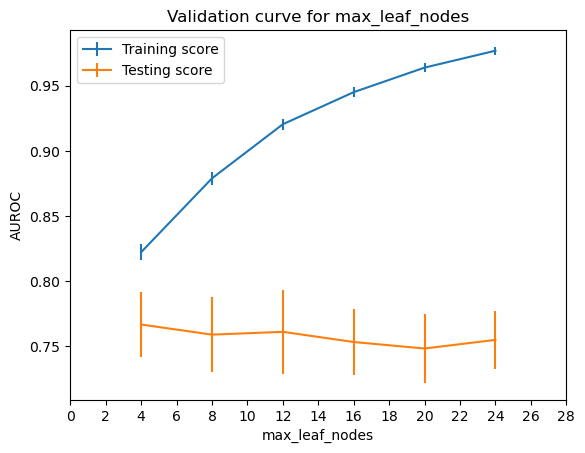

In [31]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [32]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.730 +/- 0.024
The mean precision with cross-validation is: 0.906 +/- 0.019
The mean recall with cross-validation is: 0.746 +/- 0.030
The mean AUROC with cross-validation is: 0.768 +/- 0.037


### Model comparison

In [33]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.759 +/- 0.040

Random forest model
AUROC: 0.766 +/- 0.040

Gradient boosting decision trees model
AUROC: 0.768 +/- 0.037


((0.0019857410330105436, 0.7083575491607347, 0.2896567098062548), <Figure size 640x480 with 1 Axes>)


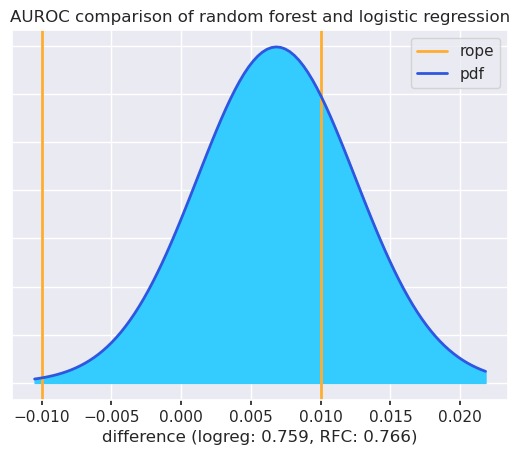

In [34]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

((0.001616869642323951, 0.5966548474983351, 0.4017282828593409), <Figure size 640x480 with 1 Axes>)


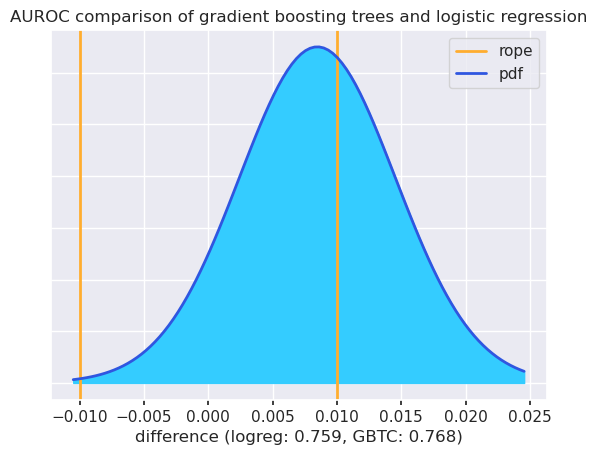

In [35]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

((3.435355192695807e-35, 0.0, 1.0), <Figure size 640x480 with 1 Axes>)


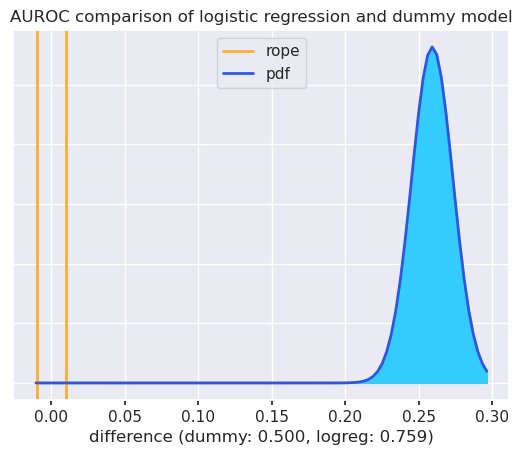

In [26]:
# statistical test comparing performance
logreg_vs_dummy = two_on_single(x=dummy_results["test_roc_auc"], y=logreg_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('dummy', 'logreg'), plot=True)
plt.title("AUROC comparison of logistic regression and dummy model")
print(logreg_vs_dummy)

## attempt_bin

In [27]:
# define target
target = data['attempt_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [28]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precis

The mean accuracy with cross-validation is: 0.681 +/- 0.002
The mean precision with cross-validation is: 0.000 +/- 0.000
The mean recall with cross-validation is: 0.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precis

Warning is expected. It means precision can't really be defined 
because the positive class is never predicted (because it is the minority class in this case).

### Logistic regression model

In [29]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [30]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [31]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [32]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with accuracy of 0.738
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with accuracy of 0.772
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with accuracy of 0.803
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with accuracy of 0.752
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with accuracy of 0.737


0.1 appears best for C, but let's zoom in with a validation curve

In [33]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

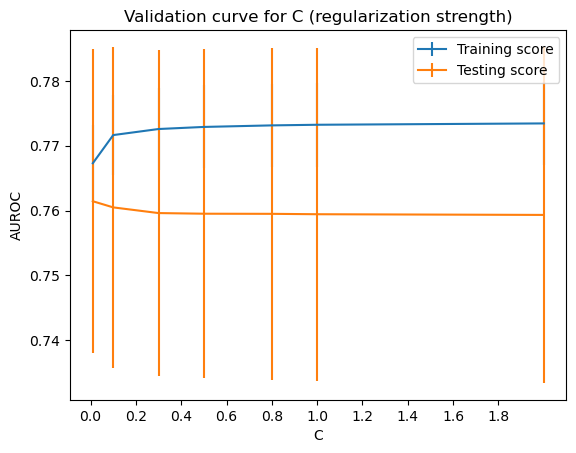

In [34]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

A value less than 0.1 for C may be better.

In [35]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.09]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

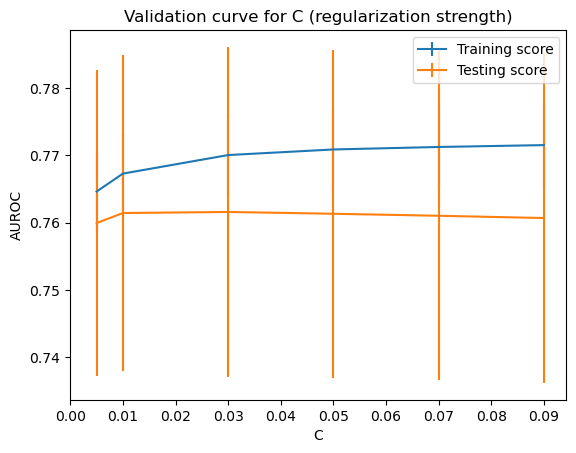

In [36]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.1, 0.01))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

C of 0.01 appears best.

In [37]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.696 +/- 0.024
The mean precision with cross-validation is: 0.519 +/- 0.029
The mean recall with cross-validation is: 0.705 +/- 0.045
The mean AUROC with cross-validation is: 0.762 +/- 0.028


### Random forest model

In [15]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [16]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [17]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [18]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.2}
with accuracy of 0.724
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.777
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.801
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.749
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__max_features': 0.4}
with accuracy of 0.733


We'll try a more focused search around these results.

In [19]:
pipeline.set_params(randomforestclassifier__n_estimators=200)

param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [20]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 128}
with accuracy of 0.727
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 32}
with accuracy of 0.776
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 64}
with accuracy of 0.801
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 32}
with accuracy of 0.748
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.4, 'randomforestclassifier__max_leaf_nodes': 32}
with accuracy of 0.733


In [21]:
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)

param_grid =  {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [22]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.728
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 400}
with accuracy of 0.775
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 200}
with accuracy of 0.801
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 200}
with accuracy of 0.746
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.738


In [23]:
pipeline.set_params(randomforestclassifier__max_features=0.3)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__n_estimators', 
    param_range=n_estimators_values, scoring='roc_auc', n_jobs=2)

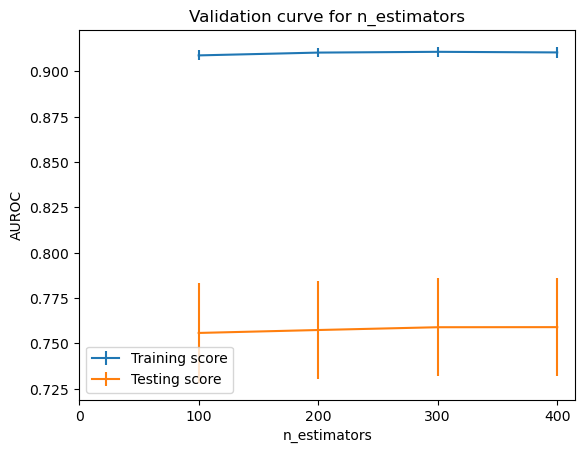

In [24]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 500, 100))
plt.xlabel("n_estimators")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for n_estimators")

In [25]:
pipeline.set_params(randomforestclassifier__n_estimators=400)

# generate validation curve for max_features
max_features_values = [0.1, 0.2, 0.3, 0.4]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_features', 
    param_range=max_features_values, scoring='roc_auc', n_jobs=2)

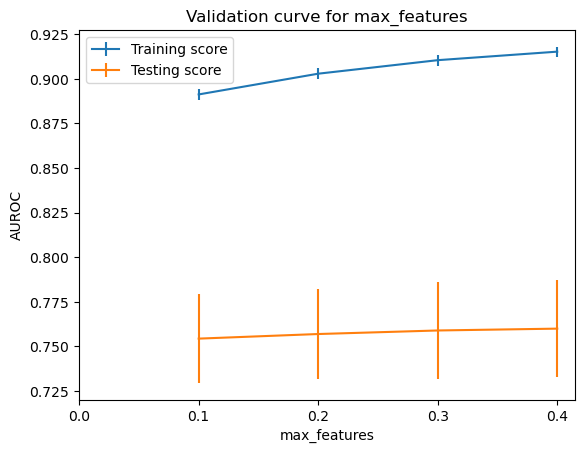

In [26]:
# plot validation curve for max_features
plt.errorbar(max_features_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_features_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.5, 0.1))
plt.xlabel("max_features")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_features")

In [27]:
pipeline.set_params(randomforestclassifier__max_features=0.4)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [16, 32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

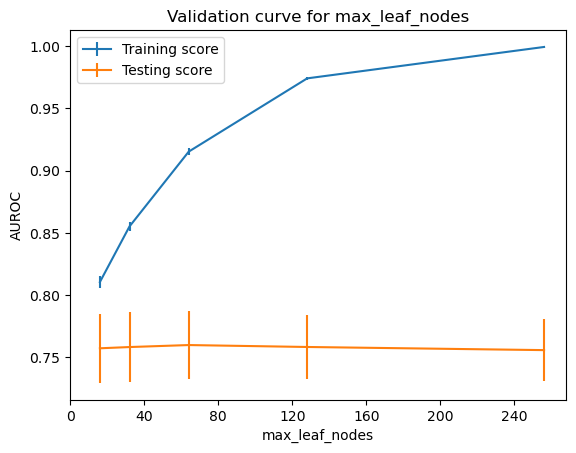

In [28]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 280, 40))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

We will proceed with max_leaf_nodes of 64, n_estimators of 400, and max_features of 0.4.

In [29]:
pipeline.set_params(randomforestclassifier__max_features=0.4)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)
pipeline.set_params(randomforestclassifier__n_estimators=400)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.715 +/- 0.022
The mean precision with cross-validation is: 0.550 +/- 0.034
The mean recall with cross-validation is: 0.605 +/- 0.048
The mean AUROC with cross-validation is: 0.755 +/- 0.027


### Gradient boosting decision trees model

In [30]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [31]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [32]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.736
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.763
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.806
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.736
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.734


Let's examine max_leaf_nodes while holding max_iter at 50.

In [33]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

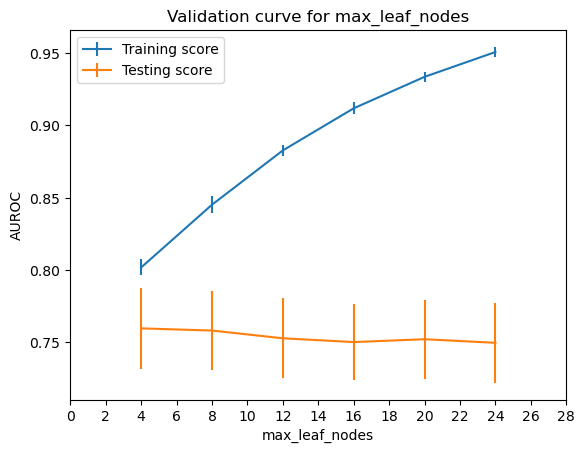

In [34]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [35]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.695 +/- 0.027
The mean precision with cross-validation is: 0.518 +/- 0.033
The mean recall with cross-validation is: 0.685 +/- 0.047
The mean AUROC with cross-validation is: 0.759 +/- 0.027


### Model comparison

In [36]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.762 +/- 0.028

Random forest model
AUROC: 0.755 +/- 0.027

Gradient boosting decision trees model
AUROC: 0.759 +/- 0.027


((0.16427163848488274, 0.835728248277247, 1.1323787019179576e-07), <Figure size 640x480 with 1 Axes>)


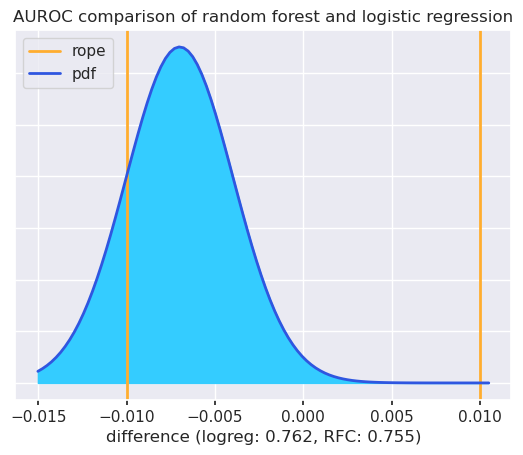

In [37]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

((0.0071577781159283035, 0.9927709982362449, 7.122364782674584e-05), <Figure size 640x480 with 1 Axes>)


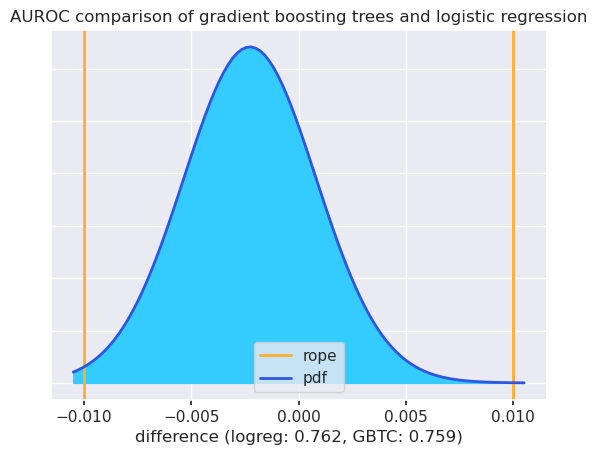

In [38]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

((3.639140144717685e-49, 0.0, 1.0), <Figure size 640x480 with 1 Axes>)


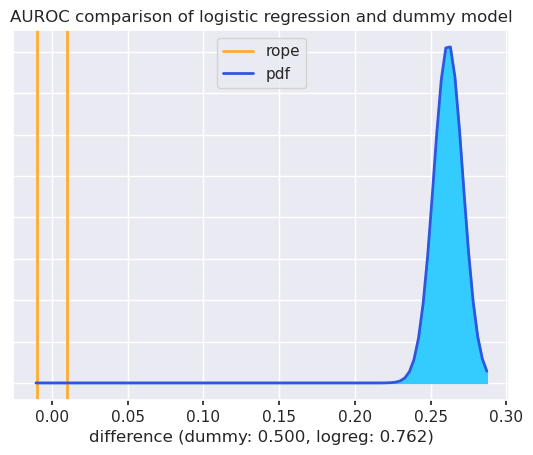

In [38]:
# statistical test comparing performance
logreg_vs_dummy = two_on_single(x=dummy_results["test_roc_auc"], y=logreg_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('dummy', 'logreg'), plot=True)
plt.title("AUROC comparison of logistic regression and dummy model")
print(logreg_vs_dummy)

## nssi_year

In [60]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# confirm new size of data set
nssi_year_data.shape

(2401, 18)

In [61]:
# define target
target = nssi_year_data['nssi_year']

# define features
features = nssi_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [62]:
# always predict most frequent target class
dummy_results = cross_validate(DummyRegressor(strategy='median'), features, target, 
                               scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                               cv=cross_val)
print('The mean RMSE with cross-validation is: ' 
      f'{-dummy_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {dummy_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 94.948 +/- 26.975
The mean Poisson deviance with cross-validation is: 153.502 +/- 54.303


In [6]:
# compute target predictions for later plots
model = DummyRegressor(strategy='median')
model.fit(features, target)
target_predicted_dummy = model.predict(features)

### Poisson regression model

In [63]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [64]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [44]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'poissonregressor__alpha': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [45]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'poissonregressor__alpha': 5}
with Poisson deviance of 72.364
Best hyperparameters for split #2:
{'poissonregressor__alpha': 5}
with Poisson deviance of 102.558
Best hyperparameters for split #3:
{'poissonregressor__alpha': 5}
with Poisson deviance of 70.711
Best hyperparameters for split #4:
{'poissonregressor__alpha': 5}
with Poisson deviance of 99.379
Best hyperparameters for split #5:
{'poissonregressor__alpha': 5}
with Poisson deviance of 45.719


alpha of 5 appears best.

In [65]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 89.900 +/- 24.933
The mean Poisson deviance with cross-validation is: 76.709 +/- 22.437


In [10]:
# compute target predictions for later plots
target_predicted_poisson = cross_val_predict(pipeline, features, target, cv=10)

### Random forest model

In [11]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [12]:
# define algorithm
rfr = RandomForestRegressor(criterion='poisson', n_jobs=2, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfr)

In [17]:
# hyperparameter values to try
param_grid =  {
    'randomforestregressor__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestregressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestregressor__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [18]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestregressor__n_estimators': 200, 'randomforestregressor__max_leaf_nodes': 64, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 71.040
Best hyperparameters for split #2:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 108.805
Best hyperparameters for split #3:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 1024, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 79.799
Best hyperparameters for split #4:
{'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 107.475
Best hyperparameters for split #5:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.1}
with Poisson deviance o

We'll try a more focused search around these results.

In [19]:
pipeline.set_params(randomforestregressor__max_features=0.1)
pipeline.set_params(randomforestregressor__n_estimators=600)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [16, 32, 64, 128, 256, 512, 1024]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

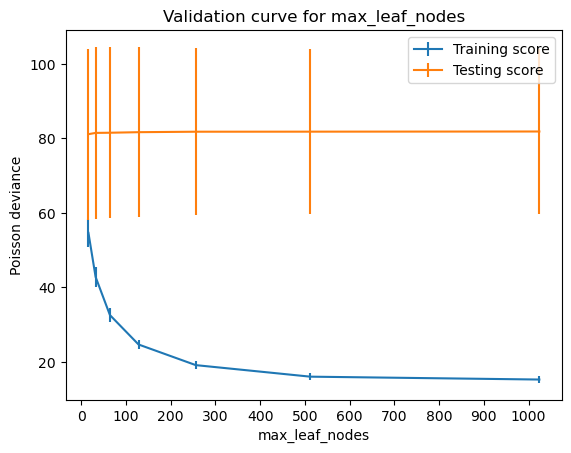

In [20]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 1100, 100))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [21]:
# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [8, 16, 32, 64, 128]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

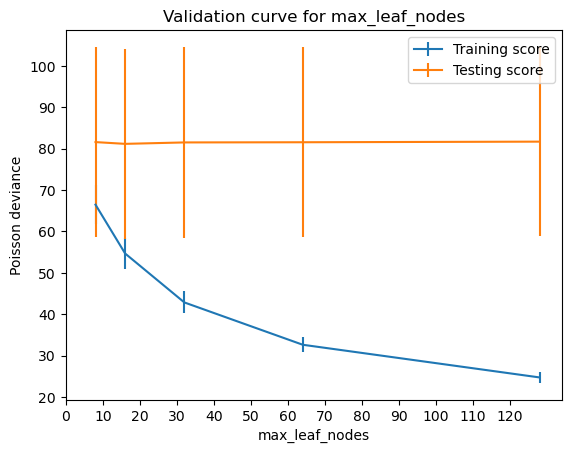

In [22]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 130, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [23]:
pipeline.set_params(randomforestregressor__max_leaf_nodes=16)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400, 500, 600, 700]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__n_estimators', 
    param_range=n_estimators_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

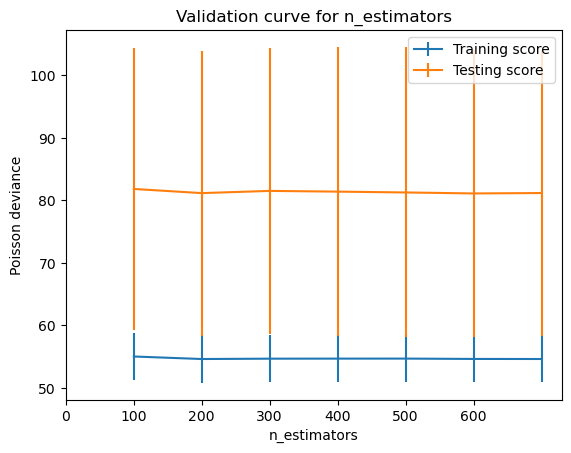

In [24]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 700, 100))
plt.xlabel("n_estimators")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for n_estimators")

We will proceed with max_leaf_nodes of 16, n_estimators of 600, and max_features of 0.1.

In [13]:
pipeline.set_params(randomforestregressor__max_features=0.1)
pipeline.set_params(randomforestregressor__max_leaf_nodes=16)
pipeline.set_params(randomforestregressor__n_estimators=600)

# get results from tuned model
rfr_results = cross_validate(pipeline, features, target, 
                             scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'],
                             cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-rfr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {rfr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 90.454 +/- 25.700
The mean Poisson deviance with cross-validation is: 79.922 +/- 23.484


In [14]:
# compute target predictions for later plots
target_predicted_rfr = cross_val_predict(pipeline, features, target, cv=10)

### Gradient boosting decision trees model

In [15]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [16]:
# define algorithm
hgbr = HistGradientBoostingRegressor(loss='poisson', random_state=0, 
                                     categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbr)

In [34]:
## hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'histgradientboostingregressor__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingregressor__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [35]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 79.004
Best hyperparameters for split #2:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 16}
with Poisson deviance of 111.781
Best hyperparameters for split #3:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 80.207
Best hyperparameters for split #4:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 109.205
Best hyperparameters for split #5:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 47.318


Let's examine max_leaf_nodes while holding max_iter at 50.

In [36]:
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 16, 32, 48]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

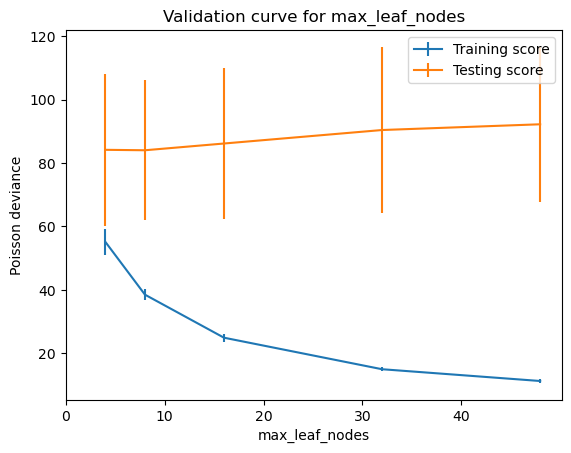

In [37]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 50, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 8 appears sufficient.

In [17]:
pipeline.set_params(histgradientboostingregressor__max_leaf_nodes=8)
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# get results from tuned model
hgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-hgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {hgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 92.869 +/- 24.119
The mean Poisson deviance with cross-validation is: 82.874 +/- 24.614


In [18]:
# compute target predictions for later plots
target_predicted_hgbr = cross_val_predict(pipeline, features, target, cv=10)

### Model comparison

In [19]:
print('Dummy baseline model')
print('Poisson deviance: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print('Poisson model')
print('Poisson deviance: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Random forest model')
print('Poisson deviance: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Gradient boosting decision trees model')
print('Poisson deviance: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()

Dummy baseline model
Poisson deviance: 153.502 +/- 54.303

Poisson model
Poisson deviance: 76.709 +/- 22.437


Random forest model
Poisson deviance: 79.922 +/- 23.484


Gradient boosting decision trees model
Poisson deviance: 82.874 +/- 24.614



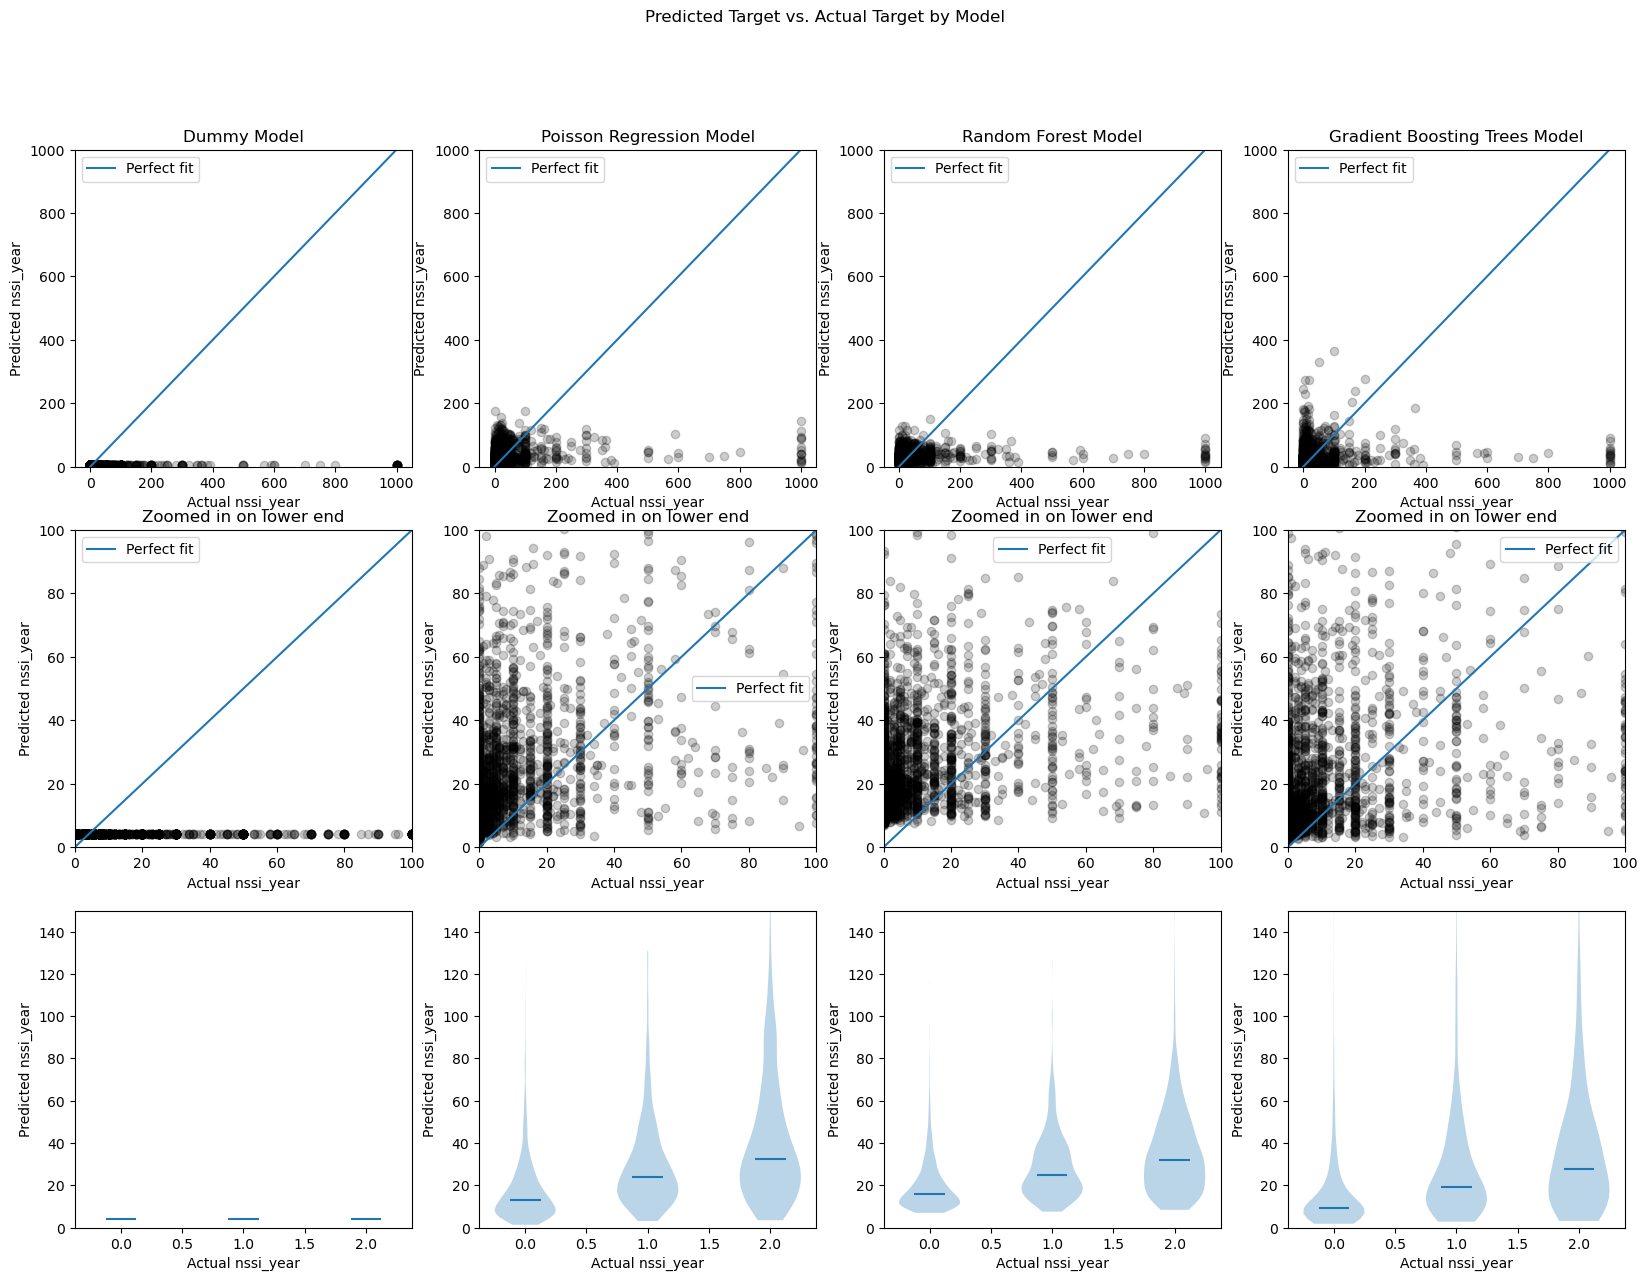

In [41]:
# plot predicted target vs. actual target
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
fig.suptitle('Predicted Target vs. Actual Target by Model')

target_quart = pd.qcut(target, 4, labels=False, duplicates='drop')

axes[0,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[0,0].set_ylim(min(target), max(target))
axes[0,0].set_xlabel("Actual nssi_year")
axes[0,0].set_ylabel("Predicted nssi_year")
axes[0,0].axline((0, 0), slope=1, label="Perfect fit")
axes[0,0].legend()
axes[0,0].set_title("Dummy Model")

axes[1,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[1,0].set_xlim(min(target), 100)
axes[1,0].set_ylim(min(target), 100)
axes[1,0].set_xlabel("Actual nssi_year")
axes[1,0].set_ylabel("Predicted nssi_year")
axes[1,0].axline((0, 0), slope=1, label="Perfect fit")
axes[1,0].legend()
axes[1,0].set_title("Zoomed in on lower end")

quart0 = target_predicted_dummy[target_quart == 0]
quart1 = target_predicted_dummy[target_quart == 1]
quart2 = target_predicted_dummy[target_quart == 2]
axes[2,0].violinplot([quart0, quart1, quart2], positions=[0,1,2], showextrema=False, showmedians=True)
axes[2,0].set_xlabel("Actual nssi_year")
axes[2,0].set_ylabel("Predicted nssi_year")
axes[2,0].set_ylim(0, 150)

axes[0,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[0,1].set_ylim(min(target), max(target))
axes[0,1].set_xlabel("Actual nssi_year")
axes[0,1].set_ylabel("Predicted nssi_year")
axes[0,1].axline((0, 0), slope=1, label="Perfect fit")
axes[0,1].legend()
axes[0,1].set_title("Poisson Regression Model")

axes[1,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[1,1].set_xlim(min(target), 100)
axes[1,1].set_ylim(min(target), 100)
axes[1,1].set_xlabel("Actual nssi_year")
axes[1,1].set_ylabel("Predicted nssi_year")
axes[1,1].axline((0, 0), slope=1, label="Perfect fit")
axes[1,1].legend()
axes[1,1].set_title("Zoomed in on lower end")

quart0 = target_predicted_poisson[target_quart == 0]
quart1 = target_predicted_poisson[target_quart == 1]
quart2 = target_predicted_poisson[target_quart == 2]
axes[2,1].violinplot([quart0, quart1, quart2], positions=[0,1,2], showextrema=False, showmedians=True)
axes[2,1].set_xlabel("Actual nssi_year")
axes[2,1].set_ylabel("Predicted nssi_year")
axes[2,1].set_ylim(0, 150)

axes[0,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[0,2].set_ylim(min(target), max(target))
axes[0,2].set_xlabel("Actual nssi_year")
axes[0,2].set_ylabel("Predicted nssi_year")
axes[0,2].axline((0, 0), slope=1, label="Perfect fit")
axes[0,2].legend()
axes[0,2].set_title("Random Forest Model")

axes[1,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[1,2].set_xlim(min(target), 100)
axes[1,2].set_ylim(min(target), 100)
axes[1,2].set_xlabel("Actual nssi_year")
axes[1,2].set_ylabel("Predicted nssi_year")
axes[1,2].axline((0, 0), slope=1, label="Perfect fit")
axes[1,2].legend()
axes[1,2].set_title("Zoomed in on lower end")

quart0 = target_predicted_rfr[target_quart == 0]
quart1 = target_predicted_rfr[target_quart == 1]
quart2 = target_predicted_rfr[target_quart == 2]
axes[2,2].violinplot([quart0, quart1, quart2], positions=[0,1,2], showextrema=False, showmedians=True)
axes[2,2].set_xlabel("Actual nssi_year")
axes[2,2].set_ylabel("Predicted nssi_year")
axes[2,2].set_ylim(0, 150)

axes[0,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[0,3].set_ylim(min(target), max(target))
axes[0,3].set_xlabel("Actual nssi_year")
axes[0,3].set_ylabel("Predicted nssi_year")
axes[0,3].axline((0, 0), slope=1, label="Perfect fit")
axes[0,3].legend()
axes[0,3].set_title("Gradient Boosting Trees Model")

axes[1,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[1,3].set_xlim(min(target), 100)
axes[1,3].set_ylim(min(target), 100)
axes[1,3].set_xlabel("Actual nssi_year")
axes[1,3].set_ylabel("Predicted nssi_year")
axes[1,3].axline((0, 0), slope=1, label="Perfect fit")
axes[1,3].legend()
axes[1,3].set_title("Zoomed in on lower end")

quart0 = target_predicted_hgbr[target_quart == 0]
quart1 = target_predicted_hgbr[target_quart == 1]
quart2 = target_predicted_hgbr[target_quart == 2]
axes[2,3].violinplot([quart0, quart1, quart2], positions=[0,1,2], showextrema=False, showmedians=True)
axes[2,3].set_xlabel("Actual nssi_year")
axes[2,3].set_ylabel("Predicted nssi_year")
axes[2,3].set_ylim(0, 150)

None

((0.0005110682074171265, 0.21582482504380007, 0.7836641067487828), <Figure size 640x480 with 1 Axes>)


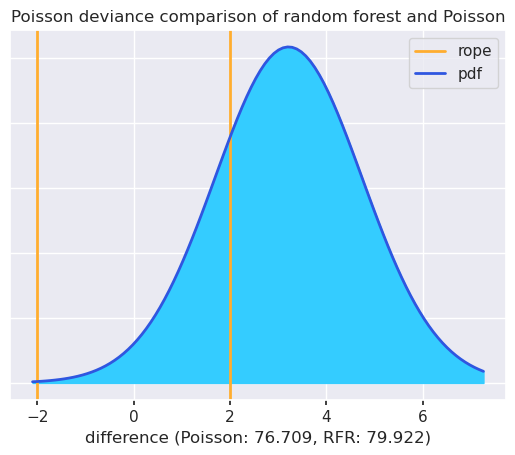

In [35]:
# statistical test comparing performance
rfr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                               y=-rfr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'RFR'), plot=True)
plt.title("Poisson deviance comparison of random forest and Poisson")
print(rfr_vs_poisson)

((9.796702580559903e-06, 0.012116254365451606, 0.9878739489319678), <Figure size 640x480 with 1 Axes>)


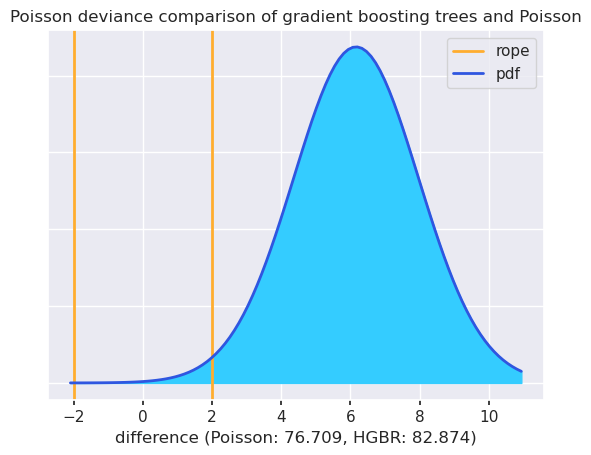

In [36]:
# statistical test comparing performance
hgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-hgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'HGBR'), plot=True)
plt.title("Poisson deviance comparison of gradient boosting trees and Poisson")
print(hgbr_vs_poisson)

((0.9999999948383723, 4.065842662548391e-09, 1.0957850182791162e-09), <Figure size 640x480 with 1 Axes>)


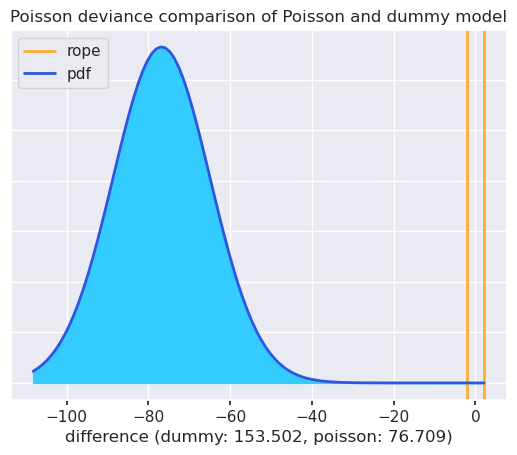

In [66]:
# statistical test comparing performance
poisson_vs_dummy = two_on_single(x=-dummy_results["test_neg_mean_poisson_deviance"], 
                                 y=-poisson_results["test_neg_mean_poisson_deviance"], 
                                 rope=2, runs=10, names=('dummy', 'poisson'), plot=True)
plt.title("Poisson deviance comparison of Poisson and dummy model")
print(poisson_vs_dummy)

## si_year

In [48]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# confirm new size of data set
si_year_data.shape

(2415, 18)

In [49]:
# define target
target = si_year_data['si_year']

# define features
features = si_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [50]:
# always predict most frequent target class
dummy_results = cross_validate(DummyRegressor(strategy='median'), features, target, 
                               scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                               cv=cross_val)
print('The mean RMSE with cross-validation is: ' 
      f'{-dummy_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {dummy_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 164.603 +/- 21.621
The mean Poisson deviance with cross-validation is: 318.354 +/- 59.998


In [51]:
# compute target predictions for later plots
model = DummyRegressor(strategy='median')
model.fit(features, target)
target_predicted_dummy = model.predict(features)

### Poisson regression model

In [51]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [52]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [53]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'poissonregressor__alpha': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [54]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'poissonregressor__alpha': 10}
with Poisson deviance of 123.471
Best hyperparameters for split #2:
{'poissonregressor__alpha': 10}
with Poisson deviance of 158.807
Best hyperparameters for split #3:
{'poissonregressor__alpha': 10}
with Poisson deviance of 128.307
Best hyperparameters for split #4:
{'poissonregressor__alpha': 5}
with Poisson deviance of 137.089
Best hyperparameters for split #5:
{'poissonregressor__alpha': 10}
with Poisson deviance of 130.920


In [55]:
# zoom in around 5 and 10 with validation curve
alpha_values = [5, 10, 15, 20, 30, 50]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='poissonregressor__alpha', 
    param_range=alpha_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

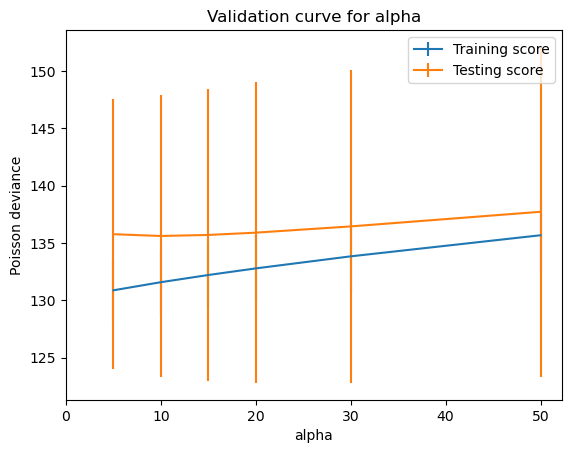

In [56]:
# plot validation curve for alpha
plt.errorbar(alpha_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(alpha_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 60, 10))
plt.xlabel("alpha")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for alpha")

alpha of 10 appears best.

In [57]:
pipeline.set_params(poissonregressor__alpha=10)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 145.912 +/- 18.975
The mean Poisson deviance with cross-validation is: 135.696 +/- 21.025


In [59]:
# compute target predictions for later plots
target_predicted_poisson = cross_val_predict(pipeline, features, target, cv=10)

### Random forest model

In [60]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [61]:
# define algorithm
rfr = RandomForestRegressor(criterion='poisson', n_jobs=2, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfr)

In [62]:
# hyperparameter values to try
param_grid =  {
    'randomforestregressor__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestregressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestregressor__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [63]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 126.654
Best hyperparameters for split #2:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 164.174
Best hyperparameters for split #3:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance of 130.334
Best hyperparameters for split #4:
{'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 136.546
Best hyperparameters for split #5:
{'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance o

We'll try a more focused search around these results.

In [64]:
pipeline.set_params(randomforestregressor__max_features=0.2)
pipeline.set_params(randomforestregressor__n_estimators=600)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [8, 16, 32, 64, 128]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

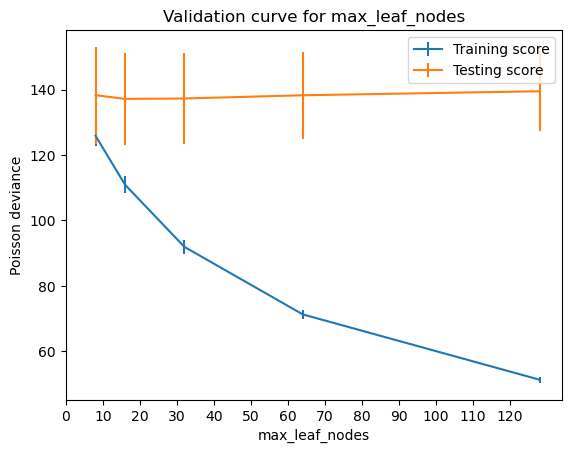

In [65]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 130, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [66]:
pipeline.set_params(randomforestregressor__max_leaf_nodes=16)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400, 500, 600, 700]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__n_estimators', 
    param_range=n_estimators_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

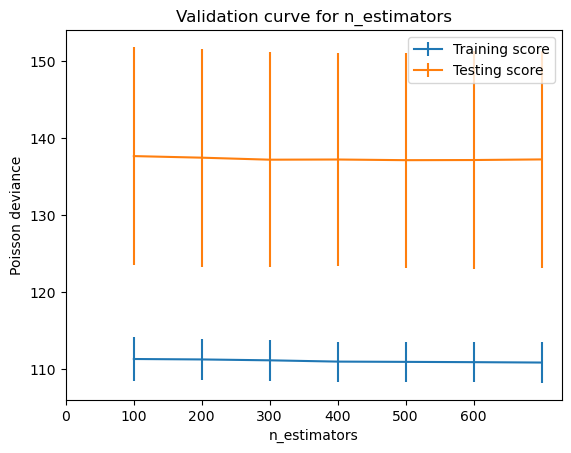

In [67]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 700, 100))
plt.xlabel("n_estimators")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for n_estimators")

We will proceed with max_leaf_nodes of 16, n_estimators of 500, and max_features of 0.2.

In [68]:
pipeline.set_params(randomforestregressor__max_features=0.2)
pipeline.set_params(randomforestregressor__max_leaf_nodes=16)
pipeline.set_params(randomforestregressor__n_estimators=500)

# get results from tuned model
rfr_results = cross_validate(pipeline, features, target, 
                             scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'],
                             cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-rfr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {rfr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 146.267 +/- 19.007
The mean Poisson deviance with cross-validation is: 138.077 +/- 20.103


In [69]:
# compute target predictions for later plots
target_predicted_rfr = cross_val_predict(pipeline, features, target, cv=10)

### Gradient boosting decision trees model

In [70]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [71]:
# define algorithm
hgbr = HistGradientBoostingRegressor(loss='poisson', random_state=0, 
                                     categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbr)

In [72]:
## hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'histgradientboostingregressor__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingregressor__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [73]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 126.771
Best hyperparameters for split #2:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 157.444
Best hyperparameters for split #3:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 132.712
Best hyperparameters for split #4:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 141.116
Best hyperparameters for split #5:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 132.853


Let's examine max_leaf_nodes while holding max_iter at 50.

In [74]:
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 16, 32, 48]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

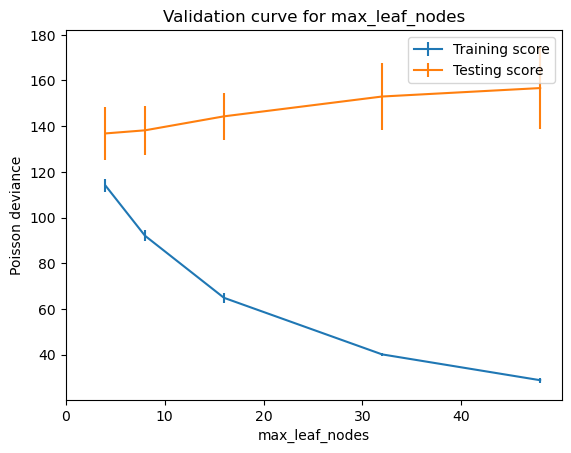

In [75]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 50, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [76]:
pipeline.set_params(histgradientboostingregressor__max_leaf_nodes=4)
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# get results from tuned model
hgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-hgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {hgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 146.342 +/- 18.903
The mean Poisson deviance with cross-validation is: 137.375 +/- 21.720


In [77]:
# compute target predictions for later plots
target_predicted_hgbr = cross_val_predict(pipeline, features, target, cv=10)

### Model comparison

In [78]:
print('Dummy baseline model')
print('Poisson deviance: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print('Poisson model')
print('Poisson deviance: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Random forest model')
print('Poisson deviance: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Gradient boosting decision trees model')
print('Poisson deviance: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()

Dummy baseline model
Poisson deviance: 318.354 +/- 59.998

Poisson model
Poisson deviance: 135.696 +/- 21.025


Random forest model
Poisson deviance: 138.077 +/- 20.103


Gradient boosting decision trees model
Poisson deviance: 137.375 +/- 21.720



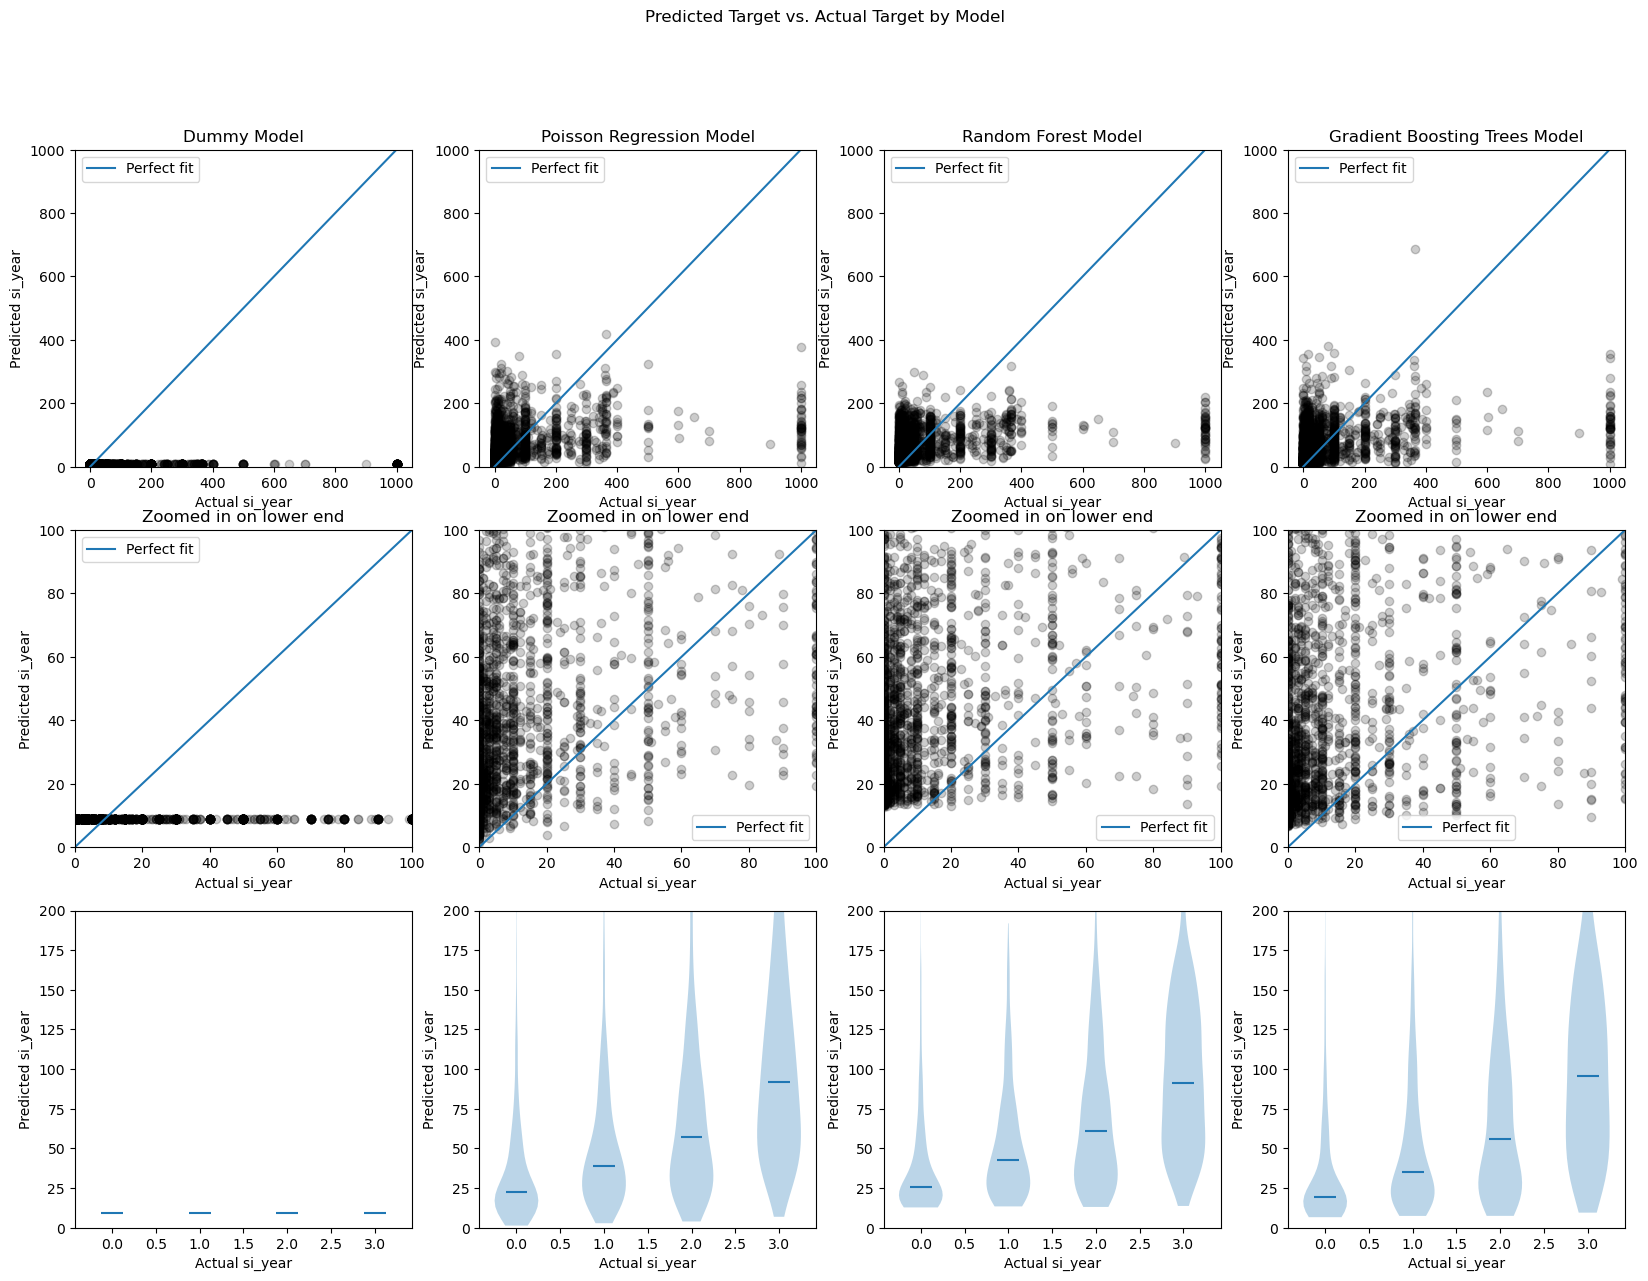

In [84]:
# plot predicted target vs. actual target
fig, axes = plt.subplots(3, 4, figsize=(20, 14))
fig.suptitle('Predicted Target vs. Actual Target by Model')

target_quart = pd.qcut(target, 4, labels=False, duplicates='drop')

axes[0,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[0,0].set_ylim(min(target), max(target))
axes[0,0].set_xlabel("Actual si_year")
axes[0,0].set_ylabel("Predicted si_year")
axes[0,0].axline((0, 0), slope=1, label="Perfect fit")
axes[0,0].legend()
axes[0,0].set_title("Dummy Model")

axes[1,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[1,0].set_xlim(min(target), 100)
axes[1,0].set_ylim(min(target), 100)
axes[1,0].set_xlabel("Actual si_year")
axes[1,0].set_ylabel("Predicted si_year")
axes[1,0].axline((0, 0), slope=1, label="Perfect fit")
axes[1,0].legend()
axes[1,0].set_title("Zoomed in on lower end")

quart0 = target_predicted_dummy[target_quart == 0]
quart1 = target_predicted_dummy[target_quart == 1]
quart2 = target_predicted_dummy[target_quart == 2]
quart3 = target_predicted_dummy[target_quart == 3]
axes[2,0].violinplot([quart0, quart1, quart2, quart3], positions=[0,1,2,3], showextrema=False, showmedians=True)
axes[2,0].set_xlabel("Actual si_year")
axes[2,0].set_ylabel("Predicted si_year")
axes[2,0].set_ylim(0, 200)

axes[0,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[0,1].set_ylim(min(target), max(target))
axes[0,1].set_xlabel("Actual si_year")
axes[0,1].set_ylabel("Predicted si_year")
axes[0,1].axline((0, 0), slope=1, label="Perfect fit")
axes[0,1].legend()
axes[0,1].set_title("Poisson Regression Model")

axes[1,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[1,1].set_xlim(min(target), 100)
axes[1,1].set_ylim(min(target), 100)
axes[1,1].set_xlabel("Actual si_year")
axes[1,1].set_ylabel("Predicted si_year")
axes[1,1].axline((0, 0), slope=1, label="Perfect fit")
axes[1,1].legend()
axes[1,1].set_title("Zoomed in on lower end")

quart0 = target_predicted_poisson[target_quart == 0]
quart1 = target_predicted_poisson[target_quart == 1]
quart2 = target_predicted_poisson[target_quart == 2]
quart3 = target_predicted_poisson[target_quart == 3]
axes[2,1].violinplot([quart0, quart1, quart2, quart3], positions=[0,1,2,3], showextrema=False, showmedians=True)
axes[2,1].set_xlabel("Actual si_year")
axes[2,1].set_ylabel("Predicted si_year")
axes[2,1].set_ylim(0, 200)

axes[0,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[0,2].set_ylim(min(target), max(target))
axes[0,2].set_xlabel("Actual si_year")
axes[0,2].set_ylabel("Predicted si_year")
axes[0,2].axline((0, 0), slope=1, label="Perfect fit")
axes[0,2].legend()
axes[0,2].set_title("Random Forest Model")

axes[1,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[1,2].set_xlim(min(target), 100)
axes[1,2].set_ylim(min(target), 100)
axes[1,2].set_xlabel("Actual si_year")
axes[1,2].set_ylabel("Predicted si_year")
axes[1,2].axline((0, 0), slope=1, label="Perfect fit")
axes[1,2].legend()
axes[1,2].set_title("Zoomed in on lower end")

quart0 = target_predicted_rfr[target_quart == 0]
quart1 = target_predicted_rfr[target_quart == 1]
quart2 = target_predicted_rfr[target_quart == 2]
quart3 = target_predicted_rfr[target_quart == 3]
axes[2,2].violinplot([quart0, quart1, quart2, quart3], positions=[0,1,2,3], showextrema=False, showmedians=True)
axes[2,2].set_xlabel("Actual si_year")
axes[2,2].set_ylabel("Predicted si_year")
axes[2,2].set_ylim(0, 200)

axes[0,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[0,3].set_ylim(min(target), max(target))
axes[0,3].set_xlabel("Actual si_year")
axes[0,3].set_ylabel("Predicted si_year")
axes[0,3].axline((0, 0), slope=1, label="Perfect fit")
axes[0,3].legend()
axes[0,3].set_title("Gradient Boosting Trees Model")

axes[1,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[1,3].set_xlim(min(target), 100)
axes[1,3].set_ylim(min(target), 100)
axes[1,3].set_xlabel("Actual si_year")
axes[1,3].set_ylabel("Predicted si_year")
axes[1,3].axline((0, 0), slope=1, label="Perfect fit")
axes[1,3].legend()
axes[1,3].set_title("Zoomed in on lower end")

quart0 = target_predicted_hgbr[target_quart == 0]
quart1 = target_predicted_hgbr[target_quart == 1]
quart2 = target_predicted_hgbr[target_quart == 2]
quart3 = target_predicted_hgbr[target_quart == 3]
axes[2,3].violinplot([quart0, quart1, quart2, quart3], positions=[0,1,2,3], showextrema=False, showmedians=True)
axes[2,3].set_xlabel("Actual si_year")
axes[2,3].set_ylabel("Predicted si_year")
axes[2,3].set_ylim(0, 200)

None

((0.0032130424646451636, 0.40144304741553294, 0.5953439101198219), <Figure size 640x480 with 1 Axes>)


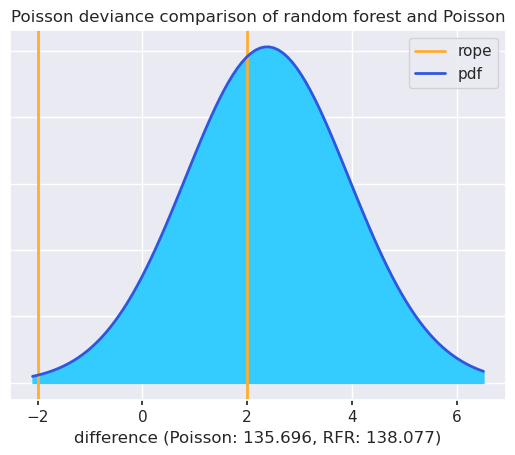

In [85]:
# statistical test comparing performance
rfr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                               y=-rfr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'RFR'), plot=True)
plt.title("Poisson deviance comparison of random forest and Poisson")
print(rfr_vs_poisson)

((0.013359570823015443, 0.5642897142444309, 0.4223507149325537), <Figure size 640x480 with 1 Axes>)


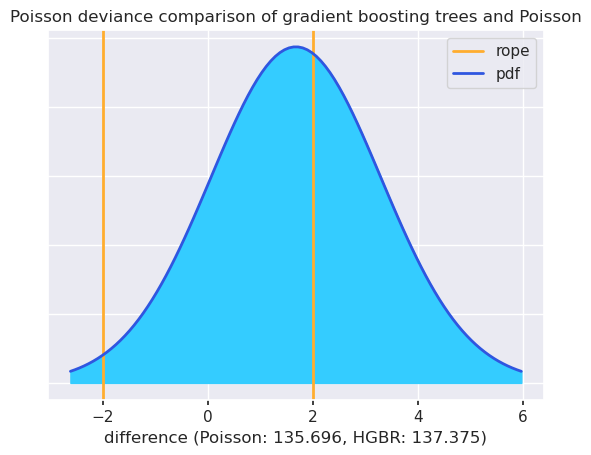

In [86]:
# statistical test comparing performance
hgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-hgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'HGBR'), plot=True)
plt.title("Poisson deviance comparison of gradient boosting trees and Poisson")
print(hgbr_vs_poisson)

((1.0, 0.0, 0.0), <Figure size 640x480 with 1 Axes>)


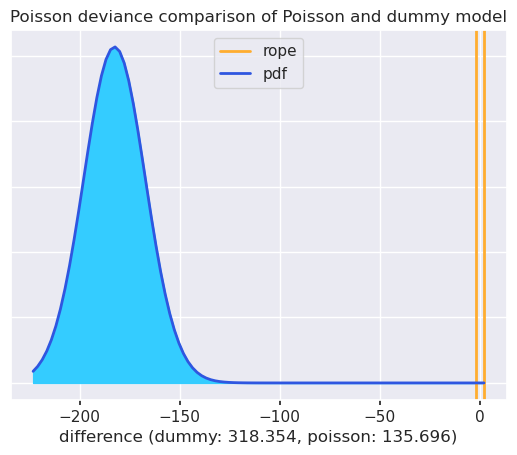

In [59]:
# statistical test comparing performance
poisson_vs_dummy = two_on_single(x=-dummy_results["test_neg_mean_poisson_deviance"], 
                                 y=-poisson_results["test_neg_mean_poisson_deviance"], 
                                 rope=2, runs=10, names=('dummy', 'poisson'), plot=True)
plt.title("Poisson deviance comparison of Poisson and dummy model")
print(poisson_vs_dummy)

## attempt_year

In [67]:
# drop records missing attempt_year for attempt_year models
attempt_year_data = data.dropna(subset='attempt_year')

# confirm new size of data set
attempt_year_data.shape

(2442, 18)

In [68]:
# define target
target = attempt_year_data['attempt_year']

# define features
features = attempt_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [69]:
# always predict most frequent target class
dummy_results = cross_validate(DummyRegressor(strategy='mean'), features, target, 
                               scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                               cv=cross_val)
print('The mean RMSE with cross-validation is: ' 
      f'{-dummy_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {dummy_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.127 +/- 0.772
The mean Poisson deviance with cross-validation is: 2.548 +/- 0.705


In [10]:
# compute target predictions for later plots
model = DummyRegressor(strategy='median')
model.fit(features, target)
target_predicted_dummy = model.predict(features)

### Poisson regression model

In [70]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [71]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [72]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'poissonregressor__alpha': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [73]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 1.540
Best hyperparameters for split #2:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 2.399
Best hyperparameters for split #3:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 1.878
Best hyperparameters for split #4:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 1.881
Best hyperparameters for split #5:
{'poissonregressor__alpha': 0.1}
with Poisson deviance of 1.747


In [74]:
# zoom in around 0.1 with validation curve
alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='poissonregressor__alpha', 
    param_range=alpha_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

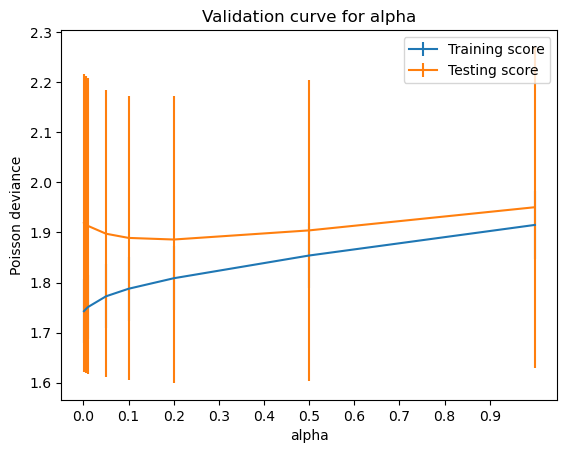

In [75]:
# plot validation curve for alpha
plt.errorbar(alpha_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(alpha_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 1, 0.1))
plt.xlabel("alpha")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for alpha")

alpha of 0.2 appears best.

In [76]:
pipeline.set_params(poissonregressor__alpha=0.2)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.008 +/- 0.730
The mean Poisson deviance with cross-validation is: 1.873 +/- 0.451


In [20]:
# compute target predictions for later plots
target_predicted_poisson = cross_val_predict(pipeline, features, target, cv=10)

### Random forest model

In [21]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [22]:
# define algorithm
rfr = RandomForestRegressor(criterion='poisson', n_jobs=2, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfr)

In [23]:
# hyperparameter values to try
param_grid =  {
    'randomforestregressor__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestregressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestregressor__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [24]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_leaf_nodes': 128, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 1.625
Best hyperparameters for split #2:
{'randomforestregressor__n_estimators': 300, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance of 2.433
Best hyperparameters for split #3:
{'randomforestregressor__n_estimators': 300, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 1.897
Best hyperparameters for split #4:
{'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.3}
with Poisson deviance of 1.818
Best hyperparameters for split #5:
{'randomforestregressor__n_estimators': 100, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.4}
with Poisson deviance of 1.676

We'll try a more focused search around these results.

In [25]:
pipeline.set_params(randomforestregressor__max_features=0.3)
pipeline.set_params(randomforestregressor__n_estimators=300)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [8, 16, 32, 64, 128]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

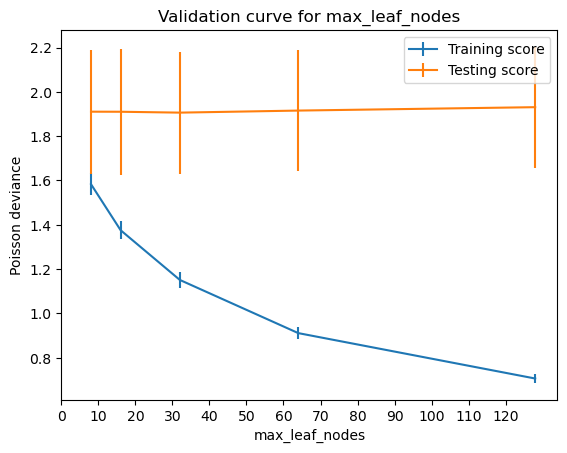

In [26]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 130, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [27]:
pipeline.set_params(randomforestregressor__max_leaf_nodes=32)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400, 500, 600, 700]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__n_estimators', 
    param_range=n_estimators_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

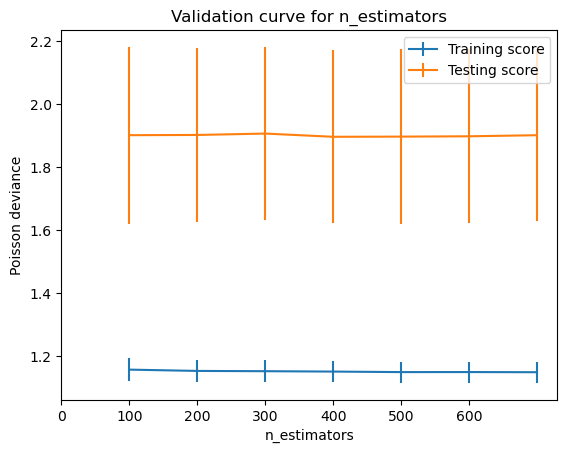

In [28]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 700, 100))
plt.xlabel("n_estimators")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for n_estimators")

In [29]:
pipeline.set_params(randomforestregressor__n_estimators=400)

# generate validation curve for max_features
max_features_values = [0.1, 0.2, 0.3, 0.4, 0.5]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_features', 
    param_range=max_features_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

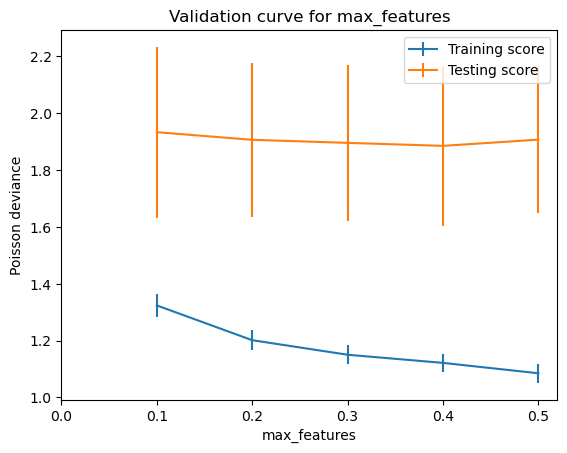

In [30]:
# plot validation curve for max_features
plt.errorbar(max_features_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_features_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.6, 0.1))
plt.xlabel("max_features")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_features")

We will proceed with max_leaf_nodes of 32, n_estimators of 400, and max_features of 0.4.

In [31]:
pipeline.set_params(randomforestregressor__max_features=0.4)
pipeline.set_params(randomforestregressor__max_leaf_nodes=32)
pipeline.set_params(randomforestregressor__n_estimators=400)

# get results from tuned model
rfr_results = cross_validate(pipeline, features, target, 
                             scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'],
                             cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-rfr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {rfr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.051 +/- 0.711
The mean Poisson deviance with cross-validation is: 1.897 +/- 0.436


In [32]:
# compute target predictions for later plots
target_predicted_rfr = cross_val_predict(pipeline, features, target, cv=10)

### Gradient boosting decision trees model

In [33]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [34]:
# define algorithm
hgbr = HistGradientBoostingRegressor(loss='poisson', random_state=0, 
                                     categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbr)

In [35]:
## hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'histgradientboostingregressor__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingregressor__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [36]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 1.618
Best hyperparameters for split #2:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 2.558
Best hyperparameters for split #3:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 2.129
Best hyperparameters for split #4:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 2.158
Best hyperparameters for split #5:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 1.860


Let's examine max_leaf_nodes while holding max_iter at 50.

In [37]:
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 16, 32, 48]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

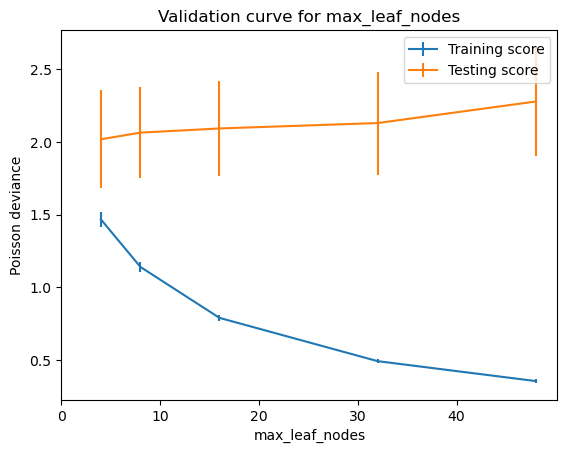

In [38]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 50, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [39]:
pipeline.set_params(histgradientboostingregressor__max_leaf_nodes=4)
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# get results from tuned model
hgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-hgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {hgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 2.119 +/- 0.693
The mean Poisson deviance with cross-validation is: 1.978 +/- 0.477


In [40]:
# compute target predictions for later plots
target_predicted_hgbr = cross_val_predict(pipeline, features, target, cv=10)

### Model comparison

In [41]:
print('Dummy baseline model')
print('Poisson deviance: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print('Poisson model')
print('Poisson deviance: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Random forest model')
print('Poisson deviance: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Gradient boosting decision trees model')
print('Poisson deviance: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()

Dummy baseline model
Poisson deviance: 2.548 +/- 0.705

Poisson model
Poisson deviance: 1.873 +/- 0.451


Random forest model
Poisson deviance: 1.897 +/- 0.436


Gradient boosting decision trees model
Poisson deviance: 1.978 +/- 0.477



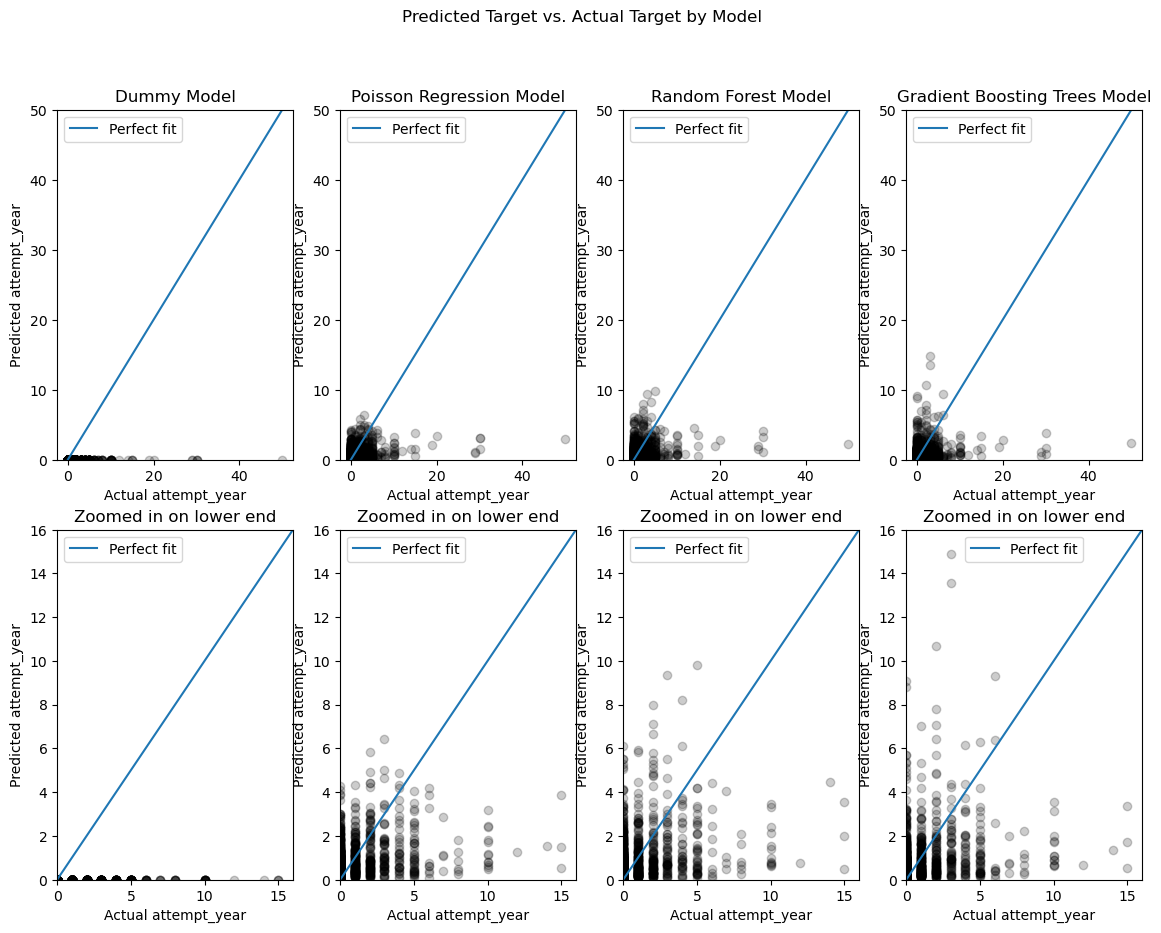

In [51]:
# plot predicted target vs. actual target
fig, axes = plt.subplots(2, 4, figsize=(14, 10))
fig.suptitle('Predicted Target vs. Actual Target by Model')

axes[0,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[0,0].set_ylim(min(target), max(target))
axes[0,0].set_xlabel("Actual attempt_year")
axes[0,0].set_ylabel("Predicted attempt_year")
axes[0,0].axline((0, 0), slope=1, label="Perfect fit")
axes[0,0].legend()
axes[0,0].set_title("Dummy Model")

axes[1,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[1,0].set_xlim(min(target), 16)
axes[1,0].set_ylim(min(target), 16)
axes[1,0].set_xlabel("Actual attempt_year")
axes[1,0].set_ylabel("Predicted attempt_year")
axes[1,0].axline((0, 0), slope=1, label="Perfect fit")
axes[1,0].legend()
axes[1,0].set_title("Zoomed in on lower end")

axes[0,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[0,1].set_ylim(min(target), max(target))
axes[0,1].set_xlabel("Actual attempt_year")
axes[0,1].set_ylabel("Predicted attempt_year")
axes[0,1].axline((0, 0), slope=1, label="Perfect fit")
axes[0,1].legend()
axes[0,1].set_title("Poisson Regression Model")

axes[1,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[1,1].set_xlim(min(target), 16)
axes[1,1].set_ylim(min(target), 16)
axes[1,1].set_xlabel("Actual attempt_year")
axes[1,1].set_ylabel("Predicted attempt_year")
axes[1,1].axline((0, 0), slope=1, label="Perfect fit")
axes[1,1].legend()
axes[1,1].set_title("Zoomed in on lower end")

axes[0,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[0,2].set_ylim(min(target), max(target))
axes[0,2].set_xlabel("Actual attempt_year")
axes[0,2].set_ylabel("Predicted attempt_year")
axes[0,2].axline((0, 0), slope=1, label="Perfect fit")
axes[0,2].legend()
axes[0,2].set_title("Random Forest Model")

axes[1,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[1,2].set_xlim(min(target), 16)
axes[1,2].set_ylim(min(target), 16)
axes[1,2].set_xlabel("Actual attempt_year")
axes[1,2].set_ylabel("Predicted attempt_year")
axes[1,2].axline((0, 0), slope=1, label="Perfect fit")
axes[1,2].legend()
axes[1,2].set_title("Zoomed in on lower end")

axes[0,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[0,3].set_ylim(min(target), max(target))
axes[0,3].set_xlabel("Actual attempt_year")
axes[0,3].set_ylabel("Predicted attempt_year")
axes[0,3].axline((0, 0), slope=1, label="Perfect fit")
axes[0,3].legend()
axes[0,3].set_title("Gradient Boosting Trees Model")

axes[1,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[1,3].set_xlim(min(target), 16)
axes[1,3].set_ylim(min(target), 16)
axes[1,3].set_xlabel("Actual attempt_year")
axes[1,3].set_ylabel("Predicted attempt_year")
axes[1,3].axline((0, 0), slope=1, label="Perfect fit")
axes[1,3].legend()
axes[1,3].set_title("Zoomed in on lower end")

None

((7.364376937618593e-80, 1.0, 0.0), <Figure size 640x480 with 1 Axes>)


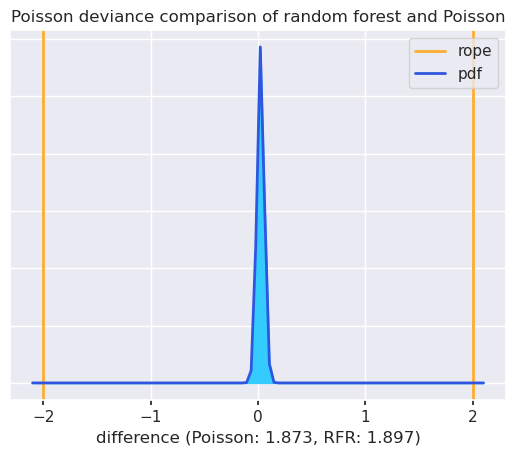

In [52]:
# statistical test comparing performance
rfr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                               y=-rfr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'RFR'), plot=True)
plt.title("Poisson deviance comparison of random forest and Poisson")
print(rfr_vs_poisson)

((2.0762991755376223e-80, 1.0, 0.0), <Figure size 640x480 with 1 Axes>)


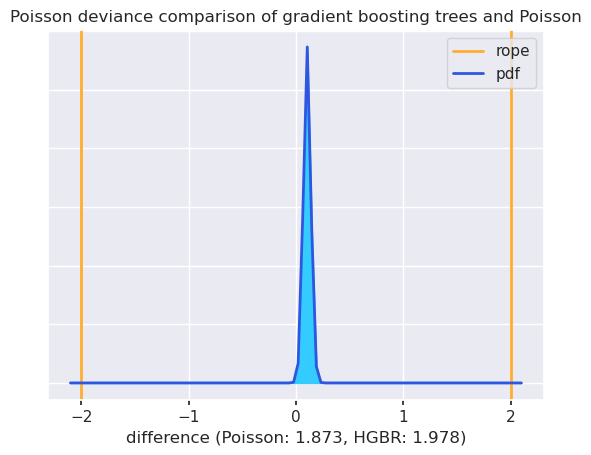

In [53]:
# statistical test comparing performance
hgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-hgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=2, runs=10, names=('Poisson', 'HGBR'), plot=True)
plt.title("Poisson deviance comparison of gradient boosting trees and Poisson")
print(hgbr_vs_poisson)

((2.2550101315336543e-20, 1.0, 0.0), <Figure size 640x480 with 1 Axes>)


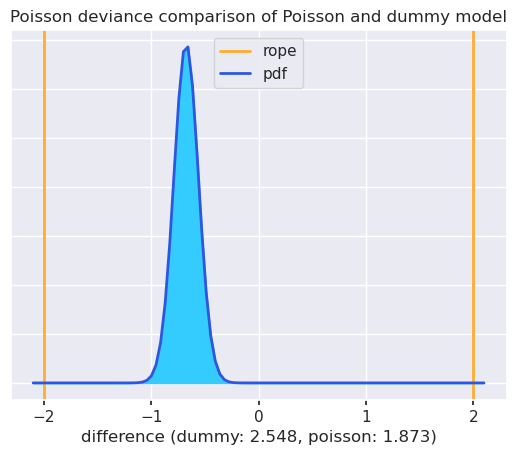

In [77]:
# statistical test comparing performance
poisson_vs_dummy = two_on_single(x=-dummy_results["test_neg_mean_poisson_deviance"], 
                                 y=-poisson_results["test_neg_mean_poisson_deviance"], 
                                 rope=2, runs=10, names=('dummy', 'poisson'), plot=True)
plt.title("Poisson deviance comparison of Poisson and dummy model")
print(poisson_vs_dummy)

# Hypothesis 2

For the categorical targets, the logistic regression models tended to have the highest values for AUROC,  
although differences in AUROC between logistic regression and random forest and gradient boosting decision trees were not significant.  
Logistic regression did significantly outperform dummy models for all categorical targets on AUROC.  
Therefore, we will use logistic regression models to test Hypothesis 2 for the categorical targets.  
  
For the frequency targets, the Poisson regression models had the lowest mean Poisson deviance scores.  
Poisson regression significantly outperformed gradient boosting decision trees for nssi_year,  
but the remaining differences between the Poisson regression models and the tree-based models were not significant.  
Poisson regression significantly outperformed dummy models for nssi_year and si_year, but not attempt_year.  
Therefore, we will use Poisson regression models to test Hypothesis 2 for nssi_year and si_year, but not attempt_year.

In [4]:
# finding a feature set that does not exceed a Pearson correlation threshold of 0.6
numeric_features = ['loneliness', 'depression', 'hope', 
                    'child_adverse', 'discrimination', 'anxiety']
data[numeric_features].corr()

loneliness  depression      hope  child_adverse  \
loneliness        1.000000    0.550011 -0.423158       0.225473   
depression        0.550011    1.000000 -0.563095       0.302187   
hope             -0.423158   -0.563095  1.000000      -0.189588   
child_adverse     0.225473    0.302187 -0.189588       1.000000   
discrimination    0.347911    0.433894 -0.238655       0.341760   
anxiety           0.380203    0.564212 -0.274598       0.268789   

                discrimination   anxiety  
loneliness            0.347911  0.380203  
depression            0.433894  0.564212  
hope                 -0.238655 -0.274598  
child_adverse         0.341760  0.268789  
discrimination        1.000000  0.421275  
anxiety               0.421275  1.000000

In [4]:
# drop features to reduce multicollinearity
data.drop(labels=['hopelessness', 'peer_vict', 'behav_act'], axis=1, inplace=True)

In [71]:
# define function to compute permutation feature importances
# perm_n: number of iterations of permutation feature importance procedure to aggregate
def perm_feat_imp(pipeline, perm_n=25, score='roc_auc'):
    
    # create dataframe to store results
    perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n))
    
    for i in range(perm_n):

        # split data for permutation importance computation
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

        # permutation importance computation
        pipeline.fit(X_train, y_train)
        perm_results = permutation_importance(pipeline, X_test, y_test, scoring=score, 
                                              n_repeats=10, random_state=0, n_jobs=2)

        # store results in a dataframe and sort
        perm_results_df.iloc[:, i] = perm_results.importances_mean
        
    # summarize results over iterations
    perm_results_summary = pd.DataFrame(index=features.columns)
    perm_results_summary['mean'] = perm_results_df.mean(axis=1)
    perm_results_summary['std'] = perm_results_df.std(axis=1)
    perm_results_summary.sort_values('mean', ascending=False, inplace=True)
    
    return perm_results_df, perm_results_summary

In [28]:
# define function to compute feature rank instability
# how much feature rank changes over aggregations of successively larger number of permutation importance iterations
def rank_instability(perm_results_df):
    instability = pd.Series(index=range(2,26), dtype='float')
    
    # compute feature rank instability between 1st iteration and the aggregation of the 1st 2 iterations
    agg1 = perm_results_df.iloc[:, 0].rank(ascending=False)
    agg2 = perm_results_df.iloc[:, 0:2].mean(axis=1).rank(ascending=False)
    instability[2] = abs(agg2 - agg1).mean()
    
    # compute feature rank instability between successive aggregations
    for i in range(3,26):
        agg1 = perm_results_df.iloc[:, 0:(i-1)].mean(axis=1).rank(ascending=False)
        agg2 = perm_results_df.iloc[:, 0:i].mean(axis=1).rank(ascending=False)
        instability[i] = abs(agg2 - agg1).mean()
        
    return instability

## Gender subgroup analyses

In [5]:
# create subsets of data for each gender group
data_cis = data[data['gender'] != 'gender_diverse'].copy()
data_minor = data[data['gender'] == 'gender_diverse'].copy()

In [19]:
# Levene's tests
print("Levene's test results:")
quants = ['loneliness', 'depression', 'hope', 'child_adverse', 'discrimination', 'anxiety',
         'nssi_year', 'si_year']
for i in quants:
    _, p_value = stats.levene(data_cis[i].dropna(), data_minor[i].dropna())
    print(i, 'p value:', f'{p_value:.3f}')

Levene's test results:
loneliness p value: 0.311
depression p value: 0.000
hope p value: 0.985
child_adverse p value: 0.890
discrimination p value: 0.018
anxiety p value: 0.003
nssi_year p value: 0.000
si_year p value: 0.000


In [21]:
# Independent-samples t tests
print("Independent-samples t test results:")
quants_equal_var = ['loneliness', 'hope', 'child_adverse']
quants_unequal_var = ['depression', 'discrimination', 'anxiety', 'nssi_year', 'si_year']

for i in quants_equal_var:
    t_value, p_value = stats.ttest_ind(data_cis[i].dropna(), data_minor[i].dropna())
    print(i, '-- cis:', f'{data_cis[i].mean():.2f}', '-- minority:', f'{data_minor[i].mean():.2f}', 
          '-- t value:', f'{t_value:.2f}', '-- p value:', f'{p_value:.3f}')

for i in quants_unequal_var:
    t_value, p_value = stats.ttest_ind(data_cis[i].dropna(), data_minor[i].dropna(), equal_var=False)
    print(i, '-- cis:', f'{data_cis[i].mean():.2f}', '-- minority:', f'{data_minor[i].mean():.2f}', 
          '-- t value:', f'{t_value:.2f}', '-- p value:', f'{p_value:.3f}')

Independent-samples t test results:
loneliness -- cis: 37.43 -- minority: 40.31 -- t value: -6.55 -- p value: 0.000
hope -- cis: 24.46 -- minority: 21.85 -- t value: 7.37 -- p value: 0.000
child_adverse -- cis: 2.18 -- minority: 2.80 -- t value: -10.26 -- p value: 0.000
depression -- cis: 13.58 -- minority: 15.40 -- t value: -11.10 -- p value: 0.000
discrimination -- cis: 28.13 -- minority: 32.95 -- t value: -11.35 -- p value: 0.000
anxiety -- cis: 20.28 -- minority: 22.10 -- t value: -8.52 -- p value: 0.000
nssi_year -- cis: 17.49 -- minority: 41.66 -- t value: -5.12 -- p value: 0.000
si_year -- cis: 52.89 -- minority: 84.04 -- t value: -4.38 -- p value: 0.000


In [34]:
# chi square tests of independence
data['gender_group'] = np.select([(data['gender'] != 'gender_diverse'), (data['gender'] == 'gender_diverse')],
                                 ['cis', 'minority'])

print('Results for chi square tests of independence')
categoricals = ['sex', 'orientation', 'nssi_bin', 'si_bin', 'attempt_bin']

for i in categoricals:
    contingency = pd.crosstab(data[i], data['gender_group'])
    print('\n', pd.crosstab(data[i], data['gender_group'], normalize='columns'))
    
    # don't include rows with counts less than 10 in test
    chi_results = stats.chi2_contingency(contingency[(contingency['cis'] >= 10) & (contingency['minority'] >= 10)])
    print(i, '-- x2:', f'{chi_results[0]:.2f}', '-- df:', f'{chi_results[2]:.2f}', 
          '-- p value:', f'{chi_results[1]:.3f}')

Results for chi square tests of independence

 gender_group            cis  minority
sex                                  
Female             0.880786  0.882151
Male               0.118580  0.073227
Other              0.000000  0.022883
Prefer not to say  0.000634  0.021739
sex -- x2: 9.88 -- df: 1.00 -- p value: 0.002

 gender_group                            cis  minority
orientation                                          
Asexual                            0.038047  0.072082
Bisexual                           0.280279  0.268879
Gay/Lesbian/Homosexual             0.090679  0.125858
Heterosexual/Straight              0.309448  0.011442
I do not use a label               0.050095  0.069794
I do not want to respond           0.006341  0.000000
Other/Not listed (please specify)  0.015219  0.078947
Pansexual                          0.065948  0.183066
Queer                              0.021560  0.129291
Unsure/Questioning                 0.122384  0.060641
orientation -- x2: 530.59 -- 

### nssi_bin

#### cis

In [32]:
# define target
target = data_cis['nssi_bin']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [33]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [34]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [35]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.663 +/- 0.008
The mean precision with cross-validation is: 0.745 +/- 0.011
The mean recall with cross-validation is: 0.668 +/- 0.012
The mean AUROC with cross-validation is: 0.734 +/- 0.012


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.045833  0.010836
child_adverse   0.029336  0.005217
discrimination  0.028927  0.007836
orientation     0.020698  0.007800
loneliness      0.003815  0.003991
sex             0.003419  0.003701
hope            0.002832  0.003081
anxiety         0.001574  0.001979


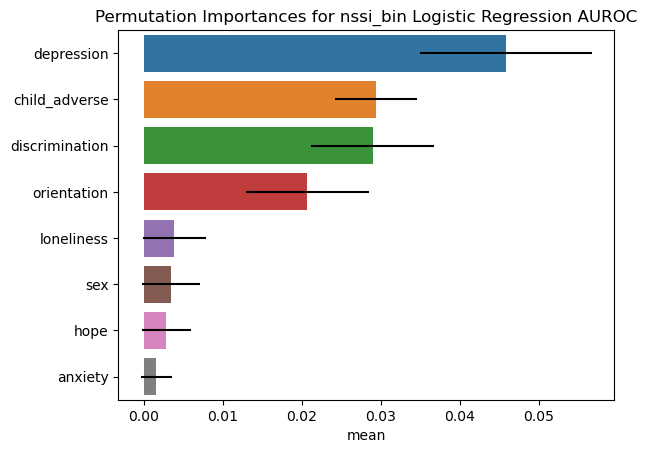

In [36]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

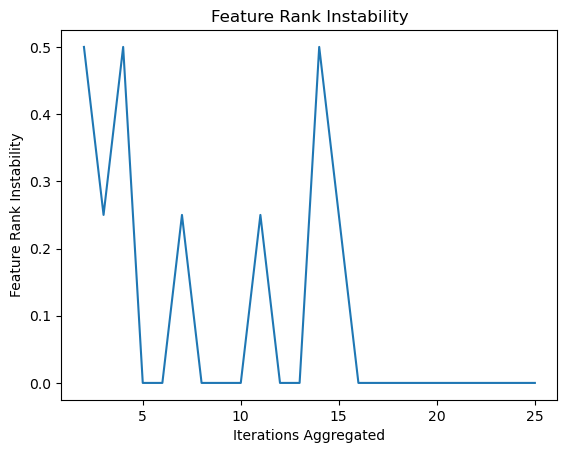

In [37]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [38]:
# define target
target = data_minor['nssi_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [39]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.642 +/- 0.036
The mean precision with cross-validation is: 0.870 +/- 0.018
The mean recall with cross-validation is: 0.653 +/- 0.049
The mean AUROC with cross-validation is: 0.687 +/- 0.054


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.051686  0.022493
sex             0.022473  0.012869
anxiety         0.022455  0.013466
discrimination  0.017957  0.013322
orientation     0.006891  0.013281
child_adverse  -0.000587  0.009546
loneliness     -0.000748  0.005014
hope           -0.002862  0.004617


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


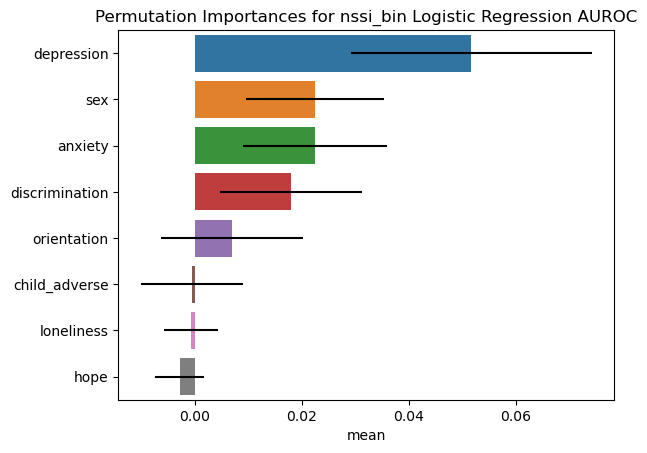

In [40]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

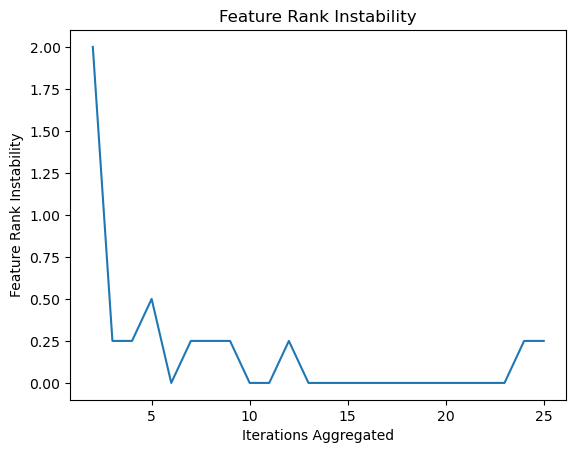

In [41]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### si_bin

#### cis

In [42]:
# define target
target = data_cis['si_bin']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [43]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [44]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [45]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.684 +/- 0.014
The mean precision with cross-validation is: 0.872 +/- 0.012
The mean recall with cross-validation is: 0.691 +/- 0.017
The mean AUROC with cross-validation is: 0.743 +/- 0.016


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.097404  0.018112
child_adverse   0.043894  0.012123
orientation     0.016655  0.006823
discrimination  0.002908  0.002148
sex             0.000479  0.002206
anxiety         0.000420  0.001597
loneliness      0.000019  0.003661
hope           -0.000412  0.001574


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


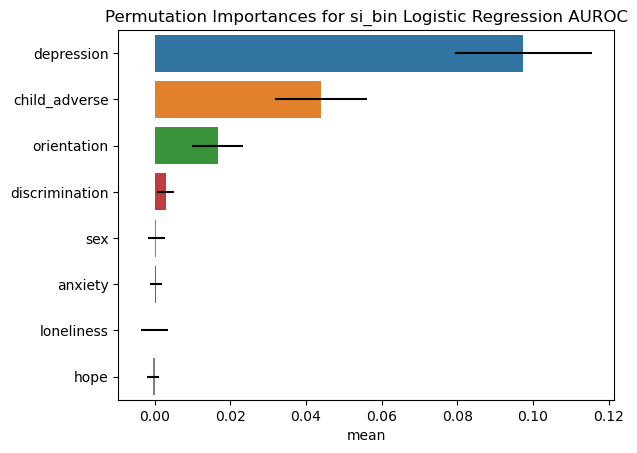

In [46]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

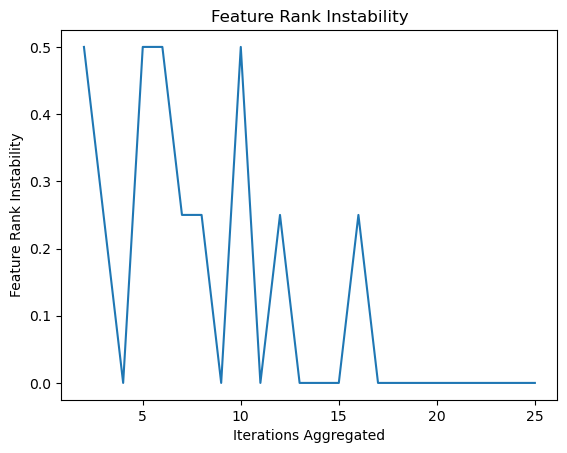

In [47]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [48]:
# define target
target = data_minor['si_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [49]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.657 +/- 0.007
The mean precision with cross-validation is: 0.918 +/- 0.023
The mean recall with cross-validation is: 0.676 +/- 0.026
The mean AUROC with cross-validation is: 0.657 +/- 0.059


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.074048  0.038276
anxiety         0.024267  0.021247
loneliness      0.014721  0.013383
child_adverse   0.008985  0.012408
hope            0.000188  0.010485
sex            -0.001116  0.006220
orientation    -0.003517  0.012600
discrimination -0.004751  0.008555


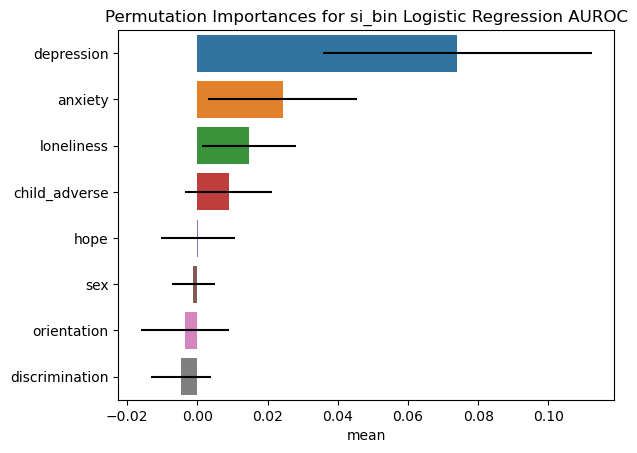

In [50]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

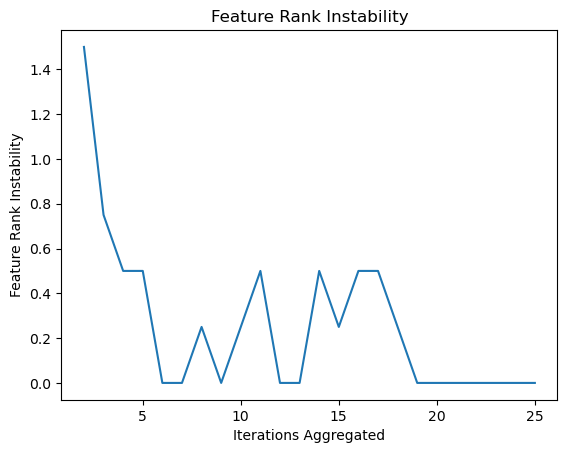

In [51]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### attempt_bin

#### cis

In [52]:
# define target
target = data_cis['attempt_bin']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [53]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [54]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [55]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.679 +/- 0.021
The mean precision with cross-validation is: 0.430 +/- 0.021
The mean recall with cross-validation is: 0.685 +/- 0.042
The mean AUROC with cross-validation is: 0.757 +/- 0.026


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.103886  0.014674
child_adverse   0.043161  0.008752
discrimination  0.022675  0.006420
orientation     0.015244  0.005868
hope            0.003160  0.003924
loneliness      0.000681  0.002210
anxiety        -0.000526  0.001211
sex            -0.000561  0.000677


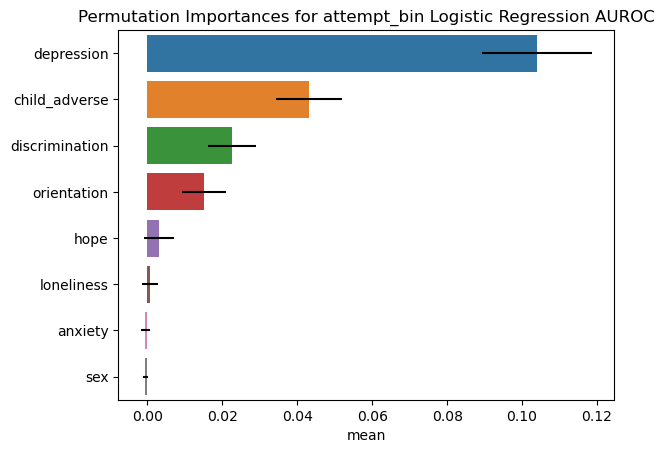

In [56]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

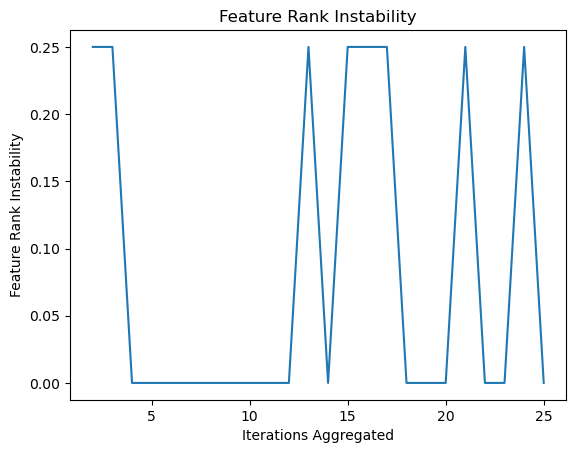

In [57]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [58]:
# define target
target = data_minor['attempt_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [59]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.673 +/- 0.024
The mean precision with cross-validation is: 0.602 +/- 0.029
The mean recall with cross-validation is: 0.673 +/- 0.020
The mean AUROC with cross-validation is: 0.735 +/- 0.025


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
discrimination  0.086744  0.020024
depression      0.032733  0.010022
child_adverse   0.023240  0.009785
anxiety         0.003222  0.003826
sex             0.002153  0.002953
orientation     0.000434  0.004938
hope           -0.000959  0.002705
loneliness     -0.001051  0.002505


C:\Users\jpowe\slash\tmp\ipykernel_13048\1692938094.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


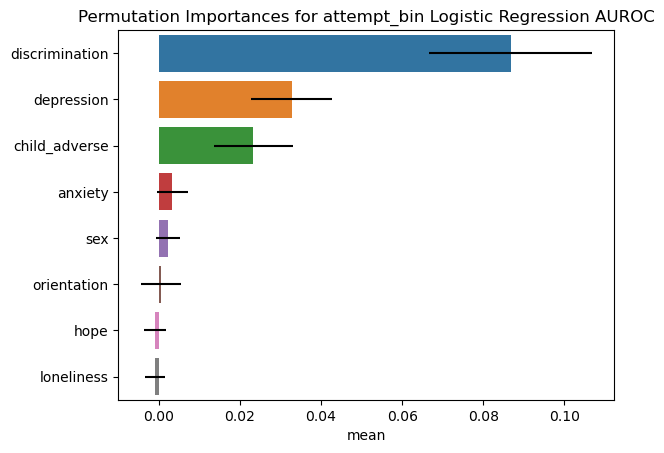

In [60]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

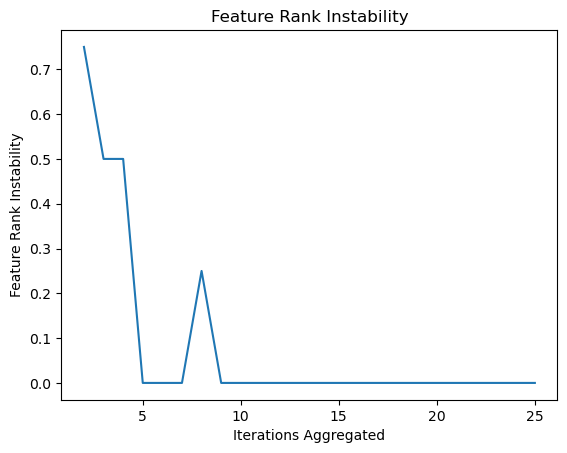

In [61]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### nssi_year

In [65]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# create subsets of data for each gender group
data_cis = nssi_year_data[nssi_year_data['gender'] != 'gender_diverse'].copy()
data_minor = nssi_year_data[nssi_year_data['gender'] == 'gender_diverse'].copy()

#### cis

In [67]:
# define target
target = data_cis['nssi_year']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [68]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [69]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [70]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 67.608 +/- 18.345
The mean Poisson deviance with cross-validation is: 57.778 +/- 16.627


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      6.870784  2.968944
discrimination  1.639119  0.925258
anxiety         1.281940  0.962625
hope            0.858170  1.872936
sex             0.769144  0.320072
loneliness     -0.025849  0.781947
orientation    -0.060489  0.550200
child_adverse  -0.184626  0.450997


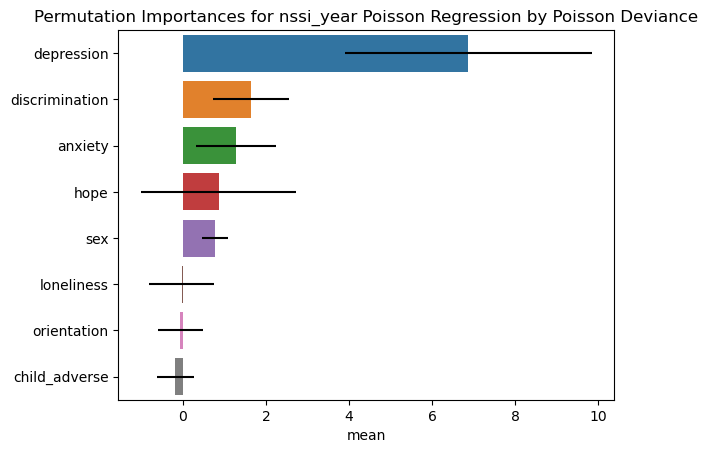

In [72]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

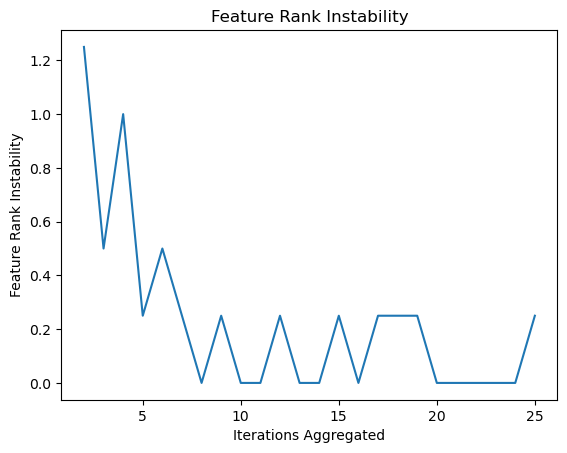

In [73]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [74]:
# define target
target = data_minor['nssi_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [75]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 120.920 +/- 34.303
The mean Poisson deviance with cross-validation is: 114.780 +/- 34.480


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                     mean       std
depression      17.038666  7.481088
discrimination   4.913557  4.963710
hope             3.889686  3.119503
anxiety          3.010928  3.028666
orientation      1.100051  2.025061
child_adverse    0.553946  1.561448
sex              0.010961  1.087206
loneliness      -0.447526  1.024069


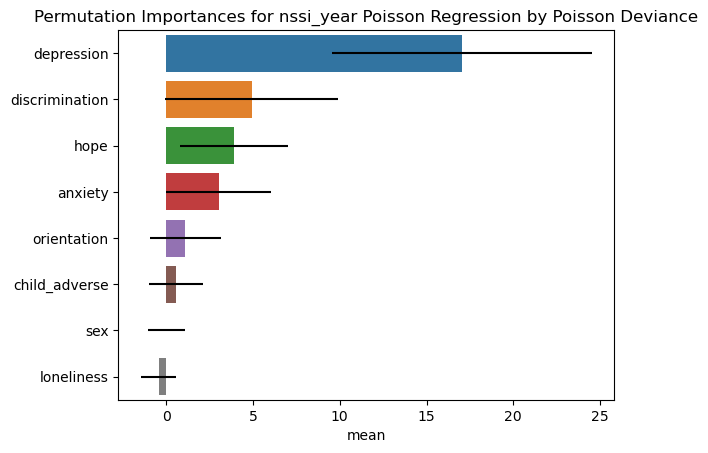

In [76]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

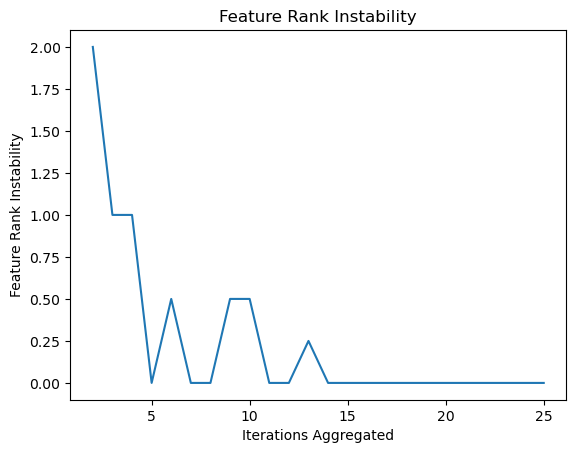

In [77]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### si_year

In [78]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# create subsets of data for each gender group
data_cis = si_year_data[si_year_data['gender'] != 'gender_diverse'].copy()
data_minor = si_year_data[si_year_data['gender'] == 'gender_diverse'].copy()

#### cis

In [79]:
# define target
target = data_cis['si_year']

# define features
features = data_cis[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [80]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [81]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [82]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 132.338 +/- 11.186
The mean Poisson deviance with cross-validation is: 121.896 +/- 11.869


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                     mean       std
depression      31.434607  8.090143
anxiety          8.945977  4.322053
hope             3.147239  2.512154
child_adverse    1.718938  2.466667
loneliness       0.003522  1.405746
sex             -0.117911  0.175878
discrimination  -0.340724  0.846395
orientation     -0.677942  0.902781


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


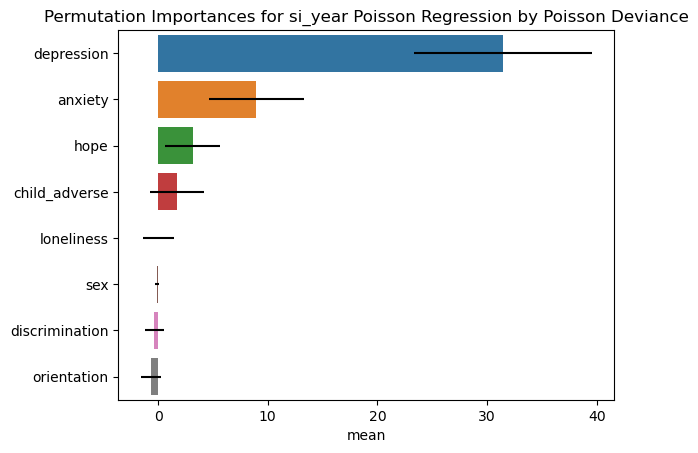

In [83]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

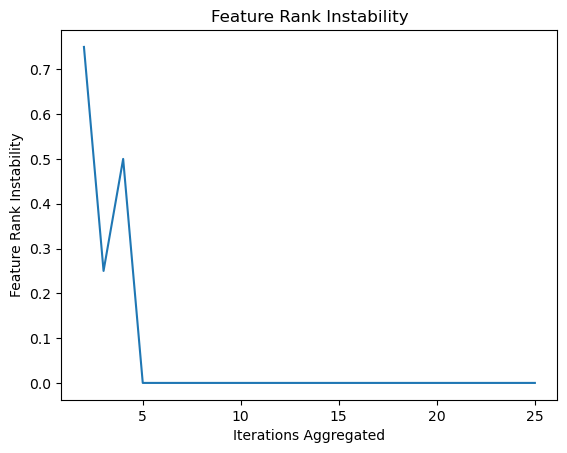

In [84]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [85]:
# define target
target = data_minor['si_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'orientation',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [86]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 170.915 +/- 23.314
The mean Poisson deviance with cross-validation is: 168.894 +/- 24.823


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                     mean       std
depression      19.819308  9.336877
anxiety          8.791517  6.315451
loneliness       4.913642  4.782106
discrimination   3.284121  4.202547
child_adverse    2.322982  2.510650
hope             0.122989  1.210814
sex             -0.301186  0.781961
orientation     -0.322627  2.671992


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


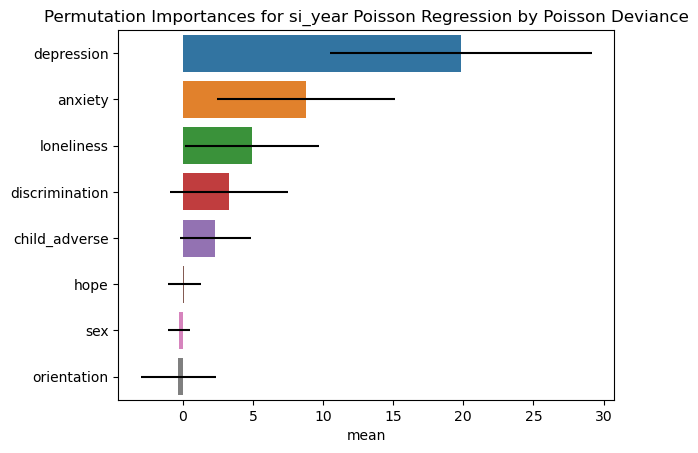

In [87]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

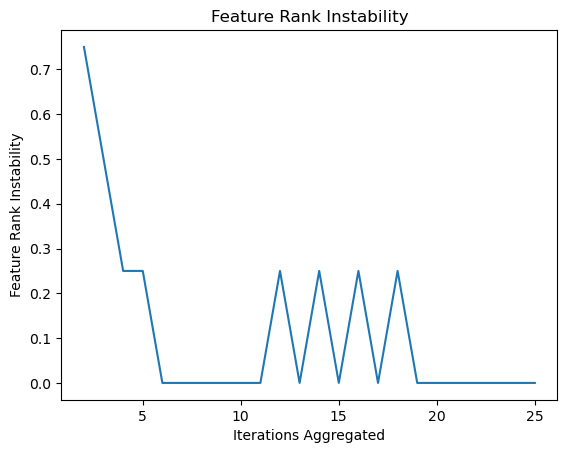

In [88]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

## Orientation subgroup analyses

In [35]:
# create subsets of data for each orientation group
data_hetero = data[data['orientation'] == 'Heterosexual/Straight'].copy()
data_minor = data[data['orientation'] != 'Heterosexual/Straight'].copy()

In [36]:
# Levene's tests
print("Levene's test results:")
quants = ['loneliness', 'depression', 'hope', 'child_adverse', 'discrimination', 'anxiety',
         'nssi_year', 'si_year']
for i in quants:
    _, p_value = stats.levene(data_hetero[i].dropna(), data_minor[i].dropna())
    print(i, 'p value:', f'{p_value:.3f}')

Levene's test results:
loneliness p value: 0.006
depression p value: 0.000
hope p value: 0.894
child_adverse p value: 0.087
discrimination p value: 0.056
anxiety p value: 0.000
nssi_year p value: 0.000
si_year p value: 0.002


In [38]:
# Independent-samples t tests
print("Independent-samples t test results:")
quants_equal_var = ['hope', 'child_adverse', 'discrimination']
quants_unequal_var = ['loneliness', 'depression', 'anxiety', 'nssi_year', 'si_year']

for i in quants_equal_var:
    t_value, p_value = stats.ttest_ind(data_hetero[i].dropna(), data_minor[i].dropna())
    print(i, '-- heterosexual:', f'{data_hetero[i].mean():.2f}', '-- minority:', f'{data_minor[i].mean():.2f}', 
          '-- t value:', f'{t_value:.2f}', '-- p value:', f'{p_value:.3f}')

for i in quants_unequal_var:
    t_value, p_value = stats.ttest_ind(data_hetero[i].dropna(), data_minor[i].dropna(), equal_var=False)
    print(i, '-- heterosexual:', f'{data_hetero[i].mean():.2f}', '-- minority:', f'{data_minor[i].mean():.2f}', 
          '-- t value:', f'{t_value:.2f}', '-- p value:', f'{p_value:.3f}')

Independent-samples t test results:
hope -- heterosexual: 26.04 -- minority: 22.89 -- t value: 7.51 -- p value: 0.000
child_adverse -- heterosexual: 1.84 -- minority: 2.54 -- t value: -9.69 -- p value: 0.000
discrimination -- heterosexual: 26.36 -- minority: 30.74 -- t value: -8.68 -- p value: 0.000
loneliness -- heterosexual: 35.72 -- minority: 39.15 -- t value: -6.18 -- p value: 0.000
depression -- heterosexual: 12.41 -- minority: 14.69 -- t value: -10.52 -- p value: 0.000
anxiety -- heterosexual: 18.99 -- minority: 21.42 -- t value: -8.68 -- p value: 0.000
nssi_year -- heterosexual: 11.90 -- minority: 29.75 -- t value: -5.32 -- p value: 0.000
si_year -- heterosexual: 42.22 -- minority: 69.56 -- t value: -3.97 -- p value: 0.000


In [39]:
# chi square tests of independence
data['orientation_group'] = np.select([(data['orientation'] == 'Heterosexual/Straight'), 
                                       (data['orientation'] != 'Heterosexual/Straight')],
                                 ['heterosexual', 'minority'])

print('Results for chi square tests of independence')
categoricals = ['sex', 'gender', 'nssi_bin', 'si_bin', 'attempt_bin']

for i in categoricals:
    contingency = pd.crosstab(data[i], data['orientation_group'])
    print('\n', pd.crosstab(data[i], data['orientation_group'], normalize='columns'))
    
    # don't include rows with counts less than 10 in test
    chi_results = stats.chi2_contingency(contingency[(contingency['heterosexual'] >= 10) & (contingency['minority'] >= 10)])
    print(i, '-- x2:', f'{chi_results[0]:.2f}', '-- df:', f'{chi_results[2]:.2f}', 
          '-- p value:', f'{chi_results[1]:.3f}')

Results for chi square tests of independence

 orientation_group  heterosexual  minority
sex                                      
Female                 0.815261  0.898105
Male                   0.184739  0.081413
Other                  0.000000  0.010241
Prefer not to say      0.000000  0.010241
sex -- x2: 42.67 -- df: 1.00 -- p value: 0.000

 orientation_group  heterosexual  minority
gender                                   
gender_diverse         0.020080  0.442396
man_only               0.180723  0.053251
woman_only             0.799197  0.504352
gender -- x2: 341.07 -- df: 2.00 -- p value: 0.000

 orientation_group  heterosexual  minority
nssi_bin                                 
0.0                    0.534137  0.272401
1.0                    0.465863  0.727599
nssi_bin -- x2: 122.61 -- df: 1.00 -- p value: 0.000

 orientation_group  heterosexual  minority
si_bin                                   
0                      0.353414  0.145929
1                      0.646586  0.85407

### nssi_bin

#### heterosexual

In [90]:
# define target
target = data_hetero['nssi_bin']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [91]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [92]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [93]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.641 +/- 0.033
The mean precision with cross-validation is: 0.617 +/- 0.039
The mean recall with cross-validation is: 0.604 +/- 0.043
The mean AUROC with cross-validation is: 0.714 +/- 0.048


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.061116  0.023636
discrimination  0.052728  0.017418
child_adverse   0.010481  0.010843
loneliness      0.000589  0.005582
hope            0.000338  0.004219
anxiety         0.000006  0.004057
sex            -0.002836  0.005734
gender         -0.002849  0.005226


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


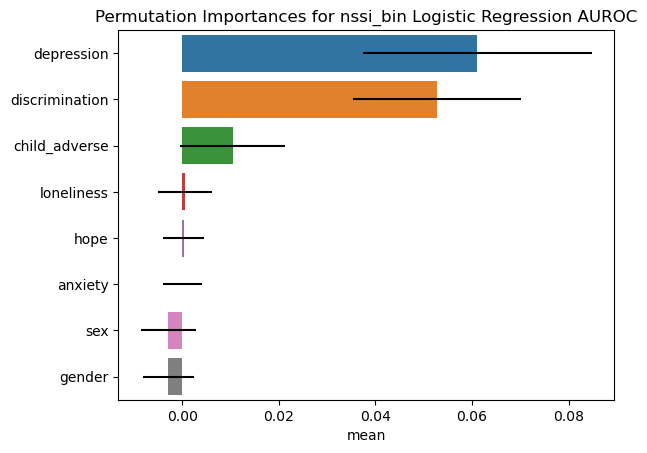

In [94]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

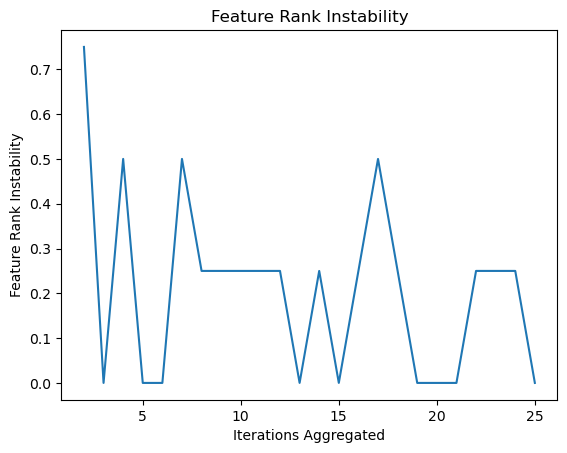

In [95]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [96]:
# define target
target = data_minor['nssi_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [97]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.666 +/- 0.017
The mean precision with cross-validation is: 0.843 +/- 0.010
The mean recall with cross-validation is: 0.665 +/- 0.027
The mean AUROC with cross-validation is: 0.720 +/- 0.018


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.051229  0.012873
gender          0.023293  0.004783
child_adverse   0.021289  0.007100
discrimination  0.020192  0.005323
sex             0.016839  0.008098
anxiety         0.006790  0.003483
hope            0.002538  0.004223
loneliness     -0.000255  0.001397


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


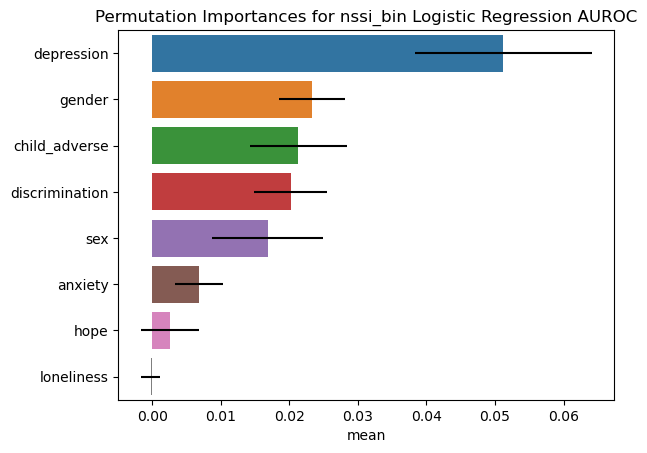

In [98]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

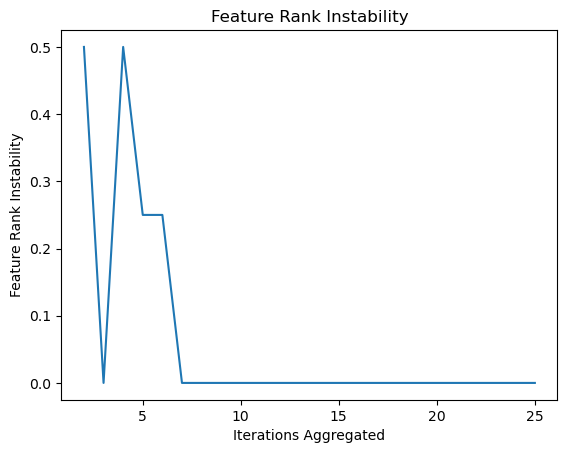

In [99]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### si_bin

#### heterosexual

In [100]:
# define target
target = data_hetero['si_bin']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [101]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [102]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [103]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.683 +/- 0.046
The mean precision with cross-validation is: 0.818 +/- 0.059
The mean recall with cross-validation is: 0.658 +/- 0.027
The mean AUROC with cross-validation is: 0.764 +/- 0.039


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.084707  0.023454
child_adverse   0.056264  0.022635
discrimination  0.017235  0.011240
hope            0.002541  0.004534
loneliness      0.000942  0.004354
gender          0.000520  0.006767
anxiety         0.000362  0.005815
sex            -0.000594  0.004473


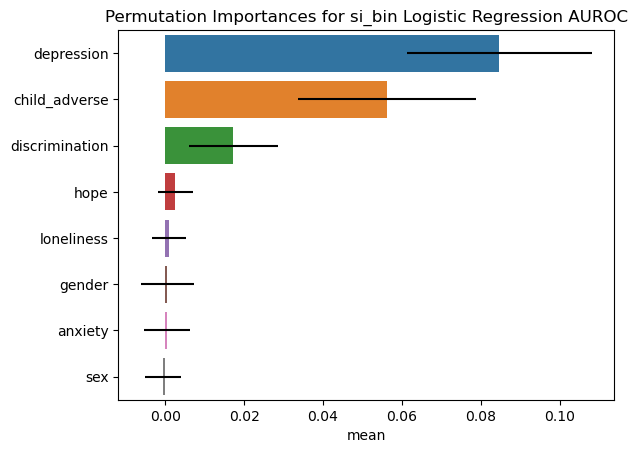

In [104]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

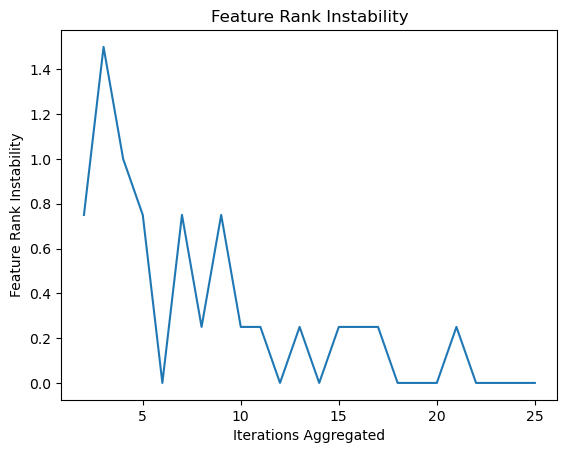

In [105]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [106]:
# define target
target = data_minor['si_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [107]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.668 +/- 0.010
The mean precision with cross-validation is: 0.918 +/- 0.015
The mean recall with cross-validation is: 0.671 +/- 0.012
The mean AUROC with cross-validation is: 0.703 +/- 0.046


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.107528  0.018305
child_adverse   0.038041  0.010182
anxiety         0.004986  0.003168
gender          0.004467  0.003813
loneliness      0.002334  0.004296
sex            -0.000173  0.003067
hope           -0.000753  0.002061
discrimination -0.001362  0.002394


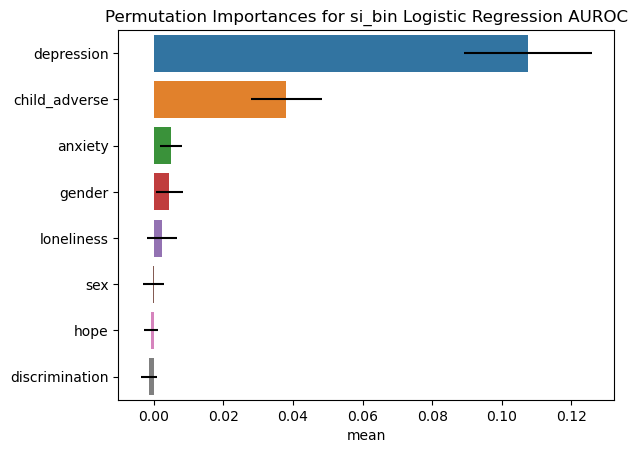

In [108]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

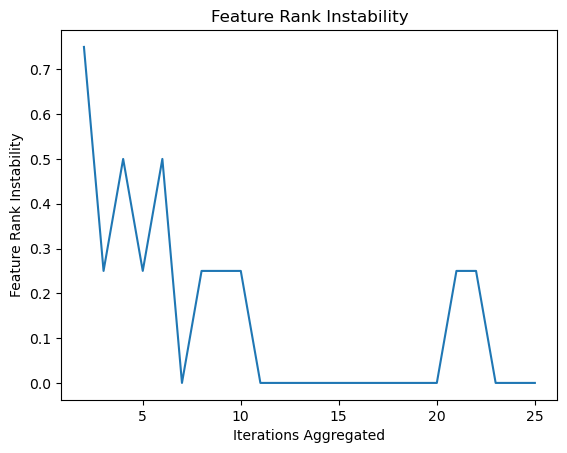

In [109]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### attempt_bin

#### heterosexual

In [110]:
# define target
target = data_hetero['attempt_bin']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = StratifiedKFold(n_splits=5)

In [111]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [112]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [113]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.715 +/- 0.017
The mean precision with cross-validation is: 0.356 +/- 0.037
The mean recall with cross-validation is: 0.723 +/- 0.166
The mean AUROC with cross-validation is: 0.793 +/- 0.073


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.065825  0.020519
child_adverse   0.040408  0.021982
discrimination  0.039587  0.019100
loneliness      0.006755  0.007391
sex            -0.000077  0.001804
hope           -0.000541  0.005316
gender         -0.000655  0.002560
anxiety        -0.001101  0.003256


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


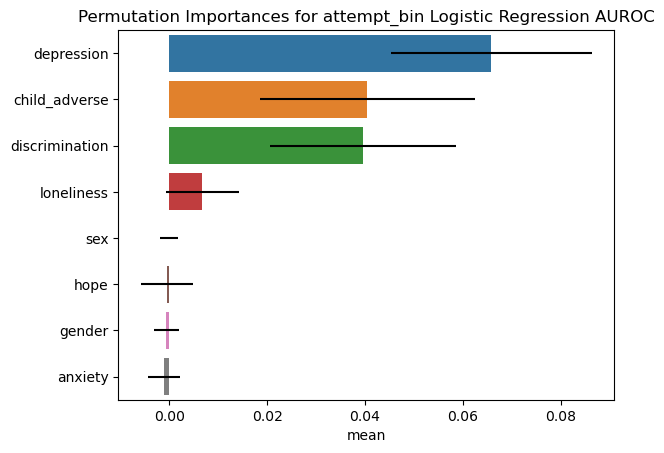

In [114]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

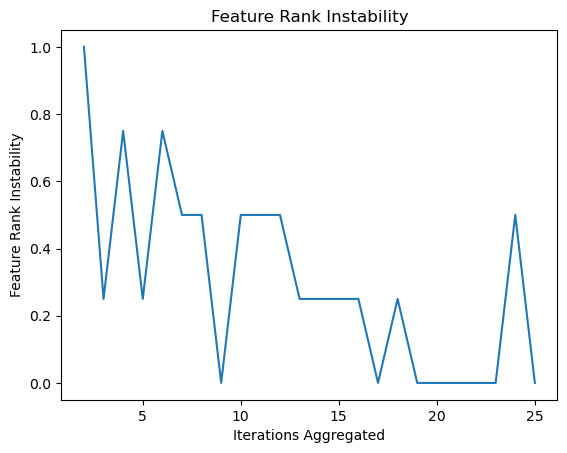

In [115]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [116]:
# define target
target = data_minor['attempt_bin']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [117]:
# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.673 +/- 0.020
The mean precision with cross-validation is: 0.532 +/- 0.023
The mean recall with cross-validation is: 0.682 +/- 0.018
The mean AUROC with cross-validation is: 0.738 +/- 0.021


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      0.078134  0.013676
discrimination  0.052006  0.010563
child_adverse   0.035409  0.008526
gender          0.003642  0.002280
hope            0.002346  0.003928
sex             0.001894  0.002224
anxiety         0.000484  0.001606
loneliness     -0.000497  0.000829


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


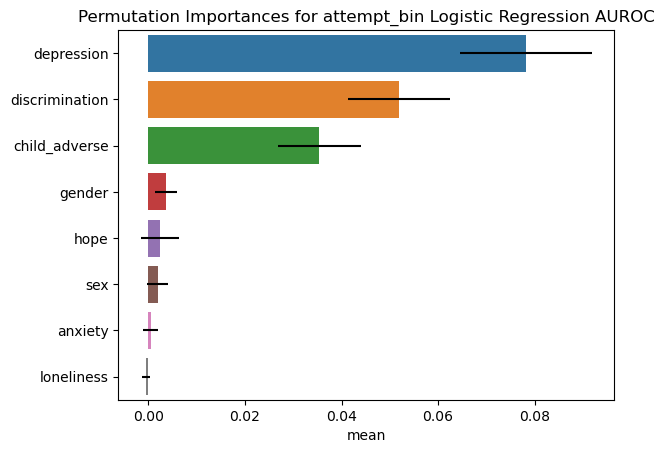

In [118]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline)

# view results
print(perm_results_summary)
plt.title("Permutation Importances for attempt_bin Logistic Regression AUROC")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

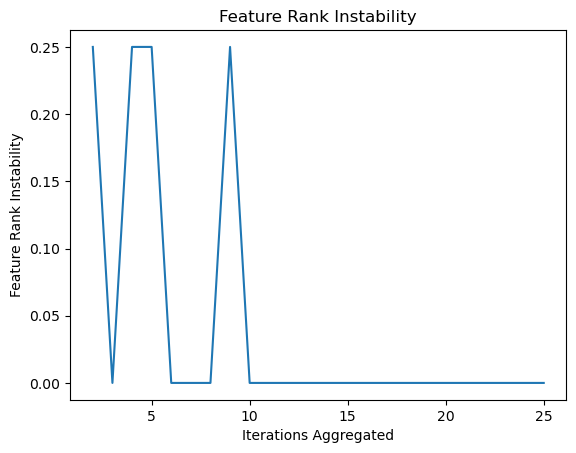

In [119]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### nssi_year

In [120]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# create subsets of data for each orientation group
data_hetero = nssi_year_data[nssi_year_data['orientation'] == 'Heterosexual/Straight'].copy()
data_minor = nssi_year_data[nssi_year_data['orientation'] != 'Heterosexual/Straight'].copy()

#### heterosexual

In [121]:
# define target
target = data_hetero['nssi_year']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [122]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [123]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [124]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 45.804 +/- 20.494
The mean Poisson deviance with cross-validation is: 40.348 +/- 15.590


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                    mean       std
depression      4.273362  4.182513
discrimination  3.815510  3.272898
hope            1.351232  2.780294
child_adverse   0.320568  0.859886
anxiety         0.254706  0.819576
sex             0.231294  0.378638
gender          0.128509  0.328638
loneliness     -0.355533  1.126668


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


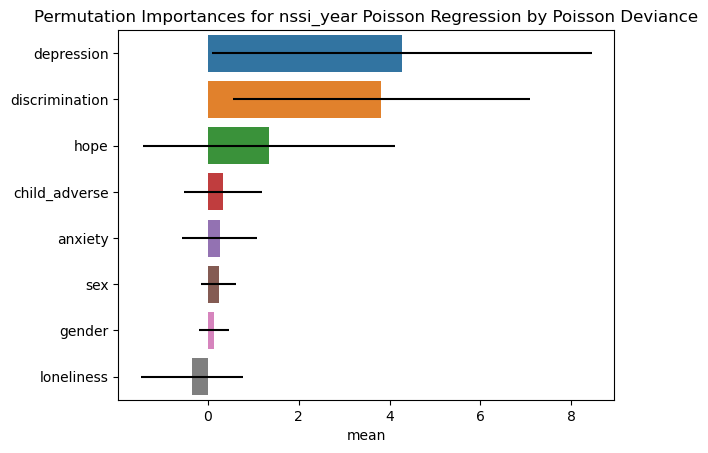

In [125]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

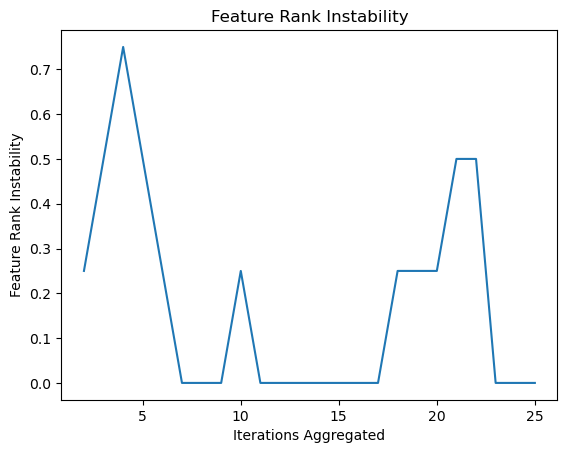

In [126]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [127]:
# define target
target = data_minor['nssi_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [128]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 98.532 +/- 25.977
The mean Poisson deviance with cross-validation is: 88.858 +/- 25.322


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                     mean       std
depression      12.419536  4.001716
discrimination   2.955011  1.745215
anxiety          2.584152  2.190310
gender           2.003372  1.444625
sex              0.587316  0.600756
child_adverse    0.198085  0.513898
loneliness       0.041792  0.448466
hope            -0.228046  0.788455


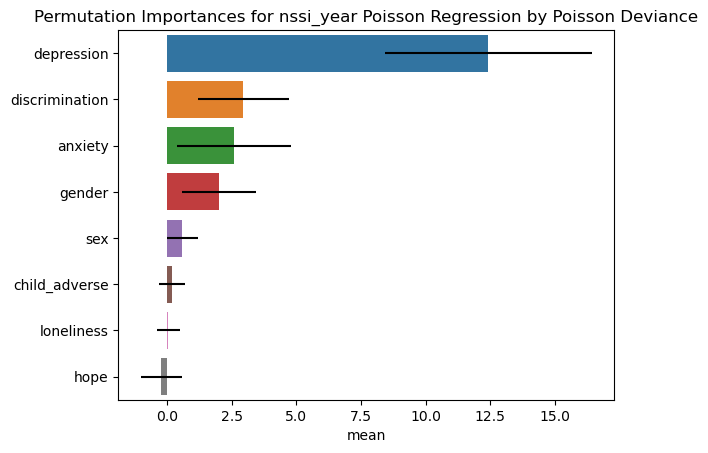

In [129]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

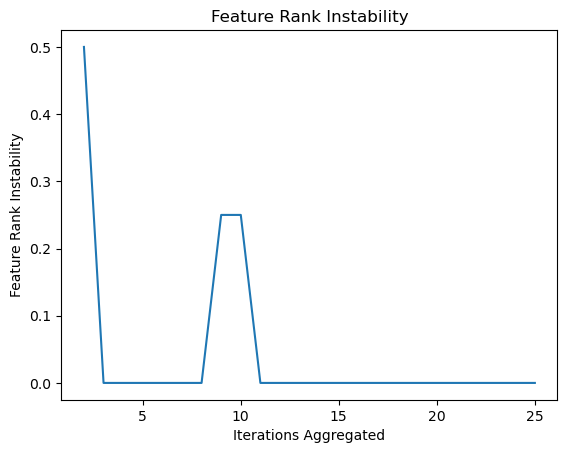

In [130]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

### si_year

In [131]:
# drop records missing si_year for si_year models
si_year_data = data.dropna(subset='si_year')

# create subsets of data for each orientation group
data_hetero = si_year_data[si_year_data['orientation'] == 'Heterosexual/Straight'].copy()
data_minor = si_year_data[si_year_data['orientation'] != 'Heterosexual/Straight'].copy()

#### heterosexual

In [132]:
# define target
target = data_hetero['si_year']

# define features
features = data_hetero[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = KFold(n_splits=5)

In [133]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [134]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [135]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 113.323 +/- 36.373
The mean Poisson deviance with cross-validation is: 103.275 +/- 30.105


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                     mean        std
depression      32.986561  14.960972
anxiety         20.663004   9.350600
loneliness       5.906671   4.884588
hope             4.207029   4.670678
child_adverse    3.817726   5.247642
gender          -0.166467   0.773254
discrimination  -0.367122   1.276699
sex             -0.489363   0.951533


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


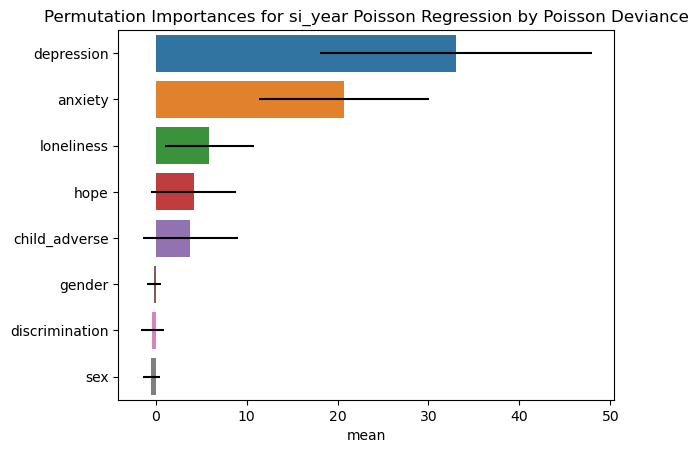

In [136]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

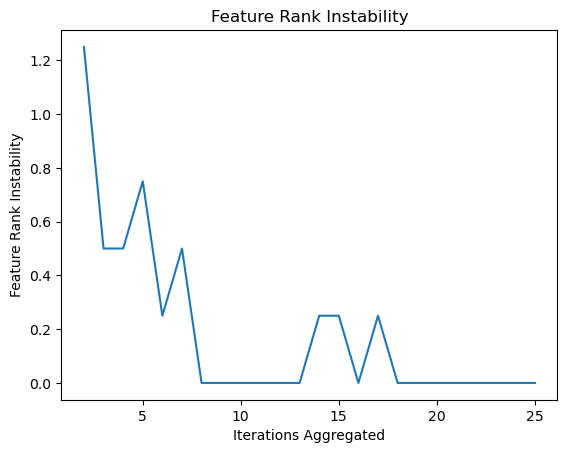

In [137]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

#### minority

In [138]:
# define target
target = data_minor['si_year']

# define features
features = data_minor[['loneliness', 'depression', 'sex', 'gender',
                   'hope', 'child_adverse', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

In [139]:
# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 154.333 +/- 18.204
The mean Poisson deviance with cross-validation is: 148.859 +/- 20.114


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean
C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the 

                     mean       std
depression      24.729749  5.878686
anxiety          7.099693  3.342226
child_adverse    1.370503  1.302352
loneliness       1.032493  1.268239
discrimination   0.720975  1.364061
sex             -0.170881  0.412023
hope            -0.211070  1.070683
gender          -0.266305  0.609513


C:\Users\jpowe\slash\tmp\ipykernel_13048\1666038455.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  perm_results_df.iloc[:, i] = perm_results.importances_mean


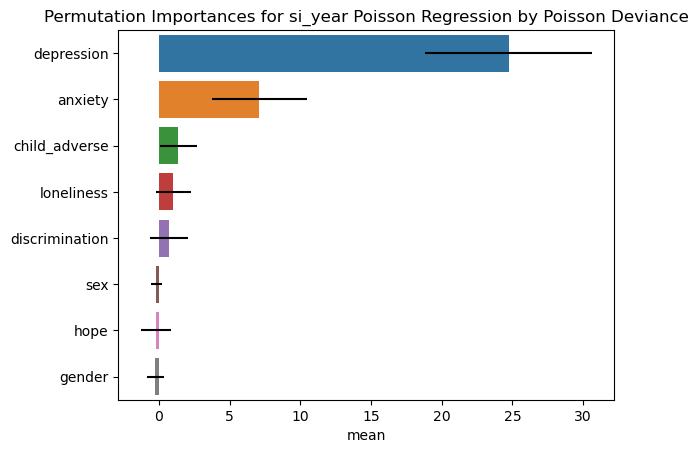

In [140]:
# compute permutation importance
perm_results_df, perm_results_summary = perm_feat_imp(pipeline, score='neg_mean_poisson_deviance')

# view results
print(perm_results_summary)
plt.title("Permutation Importances for si_year Poisson Regression by Poisson Deviance")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

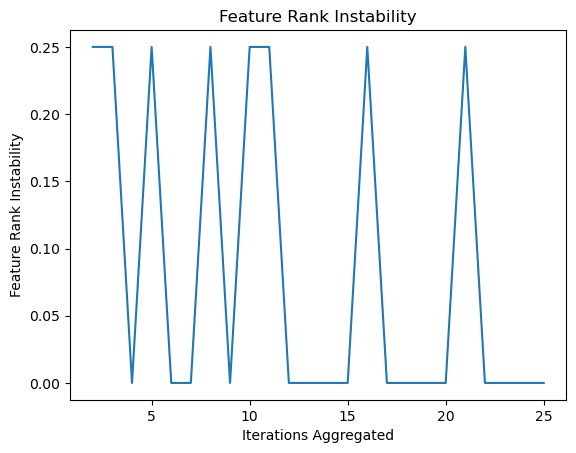

In [141]:
# feature rank instability plot
instability = rank_instability(perm_results_df)

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None